# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

(I strongly recommend you to try this notebook on the Udacity workspace first before running it locally on your desktop/laptop, as performance might suffer in different environments)

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# install package for displaying animation
# !pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cpu


In [8]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
/home/arko/anaconda3/envs/udacity_deep_rl/lib/python3.10/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/arko/anaconda3/envs/udacity_deep_rl/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
state = env.reset()
type(state), state.shape

(numpy.ndarray, (210, 160, 3))

In [4]:
env.action_space

Discrete(6)

In [5]:
frame, reward, is_done, info = env.step(action=2)
print(f"{reward=}")
print(f"{is_done=}")
print(info)
print(state.shape)

reward=0.0
is_done=False
{'lives': 0, 'episode_frame_number': 4, 'frame_number': 4}
(210, 160, 3)


/home/arko/anaconda3/envs/udacity_deep_rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


In [6]:
import random 

state = env.reset()
counter = 0
reward_total = 0
while True:
    action = random.choice(range(6))
    frame, reward, is_done, info = env.step(action)
    print(f"{action=}, {reward=}, {is_done=}, {info}")
    reward_total += reward
    counter += 1
    if is_done:
        break
print(f"{counter=}, {reward_total=}")

action=5, reward=0.0, is_done=False, {'lives': 0, 'episode_frame_number': 4, 'frame_number': 8}
action=0, reward=0.0, is_done=False, {'lives': 0, 'episode_frame_number': 8, 'frame_number': 12}
action=4, reward=0.0, is_done=False, {'lives': 0, 'episode_frame_number': 12, 'frame_number': 16}
action=0, reward=0.0, is_done=False, {'lives': 0, 'episode_frame_number': 16, 'frame_number': 20}
action=3, reward=0.0, is_done=False, {'lives': 0, 'episode_frame_number': 20, 'frame_number': 24}
action=5, reward=0.0, is_done=False, {'lives': 0, 'episode_frame_number': 24, 'frame_number': 28}
action=4, reward=0.0, is_done=False, {'lives': 0, 'episode_frame_number': 28, 'frame_number': 32}
action=5, reward=0.0, is_done=False, {'lives': 0, 'episode_frame_number': 32, 'frame_number': 36}
action=5, reward=0.0, is_done=False, {'lives': 0, 'episode_frame_number': 36, 'frame_number': 40}
action=5, reward=0.0, is_done=False, {'lives': 0, 'episode_frame_number': 40, 'frame_number': 44}
action=5, reward=0.0, i

# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



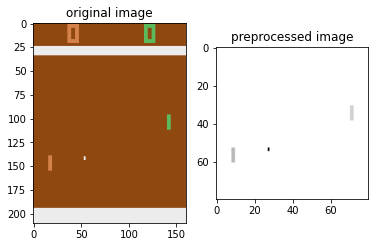

In [7]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



In [8]:
pong_utils.preprocess_single(frame)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


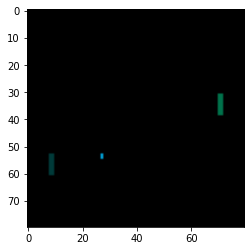

In [16]:
plt.imshow(frame[34:-16:2,::2] - np.array([244, 72, 17]), cmap="Greys")

(80, 80)


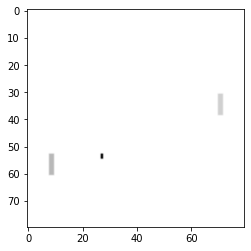

In [21]:
x = np.mean(frame[34:-16:2,::2] - np.array([244, 72, 17]), -1) / 255
print(x.shape)
plt.imshow(x, cmap="Greys")

In [53]:
import numpy as np
import cv2

(210, 160, 3) (160, 160, 3) (160, 160) (210, 160)


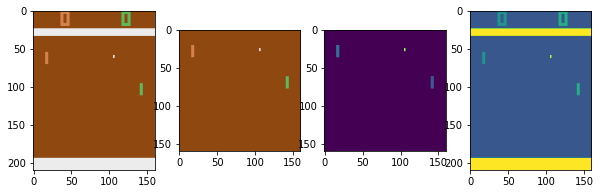

In [68]:
env.reset()
for _ in range(50):
    env.step(0)
frame, _, _, _ = env.step(1)
_, ax = plt.subplots(1, 4, figsize=[10, 4])

frame_proc1 = frame[34:-16,]
frame_proc2 = np.average(frame_proc1,axis = 2)
frame_proc3 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# cv2.resize(frame_proc2,(84,84),interpolation = cv2.INTER_NEAREST)
print(frame.shape, frame_proc1.shape, frame_proc2.shape, frame_proc3.shape)
ax[0].imshow(frame)
ax[1].imshow(frame_proc1)
ax[2].imshow(frame_proc2)
ax[3].imshow(frame_proc3)

In [81]:
frame, _, _, _ = env.step(1)
frame.shape, type(frame)

((210, 160, 3), numpy.ndarray)

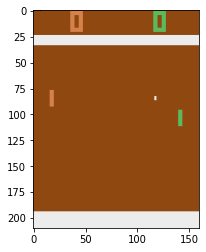

In [82]:
plt.imshow(frame)

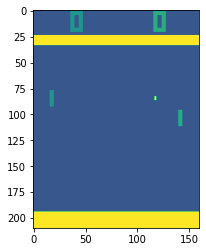

In [83]:
# frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(frame)

In [80]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


TypeError: Image data of dtype object cannot be converted to float

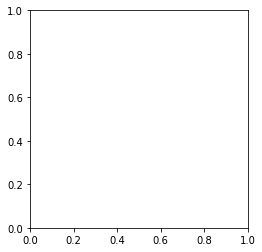

In [62]:
plt.imshow(transforms.Grayscale(frame))

In [56]:
def resize_frame(frame):
    frame = frame[30:-12,5:-4]
    frame = np.average(frame,axis = 2)
    frame = cv2.resize(frame,(84,84),interpolation = cv2.INTER_NEAREST)
    frame = np.array(frame,dtype = np.uint8)
    return frame

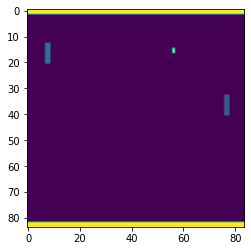

In [57]:
frame = resize_frame(frame)
plt.imshow(frame)

# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # output = 20x20 here
        self.conv = nn.Conv2d(2, 1, kernel_size=4, stride=4)
        self.size=1*20*20
        
        # 1 fully connected layer
        self.fc = nn.Linear(self.size, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.conv(x))
        # flatten the tensor
        x = x.view(-1,self.size)
        return self.sig(self.fc(x))

# use your own policy!
# policy=Policy().to(device)


policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


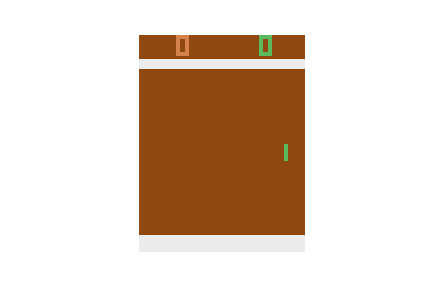
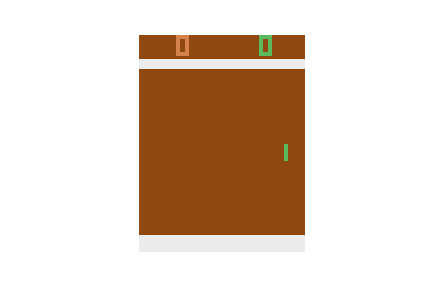
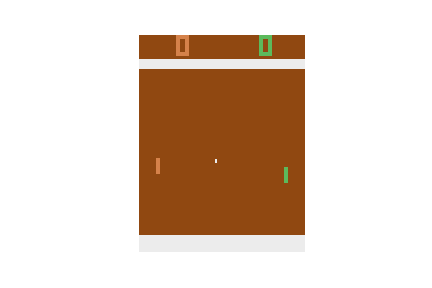
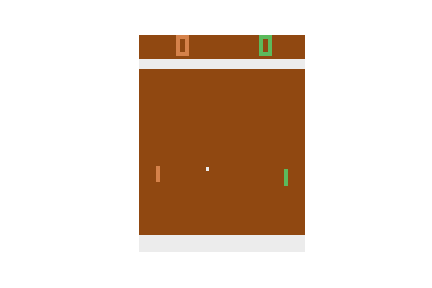
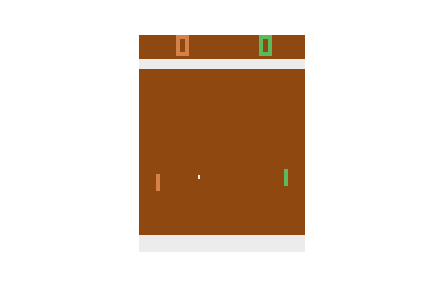
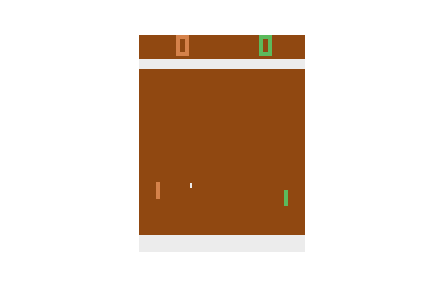
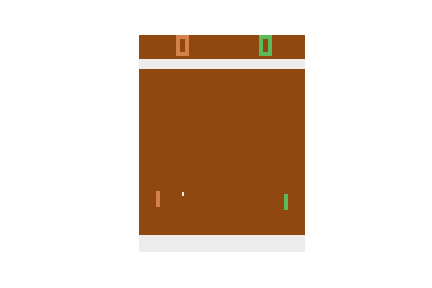
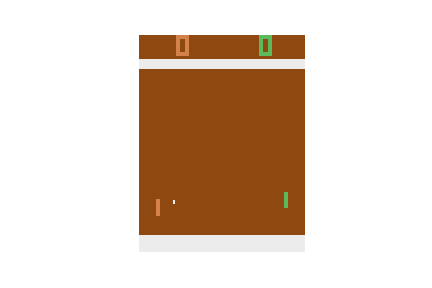
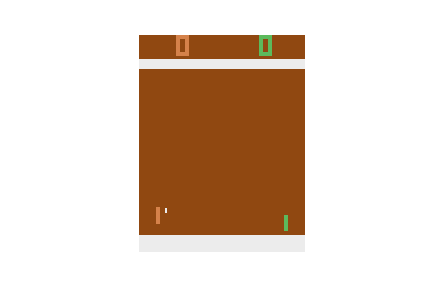
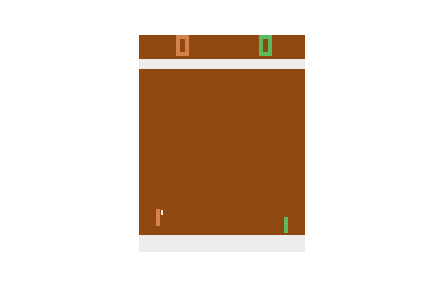
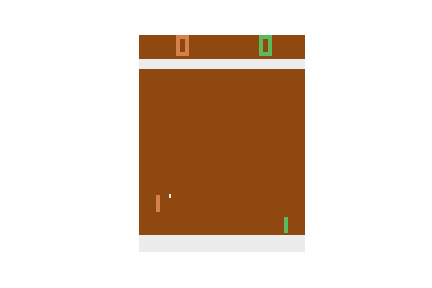
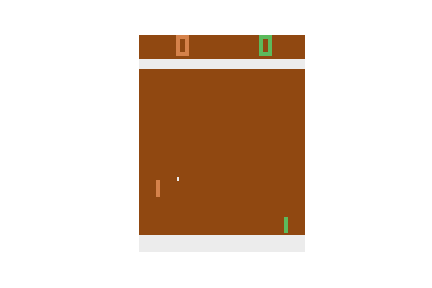
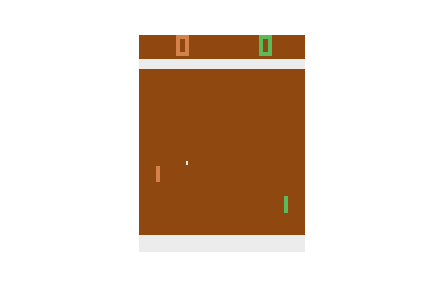
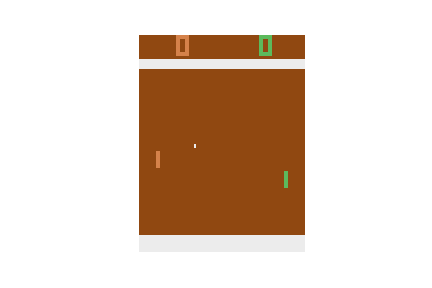
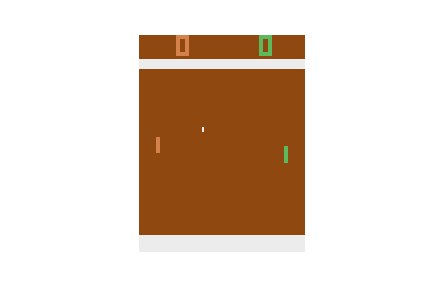
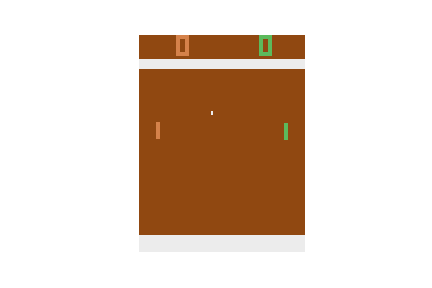
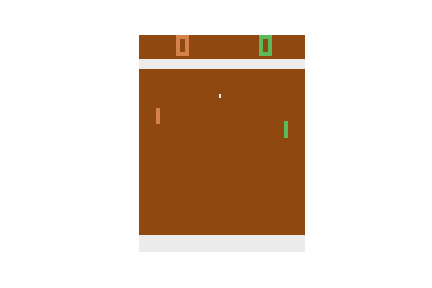
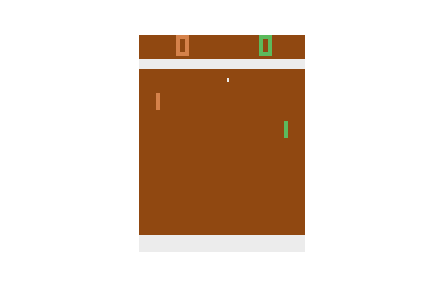
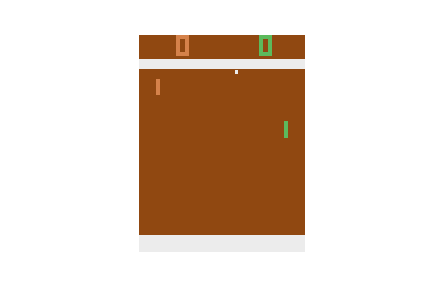
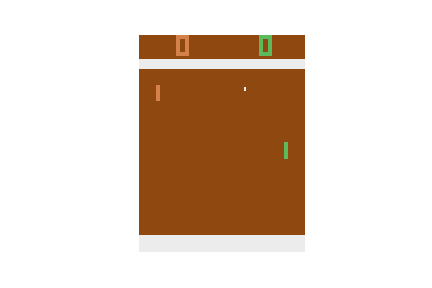
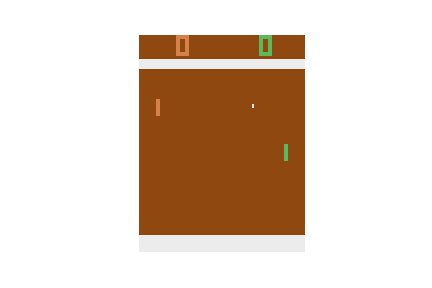
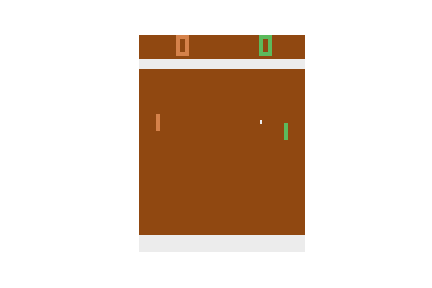
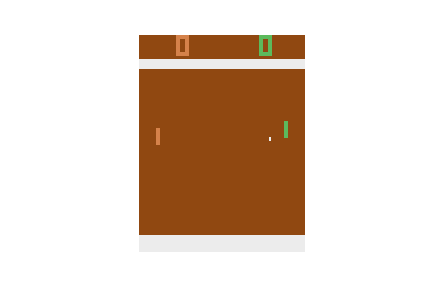
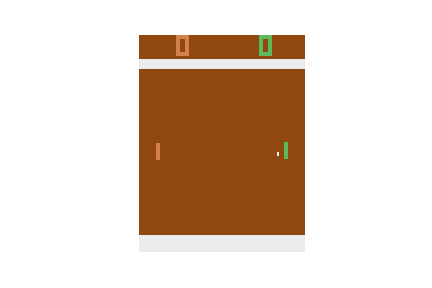
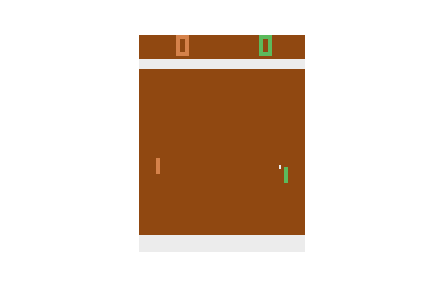
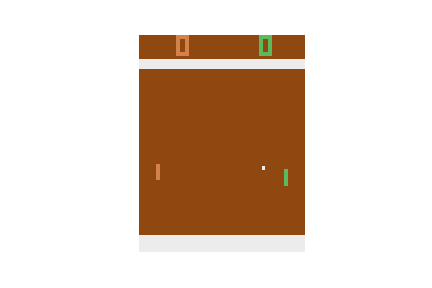
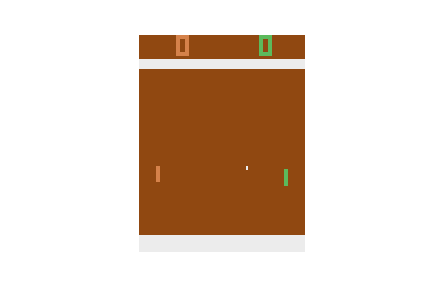
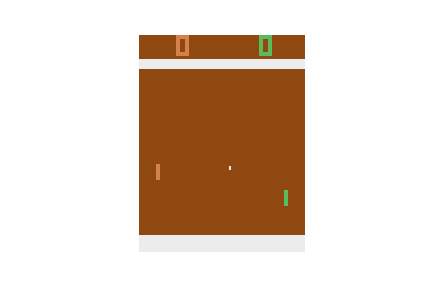
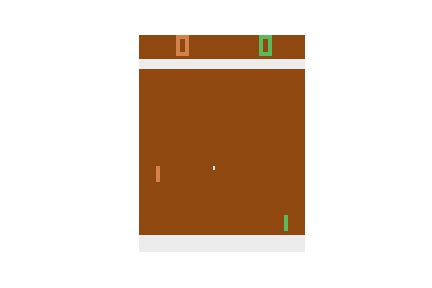
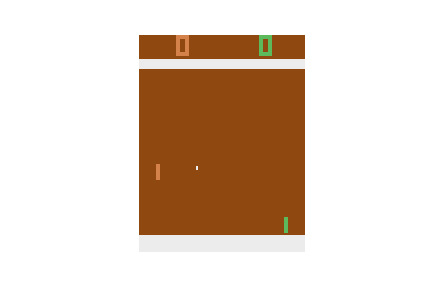
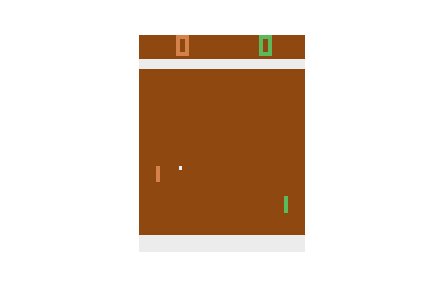
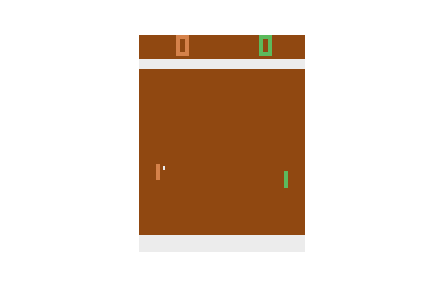
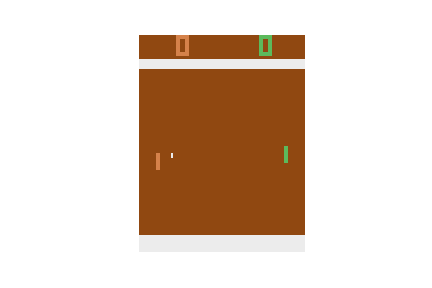
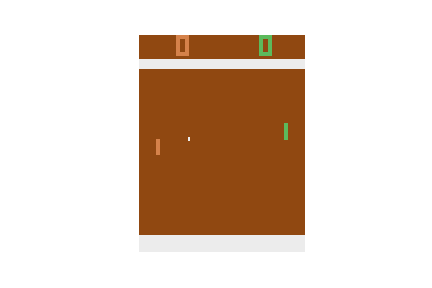
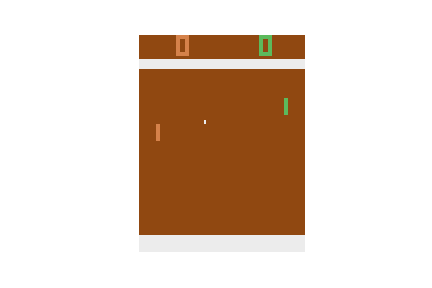
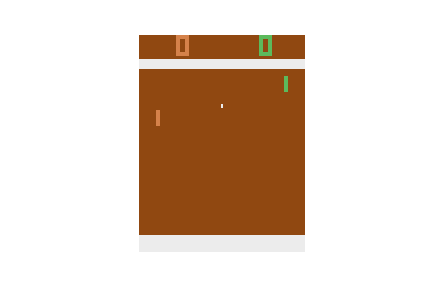
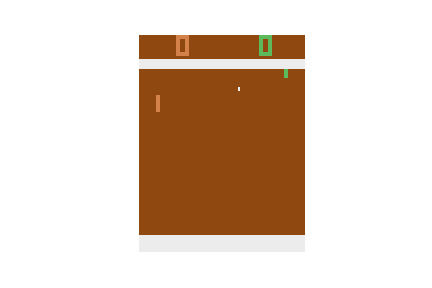
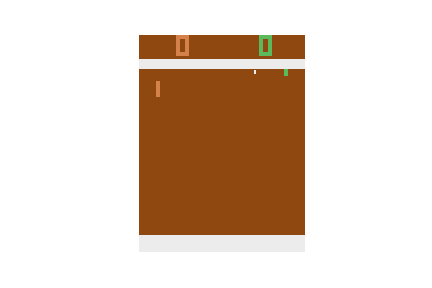
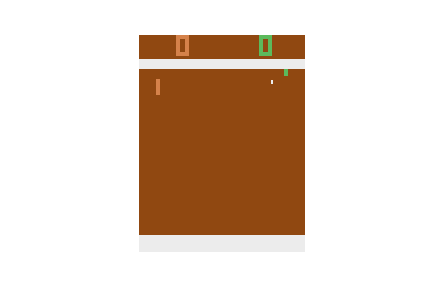
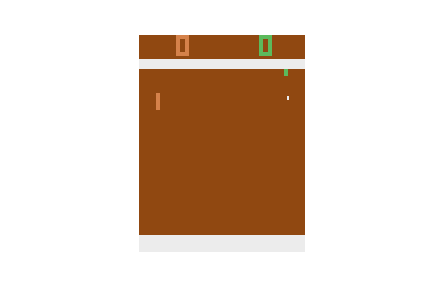
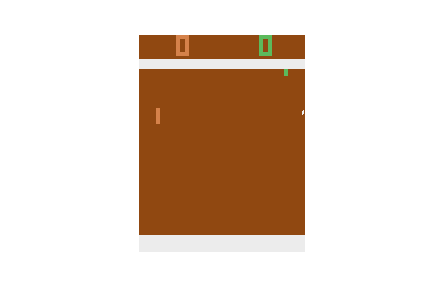
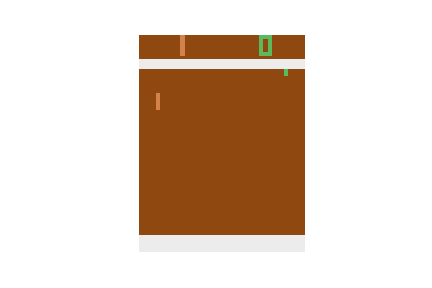
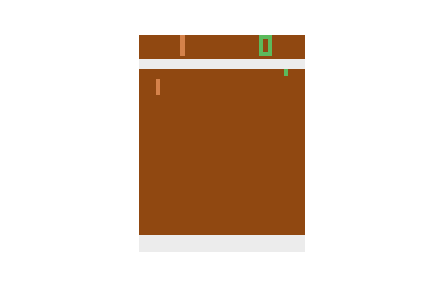
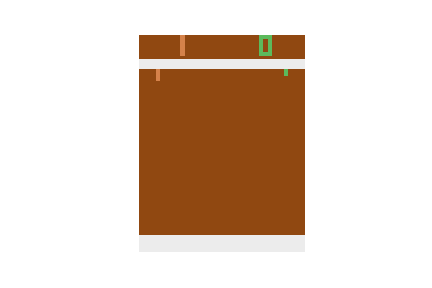
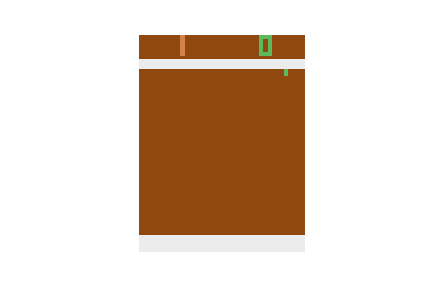
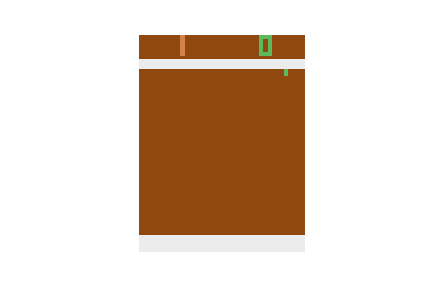
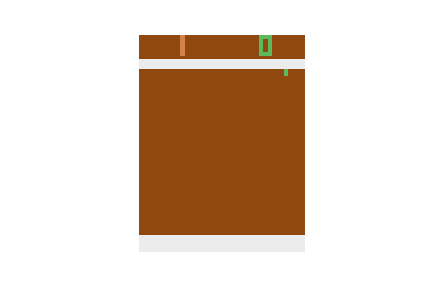
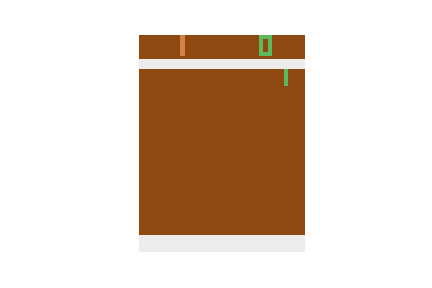
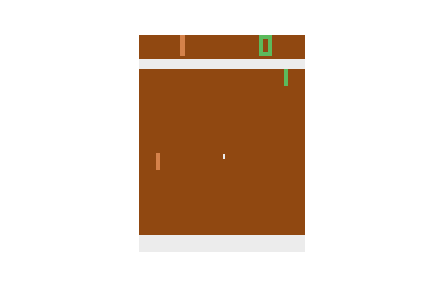
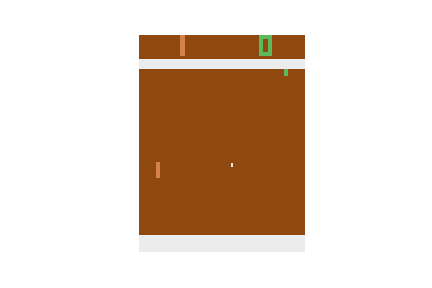
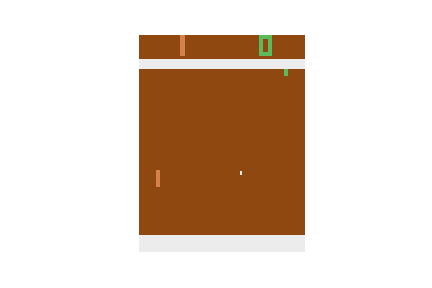
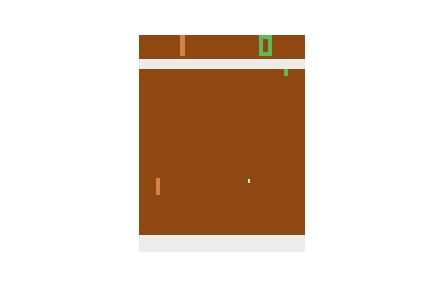
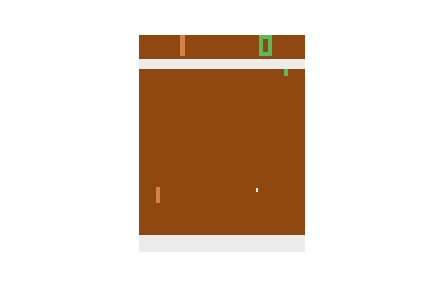
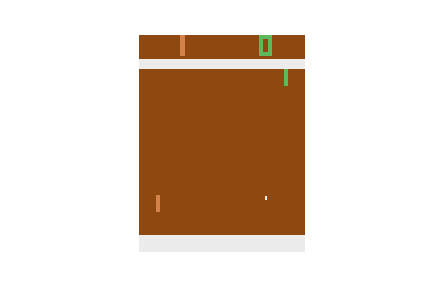
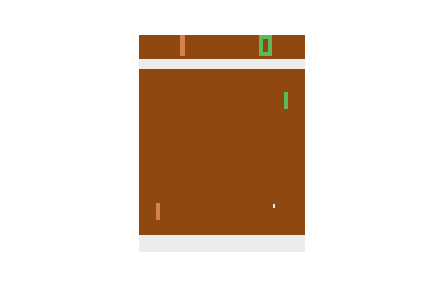
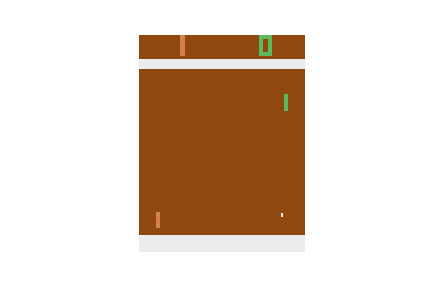
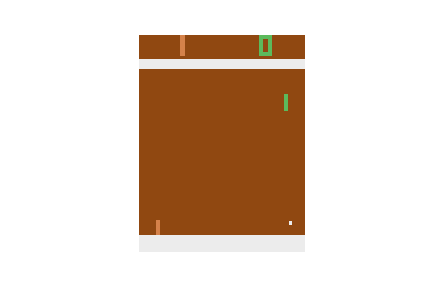
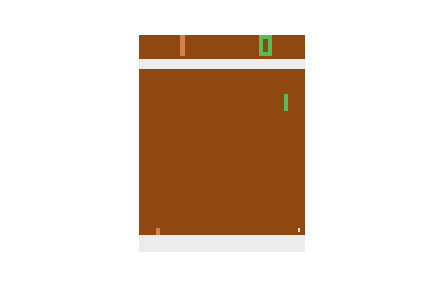
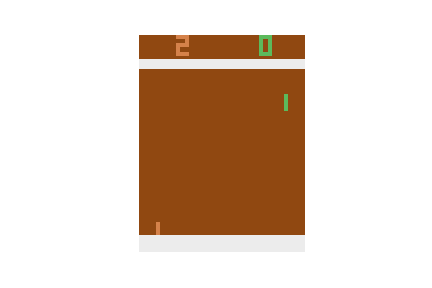
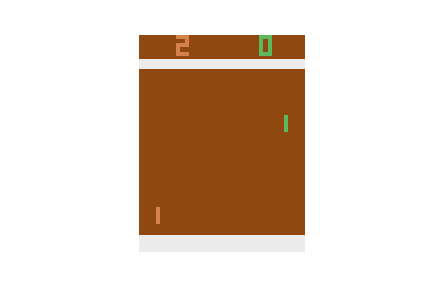
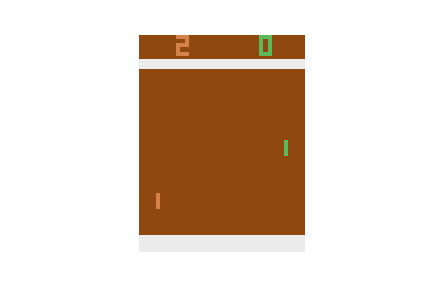
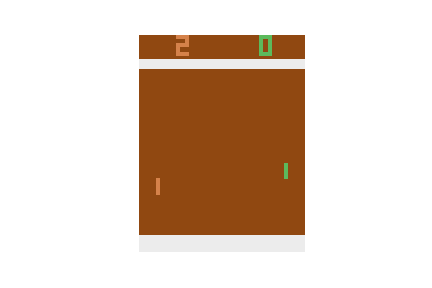
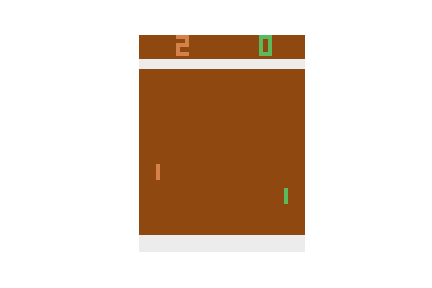
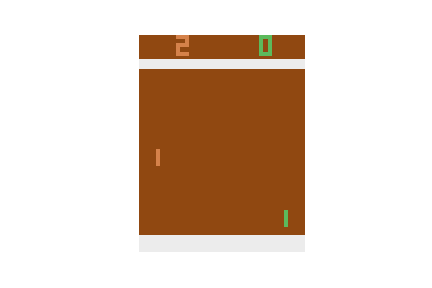
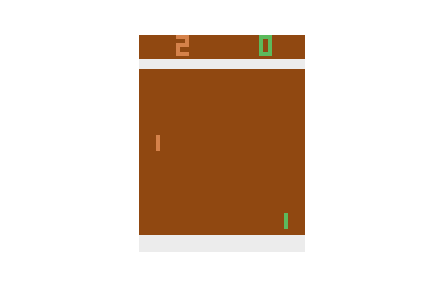
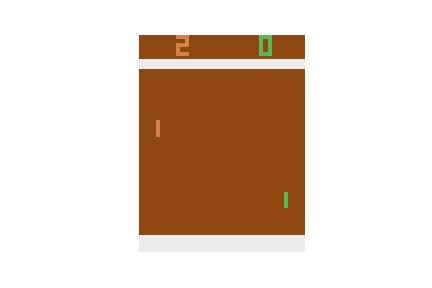
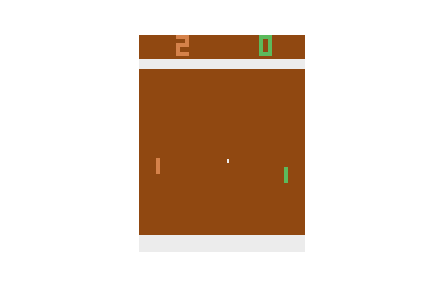
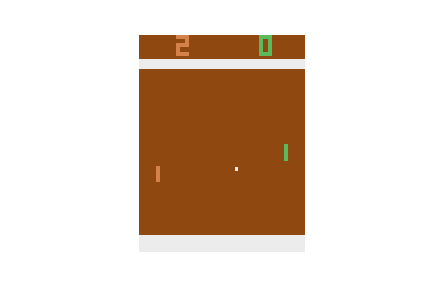
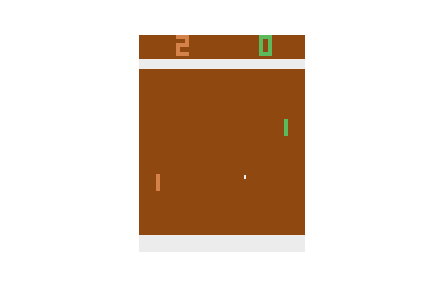
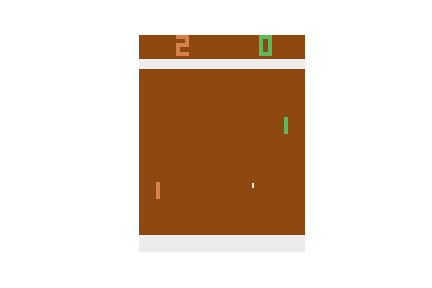
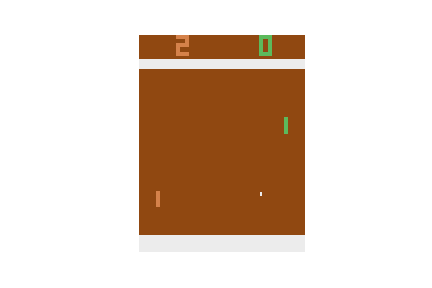
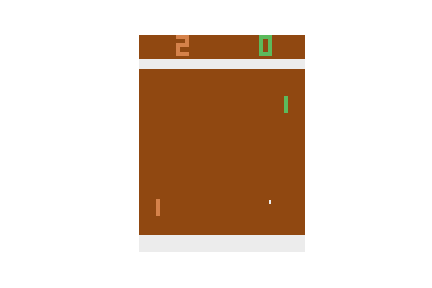
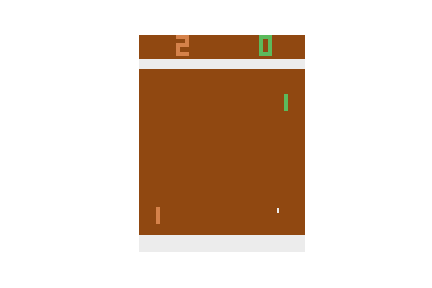
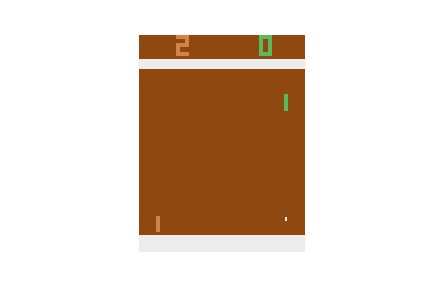
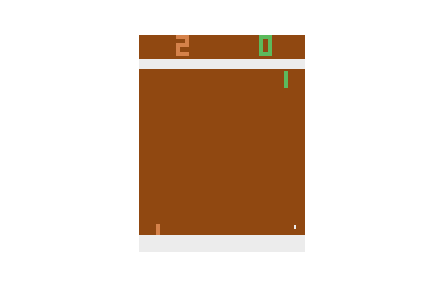
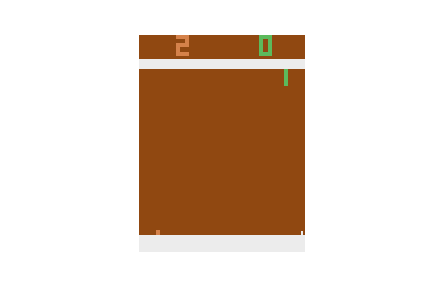
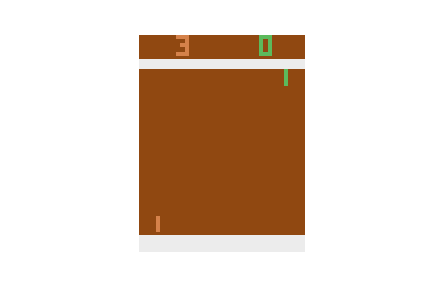
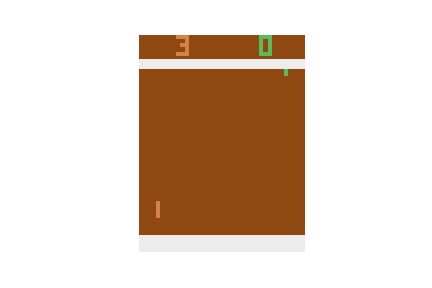
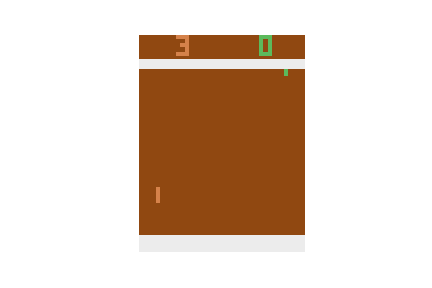
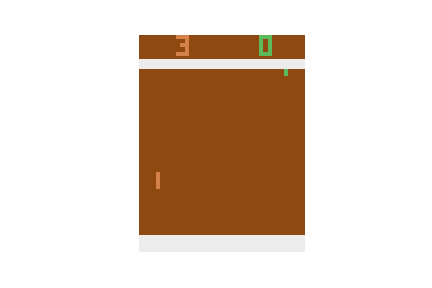
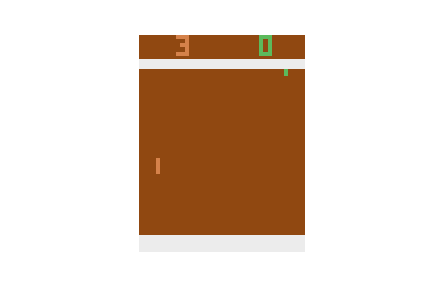
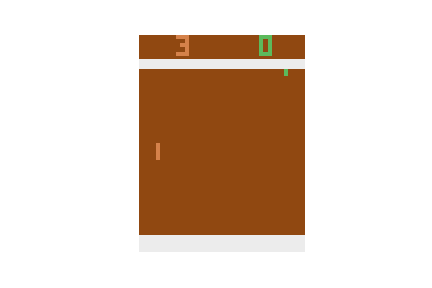
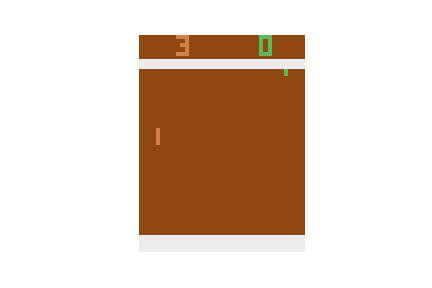
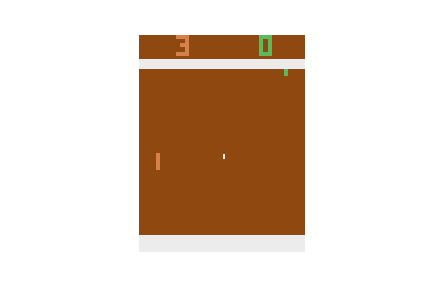
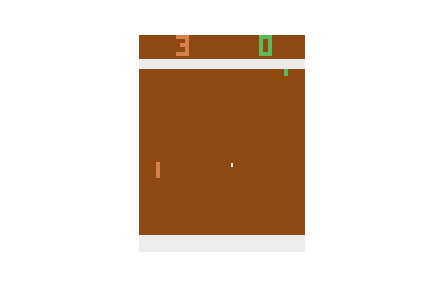
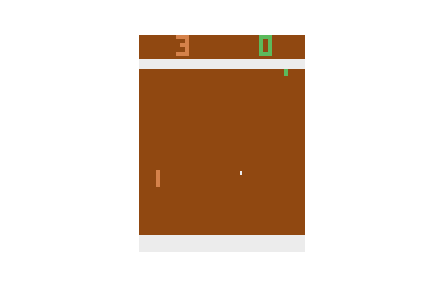
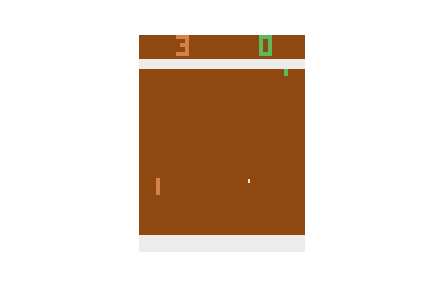
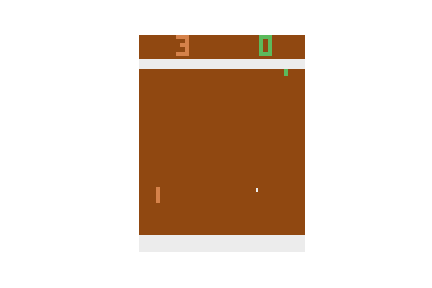
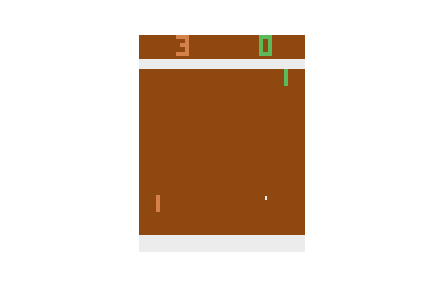
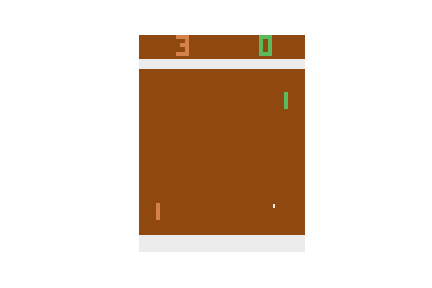
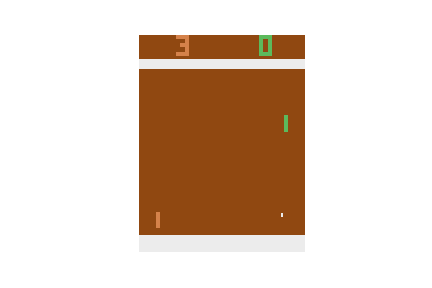
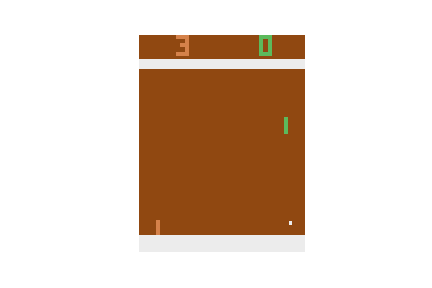
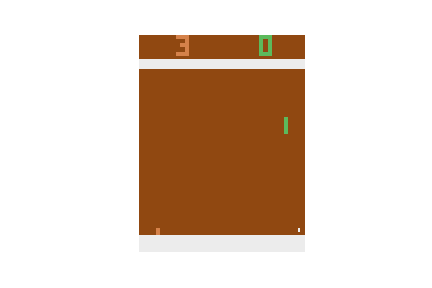
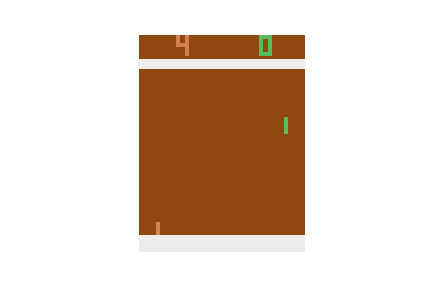
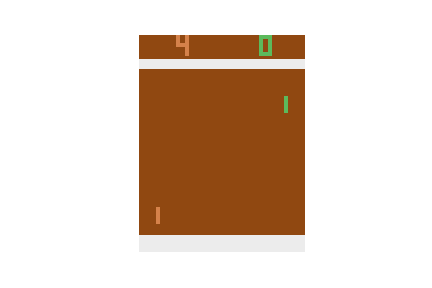
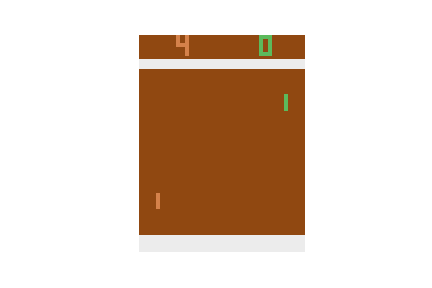
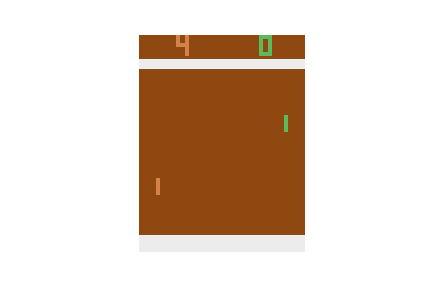
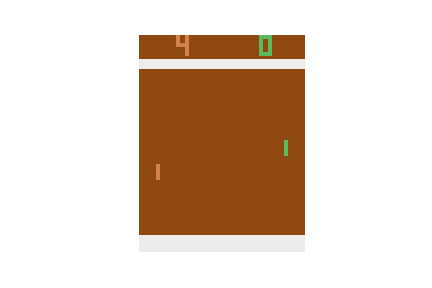
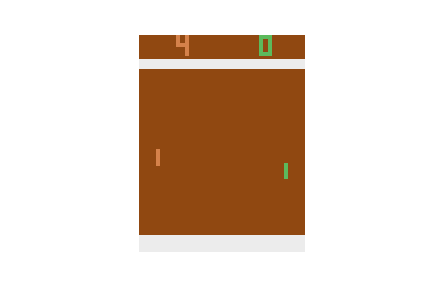
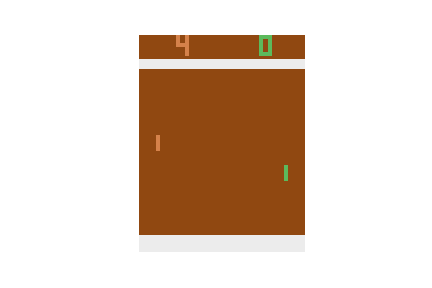

In [5]:
pong_utils.play(env, policy, time=100) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [6]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

In [ ]:
print(reward)

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

In [13]:
def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    
    actions = torch.tensor(actions, dtype=torch.int8, device=device)

    
    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)

    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(beta*entropy)


Lsur= surrogate(policy, prob, state, action, reward)

print(Lsur)

tensor(1.00000e-03 *
       -6.9290)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [ ]:
from parallelEnv import parallelEnv
import numpy as np
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500
# episode = 800

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .01
tmax = 320

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # this is the SOLUTION!
    # use your own surrogate function
    # L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
    L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()
    


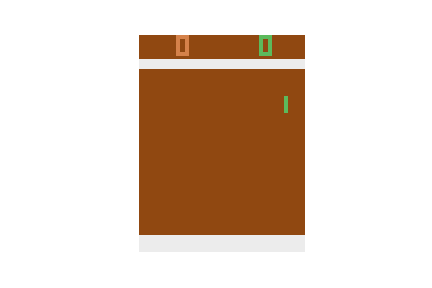
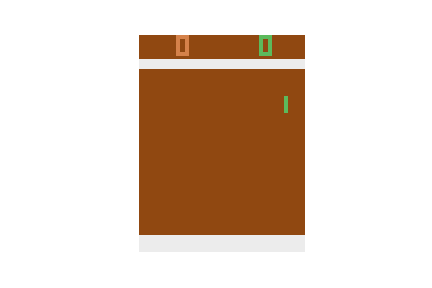
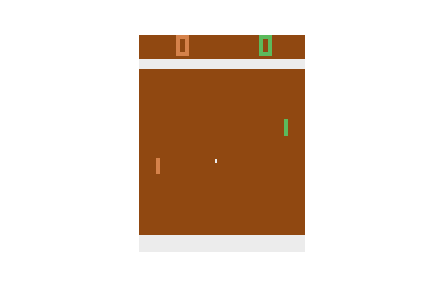
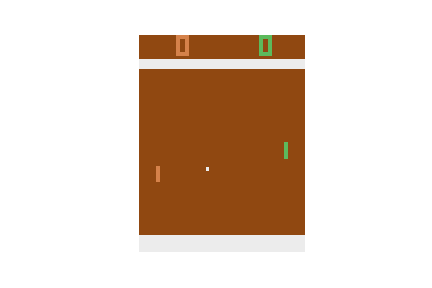
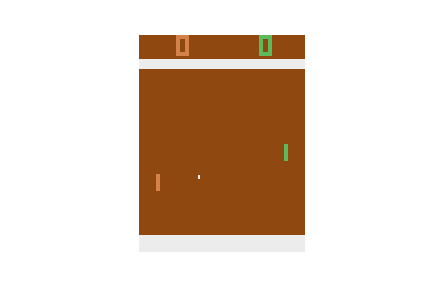
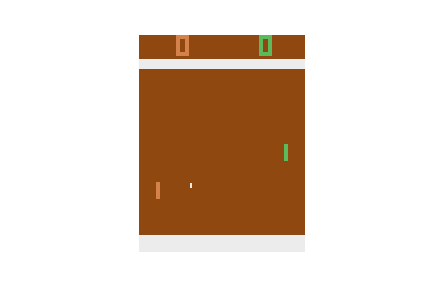
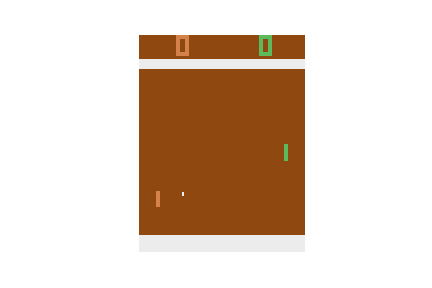
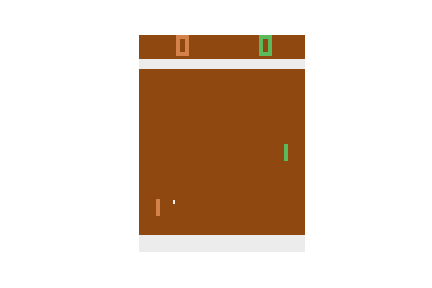
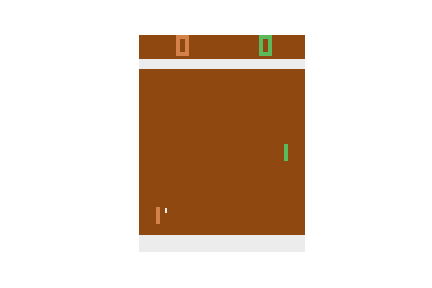
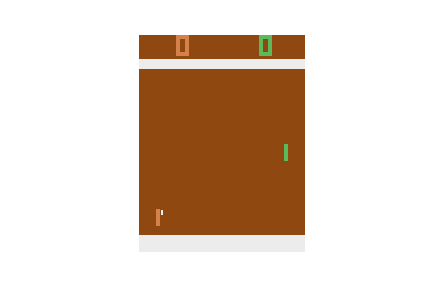
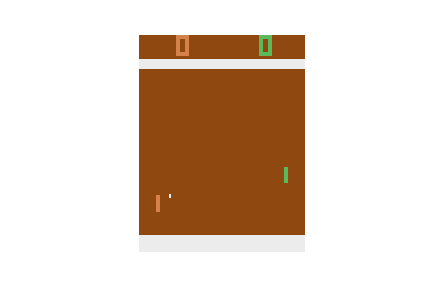
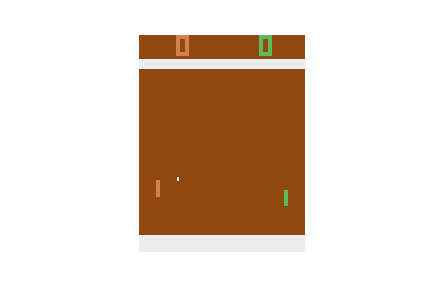
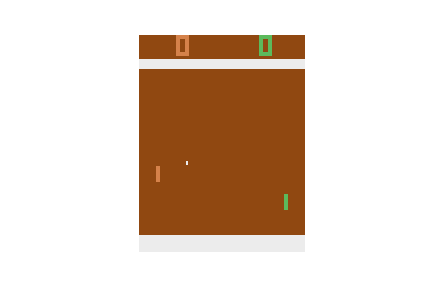
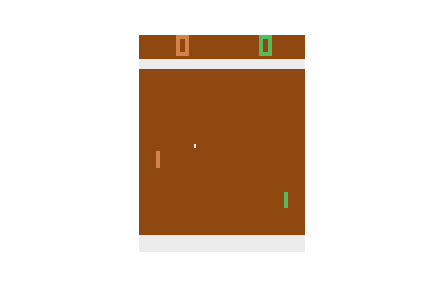
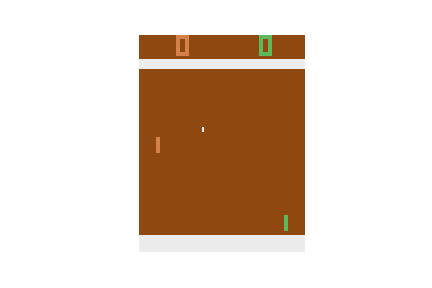
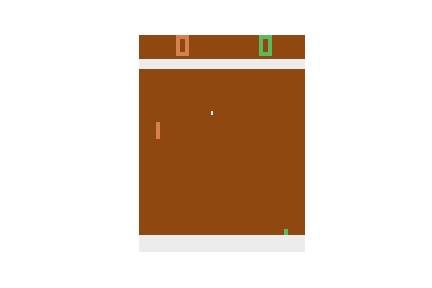
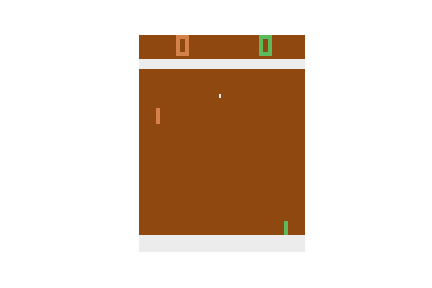
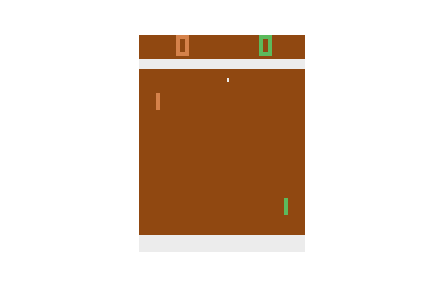
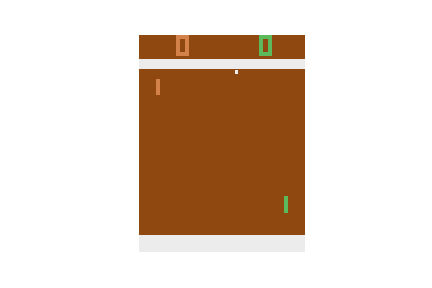
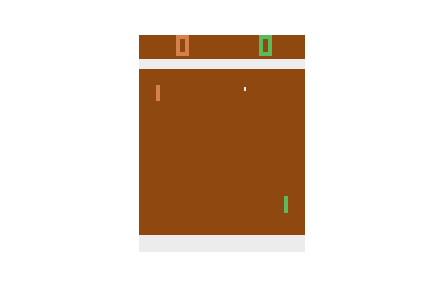
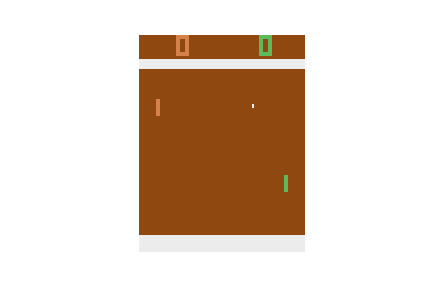
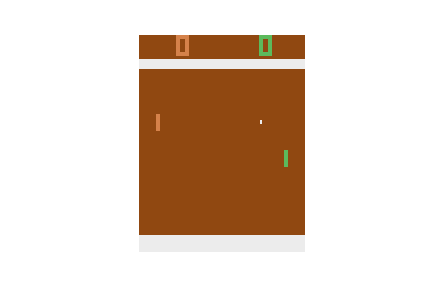
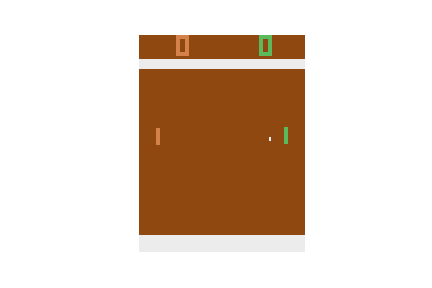
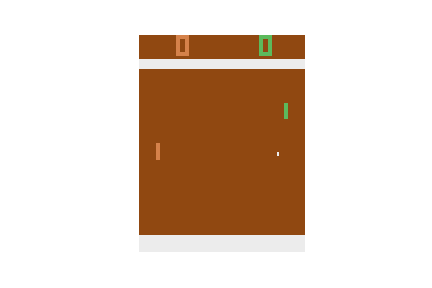
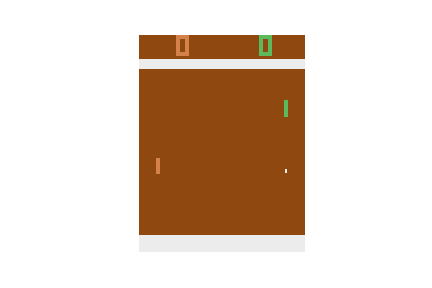
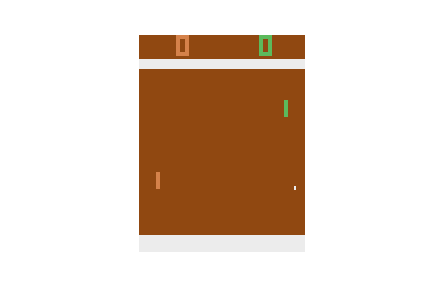
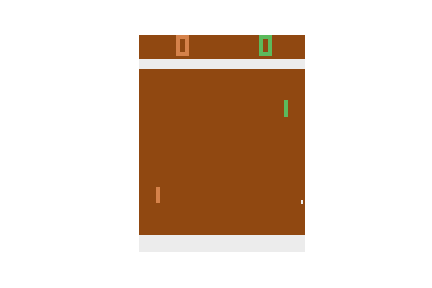
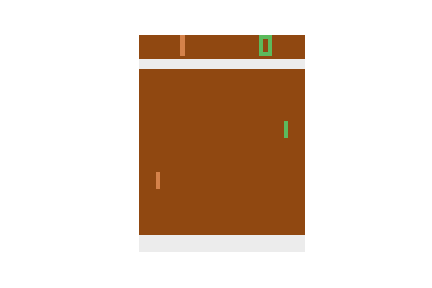
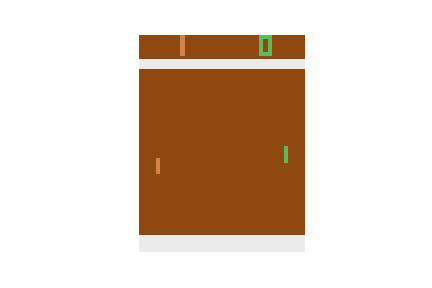
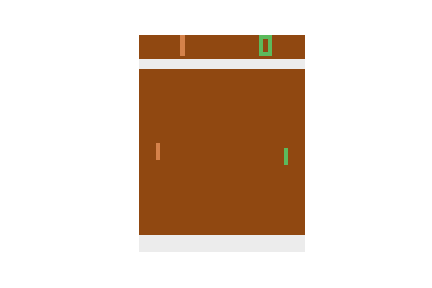
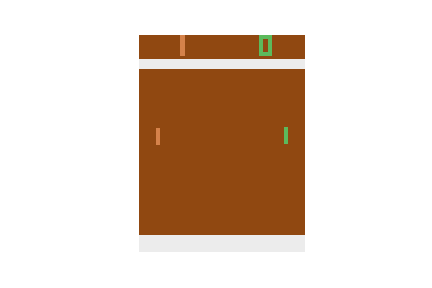
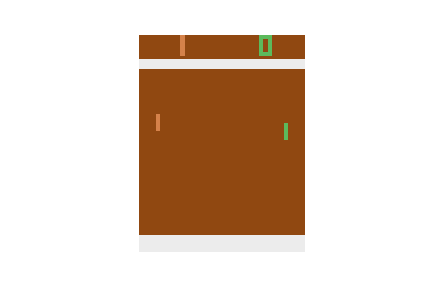
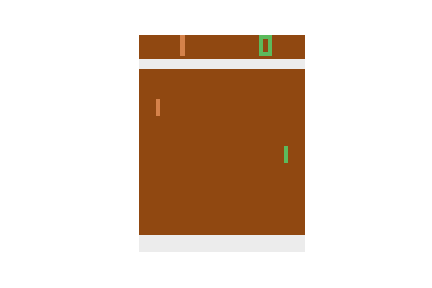
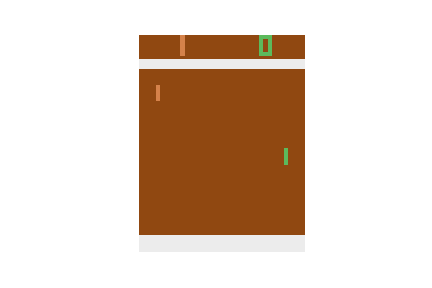
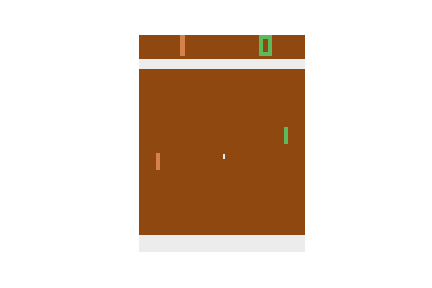
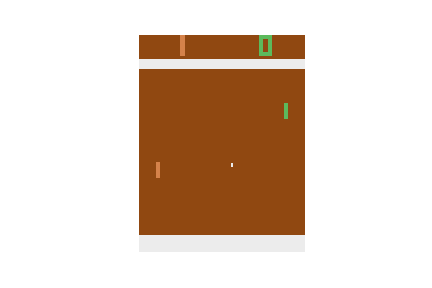
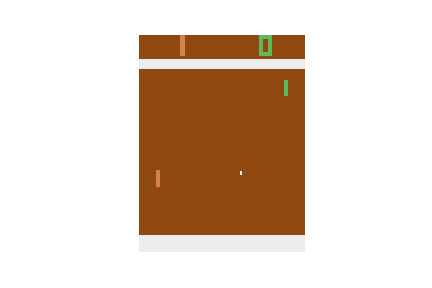
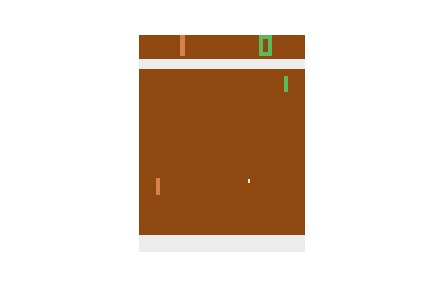
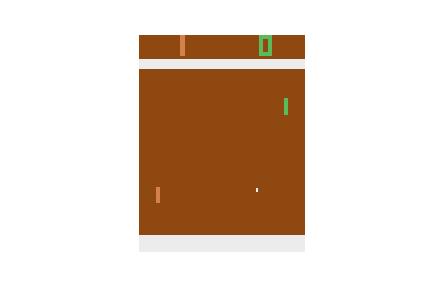
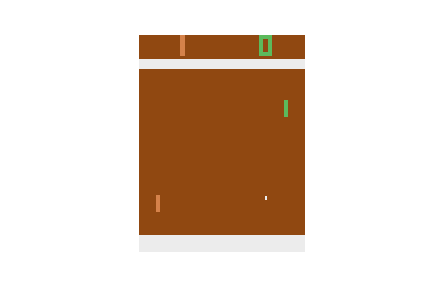
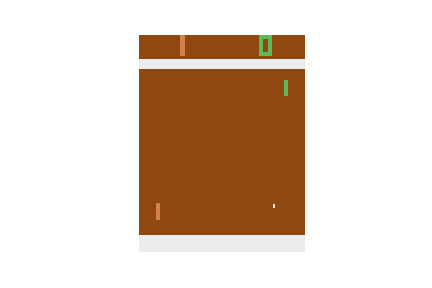
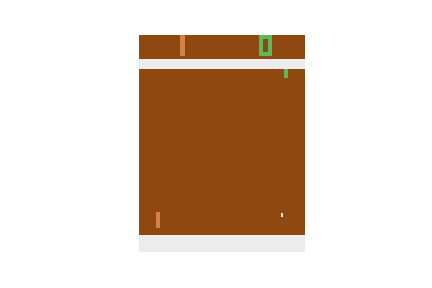
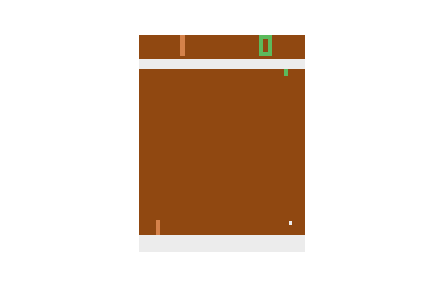
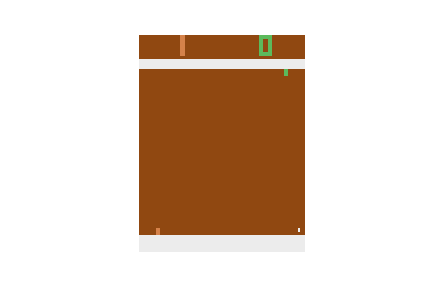
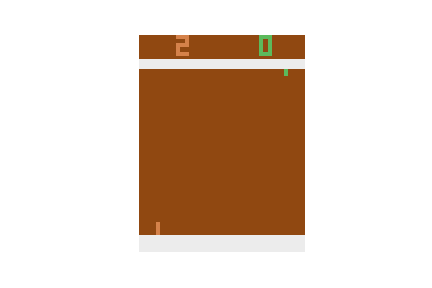
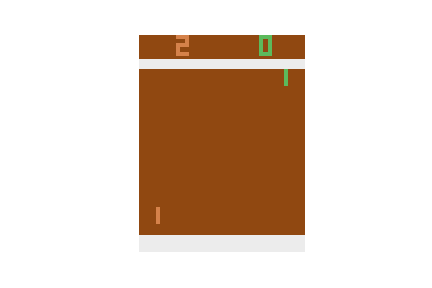
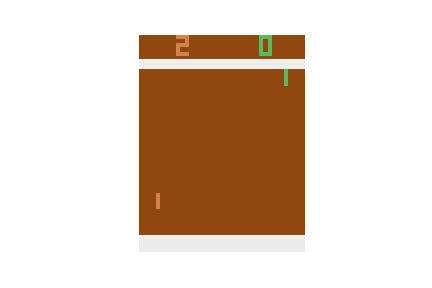
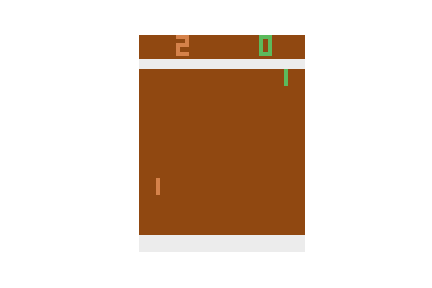
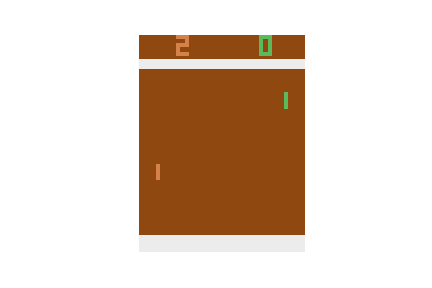
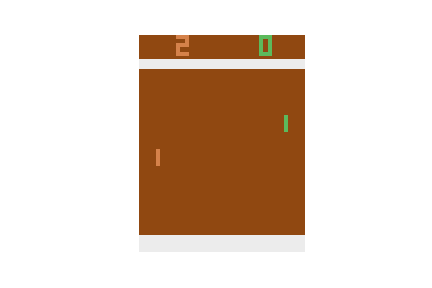
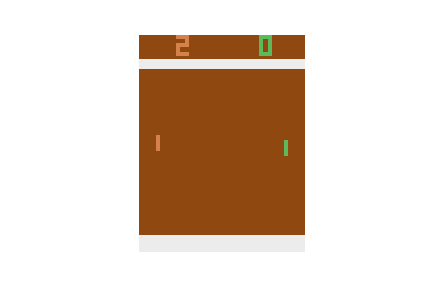
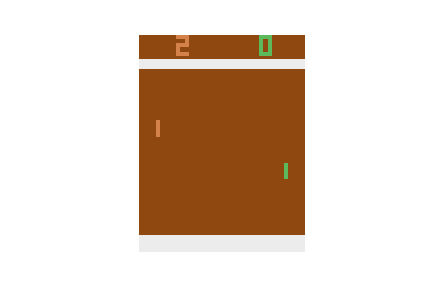
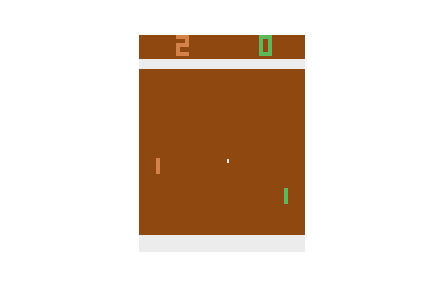
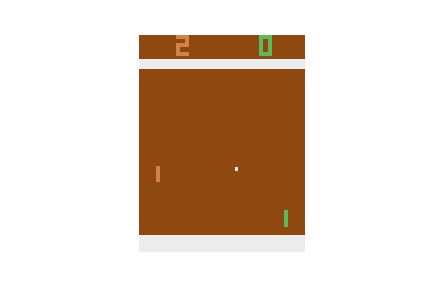
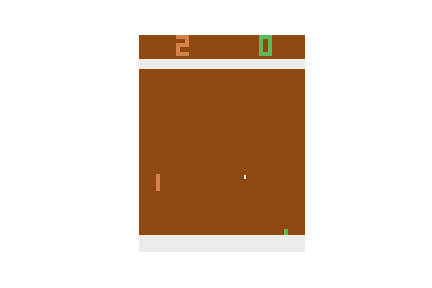
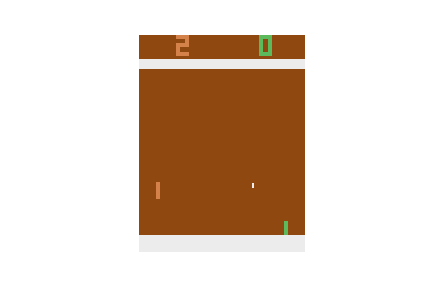
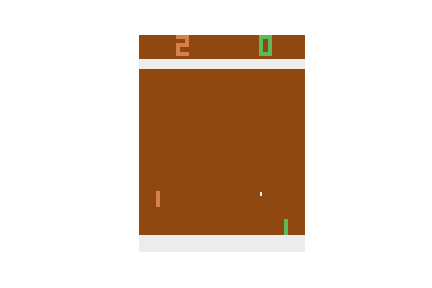
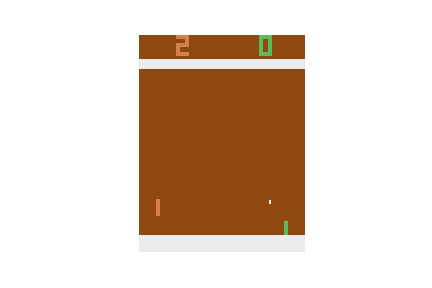
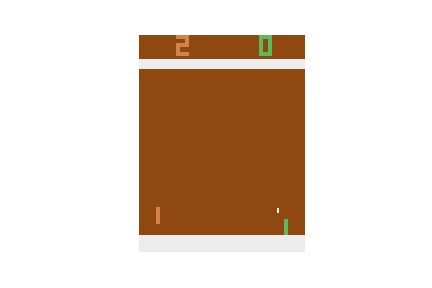
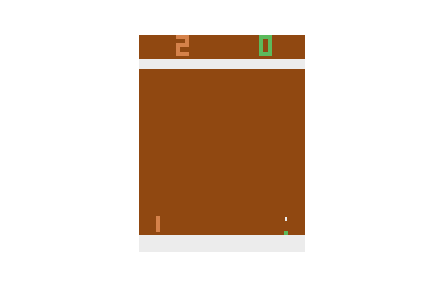
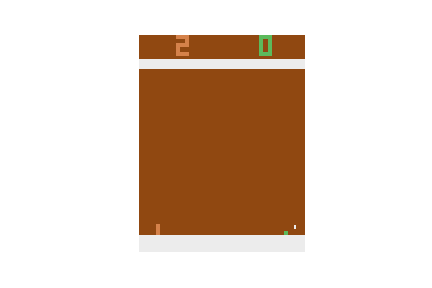
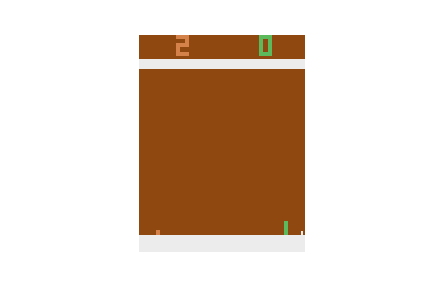
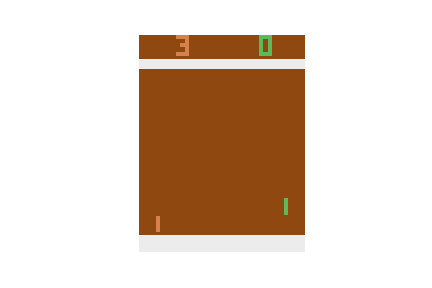
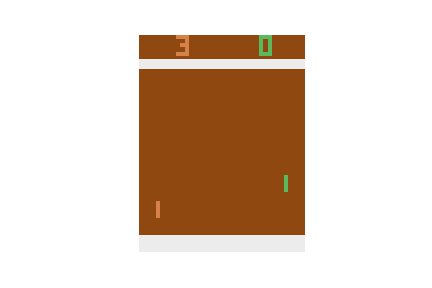
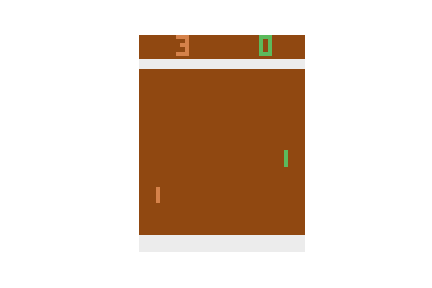
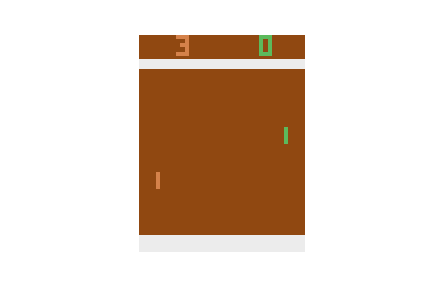
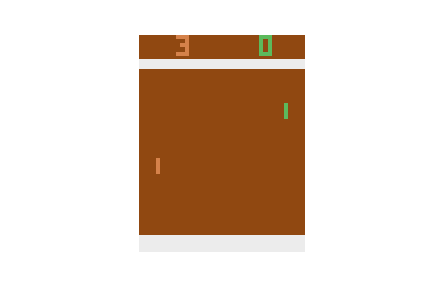
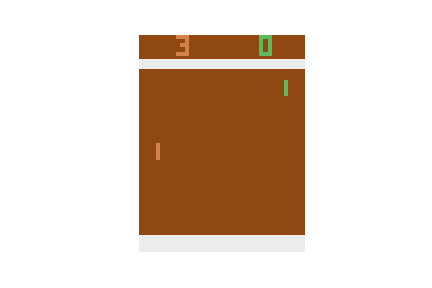
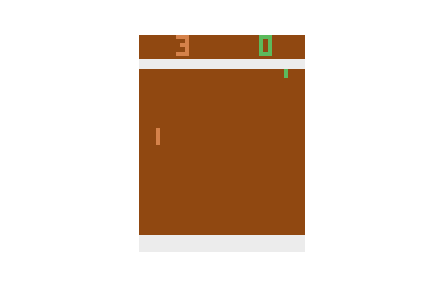
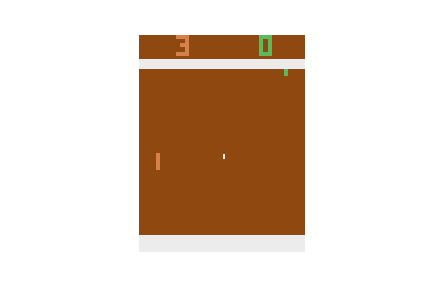
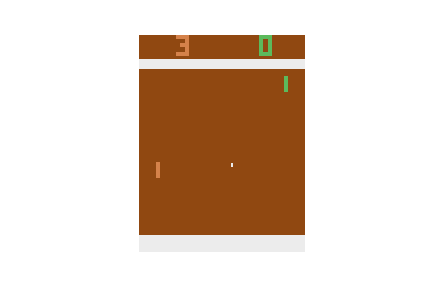
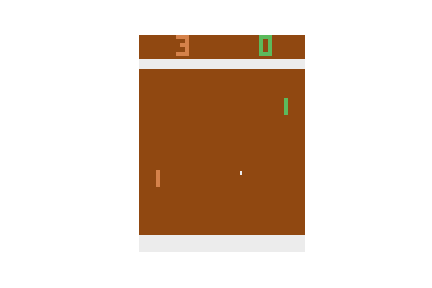
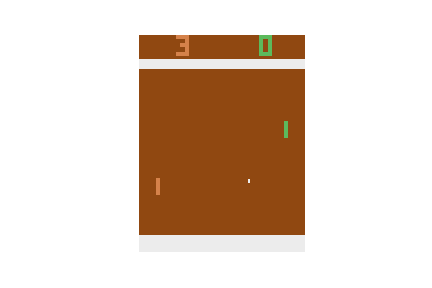
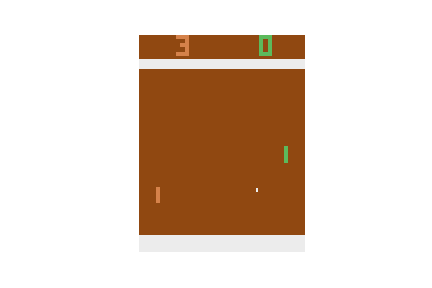
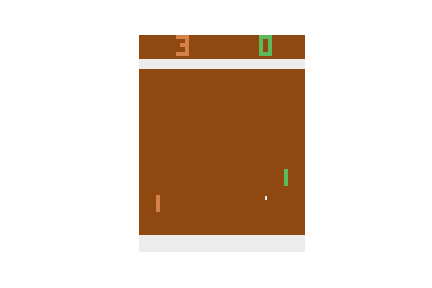
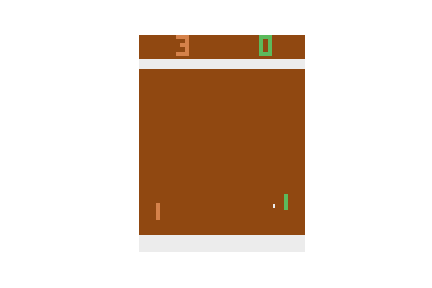
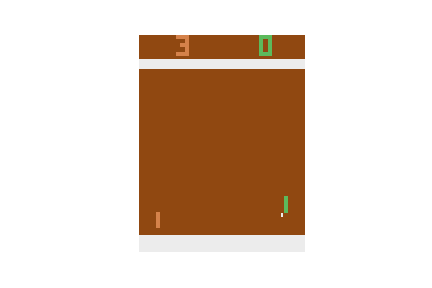
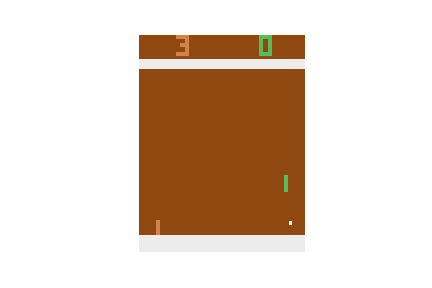
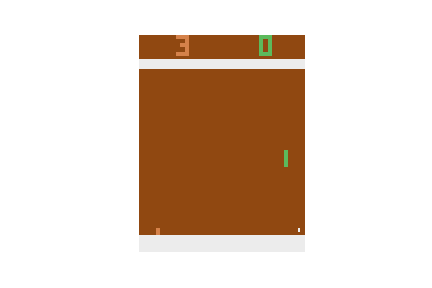
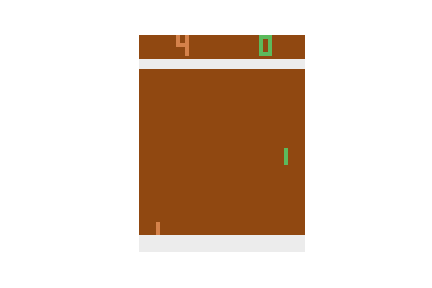
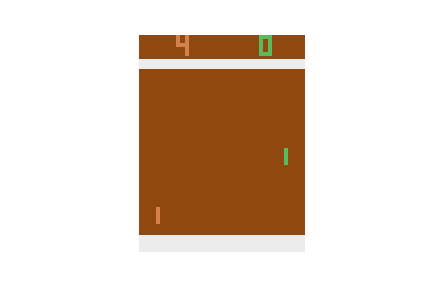
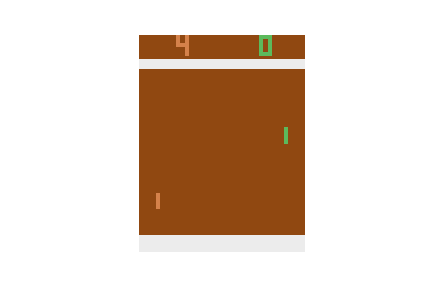
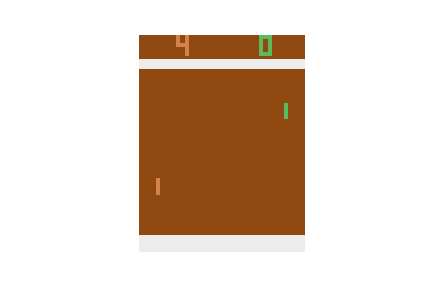
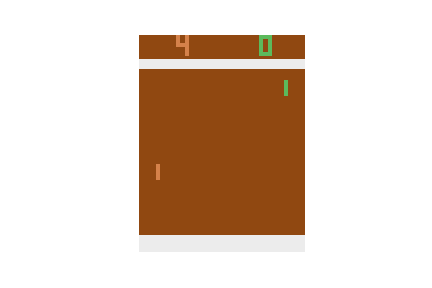
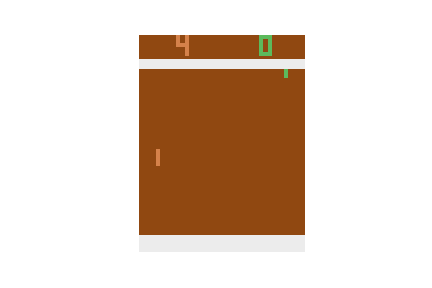
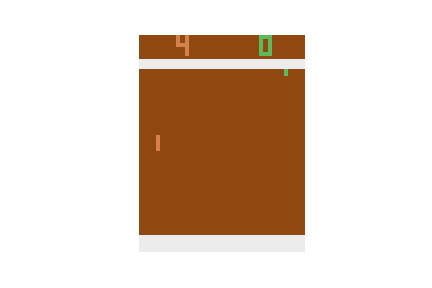
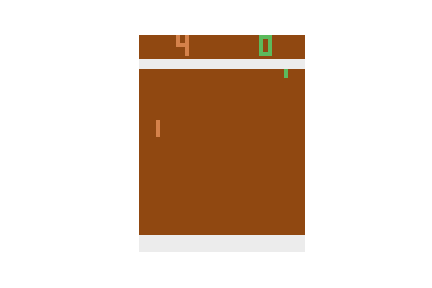
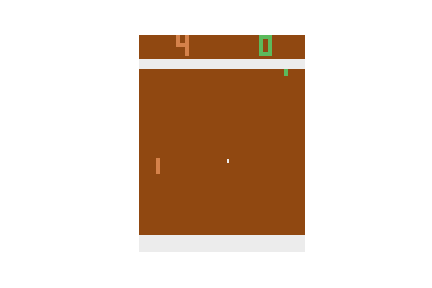
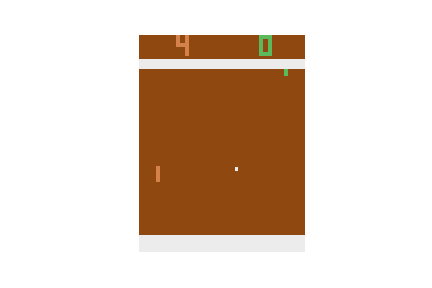
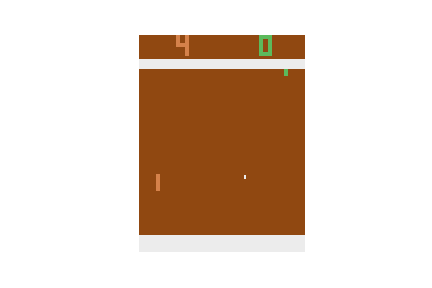
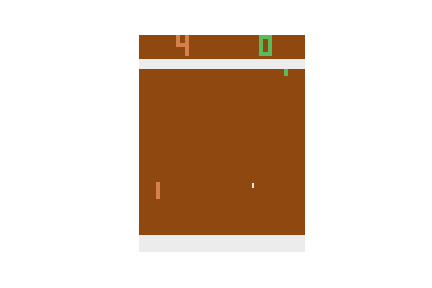
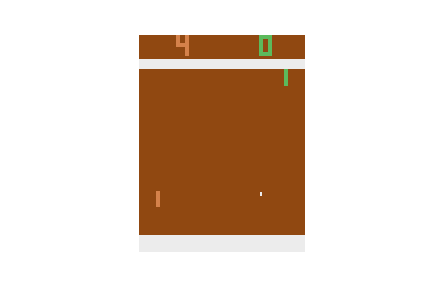
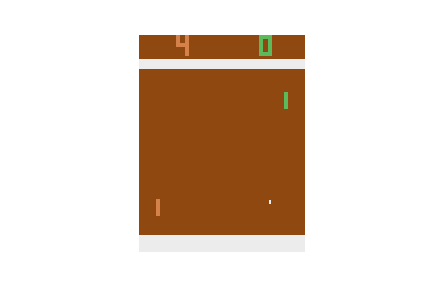
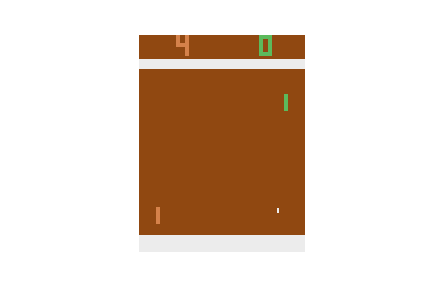
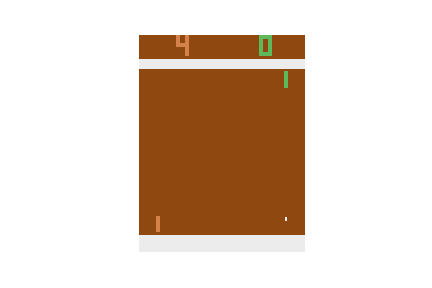
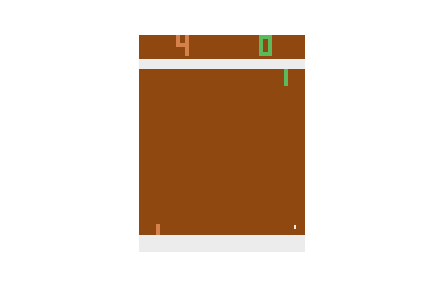
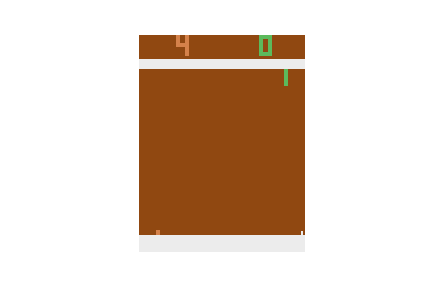
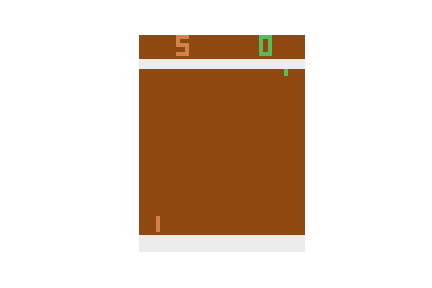
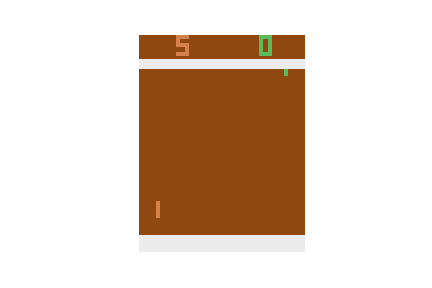
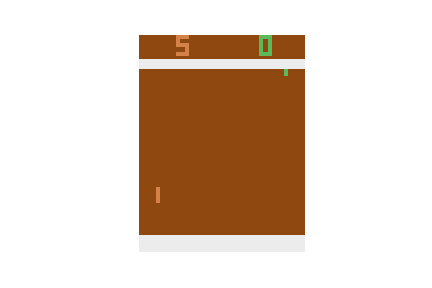
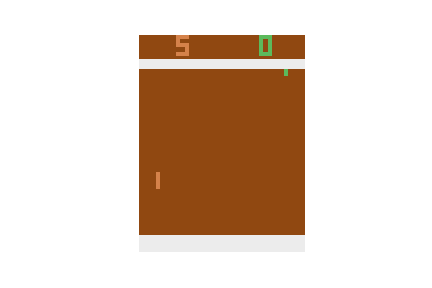
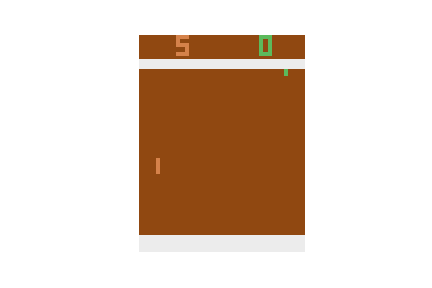
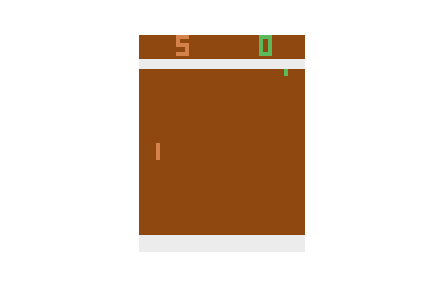
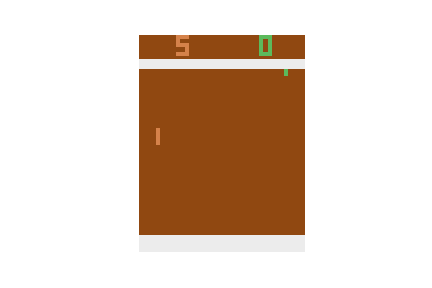
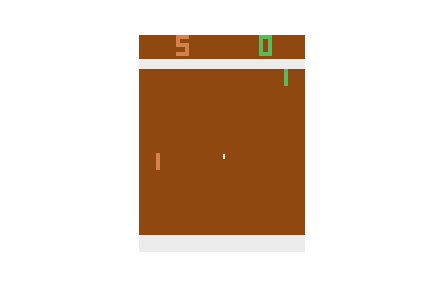
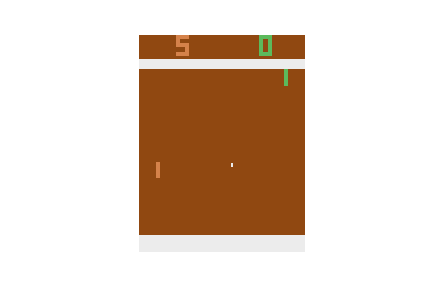
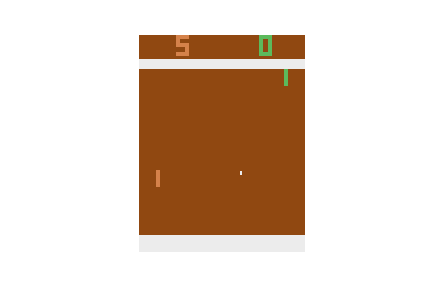
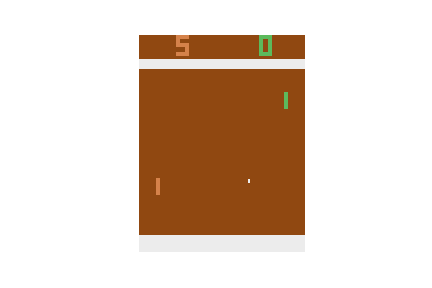
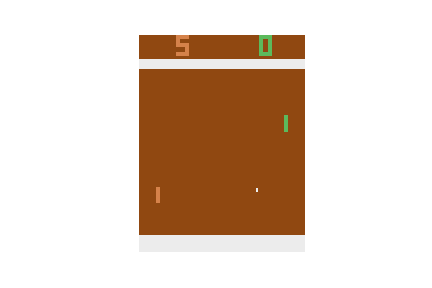
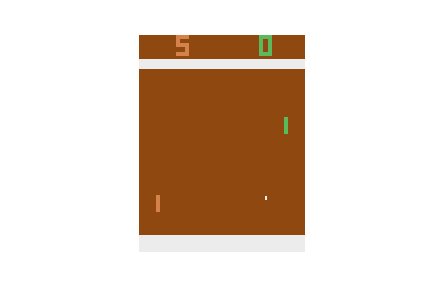
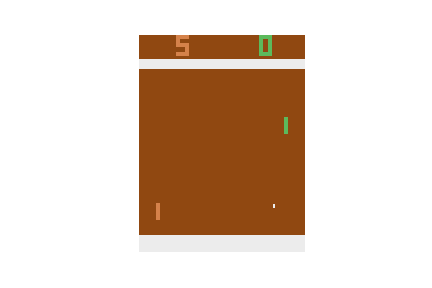
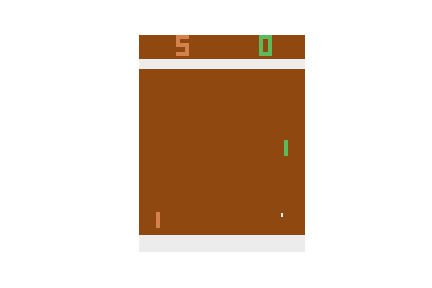
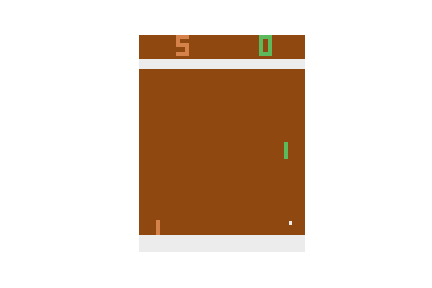
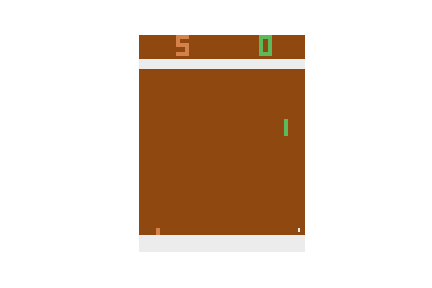
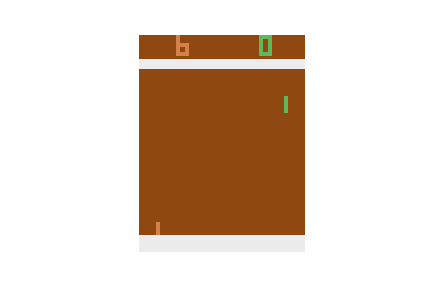
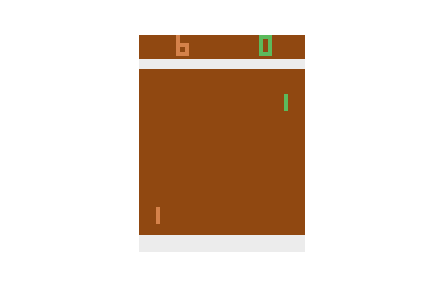
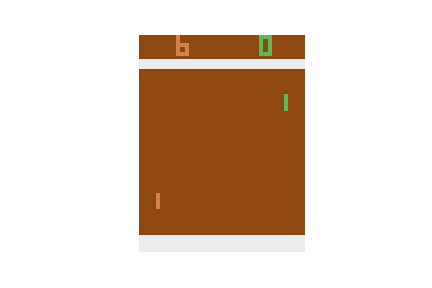
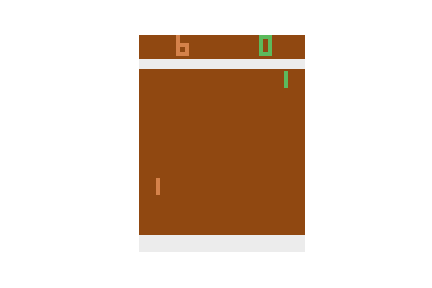
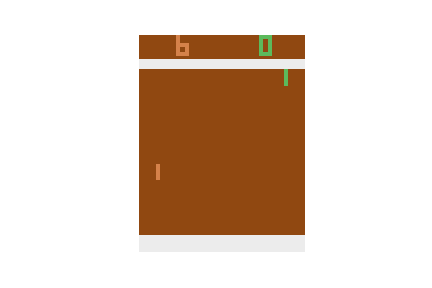
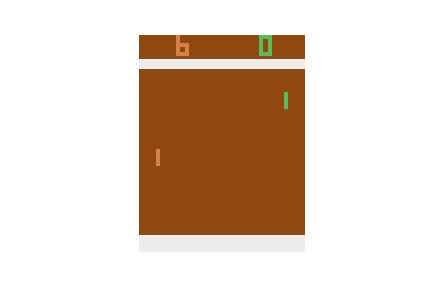
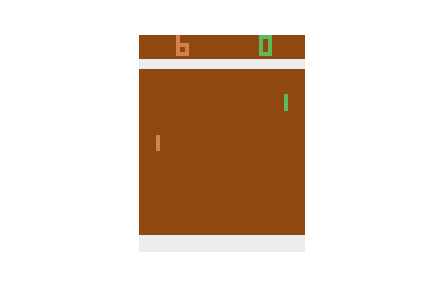
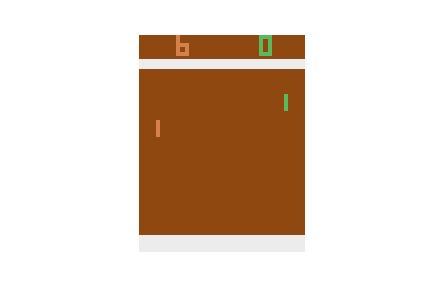
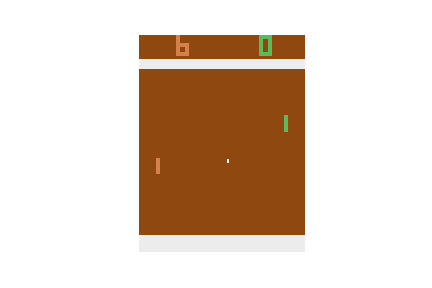
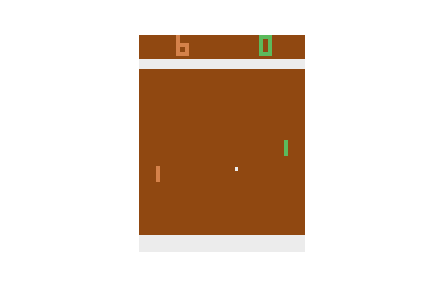
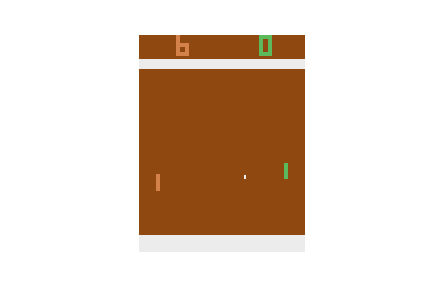
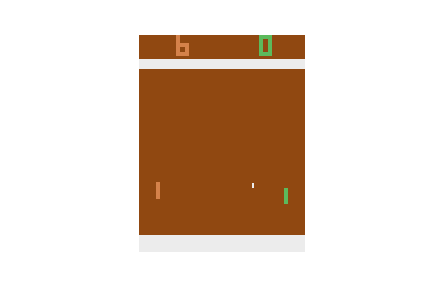
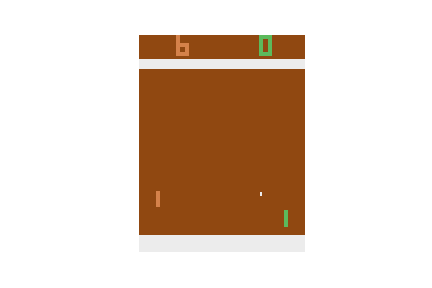
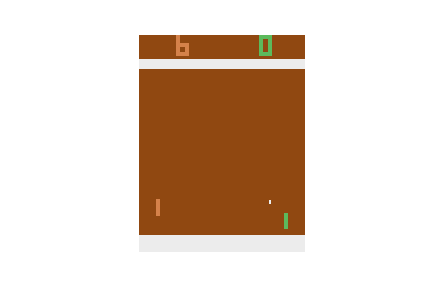
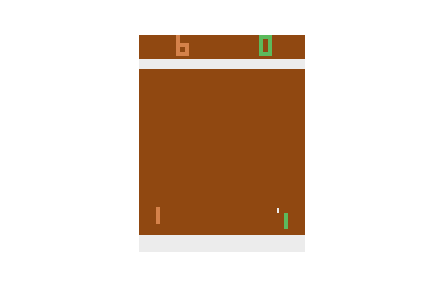
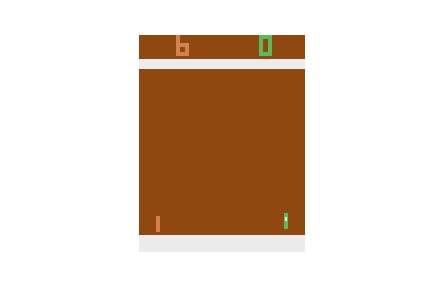
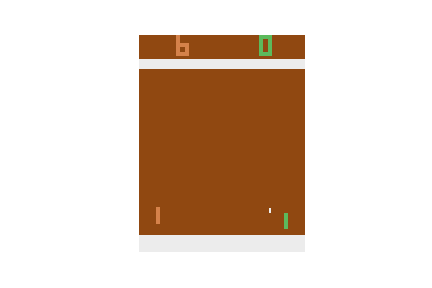
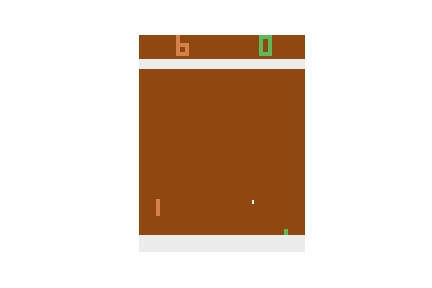
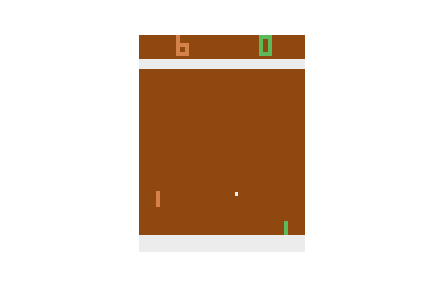
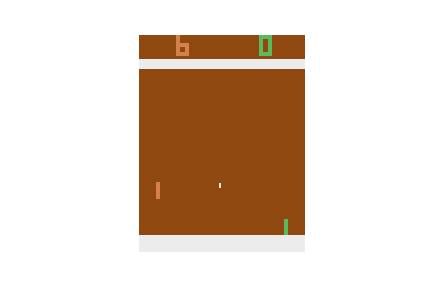
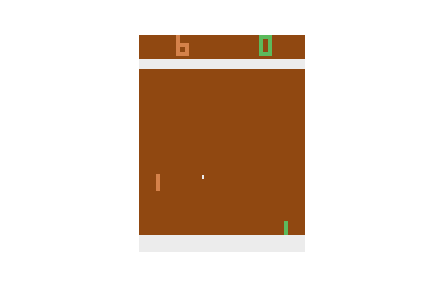
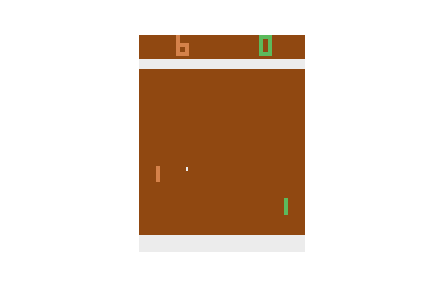
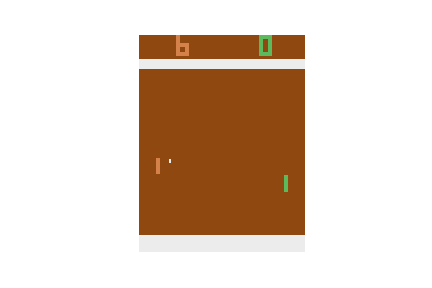
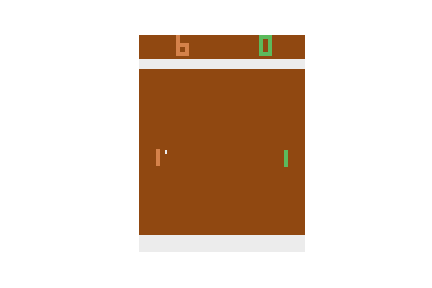
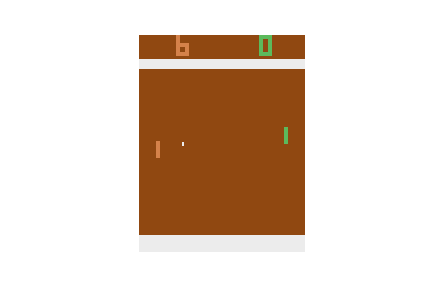
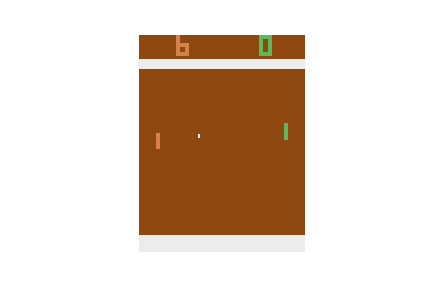
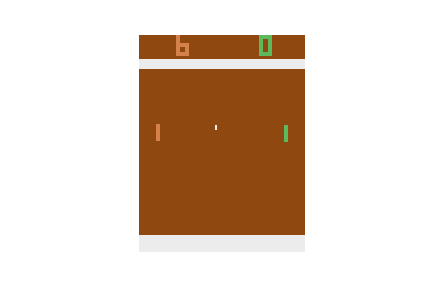
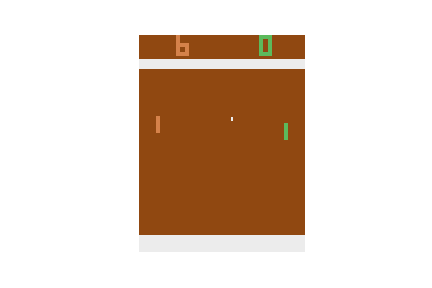
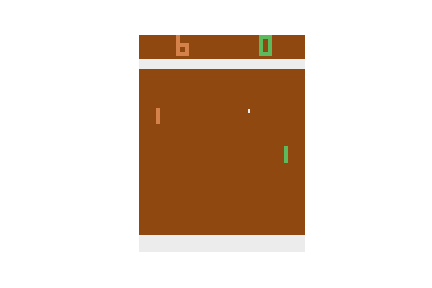
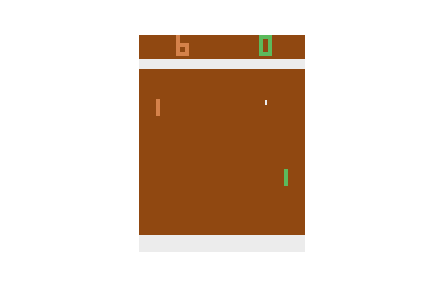
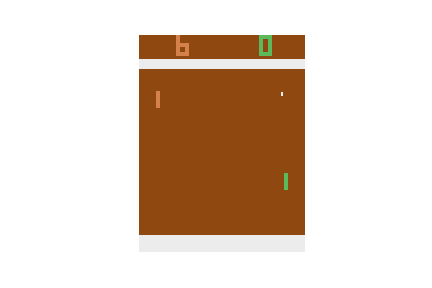
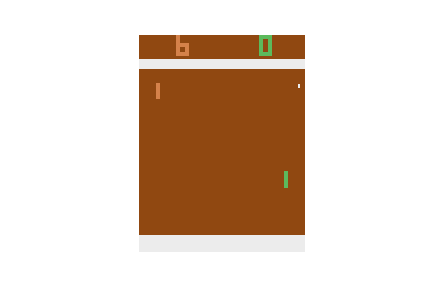
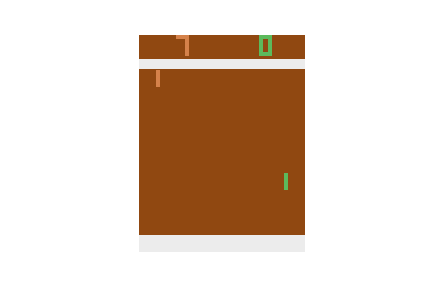
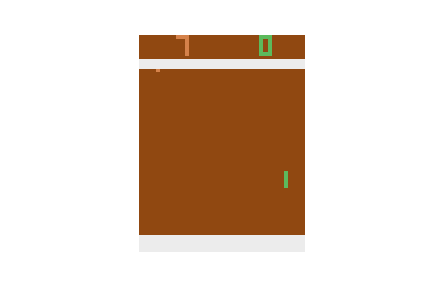
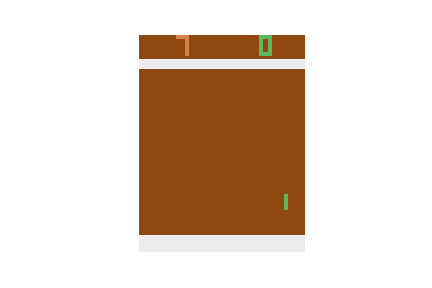
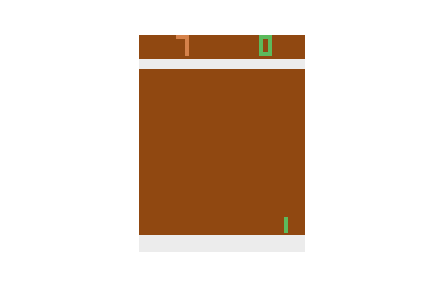
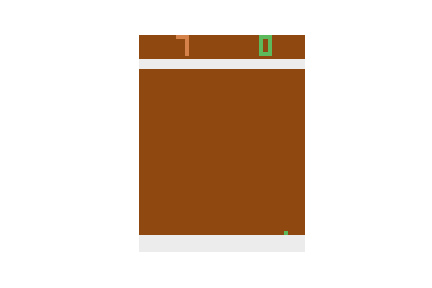
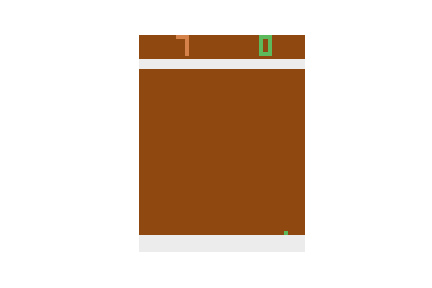
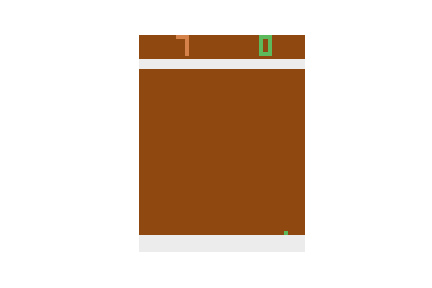
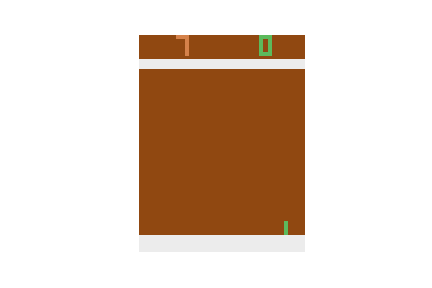
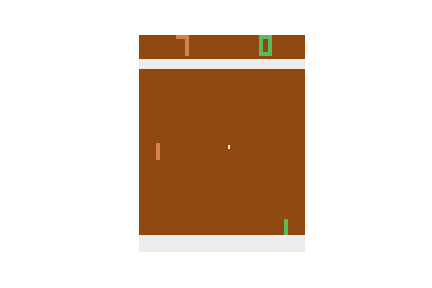
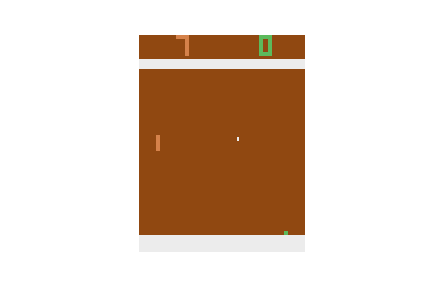
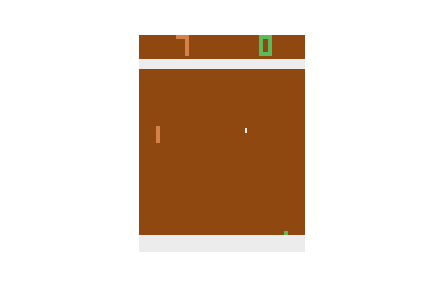
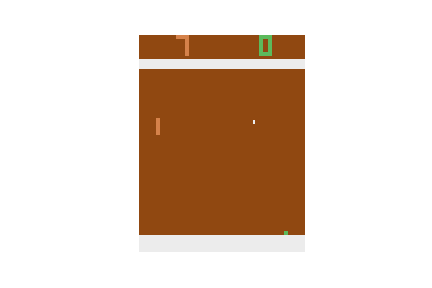
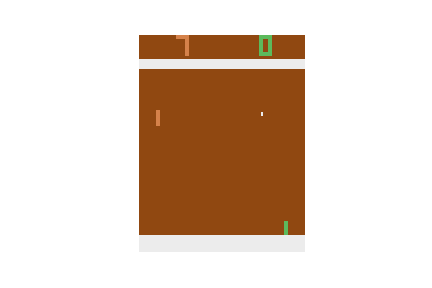
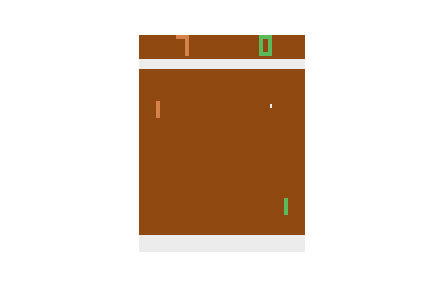
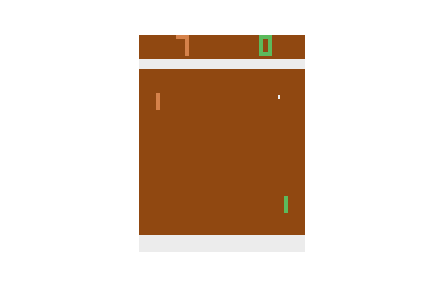
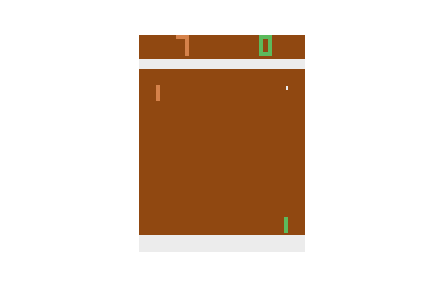
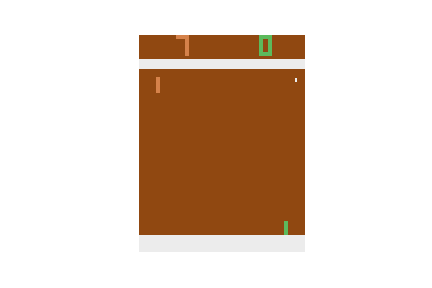
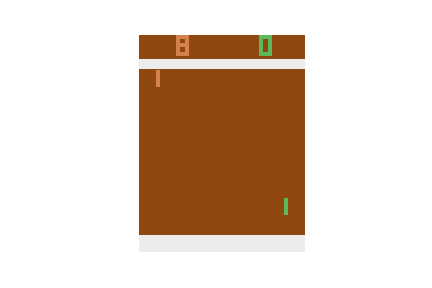
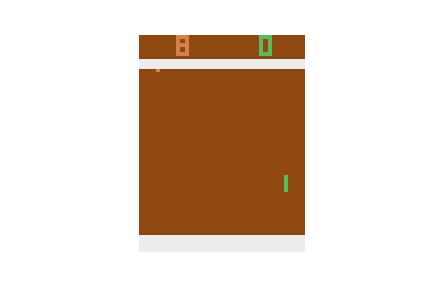
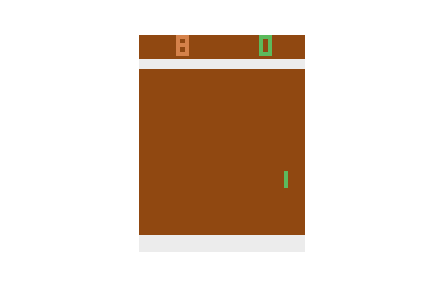
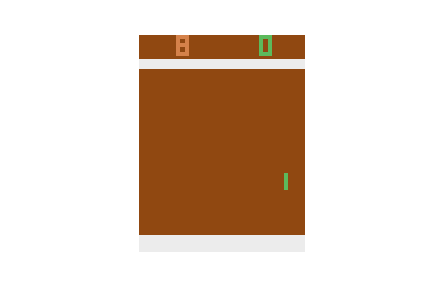
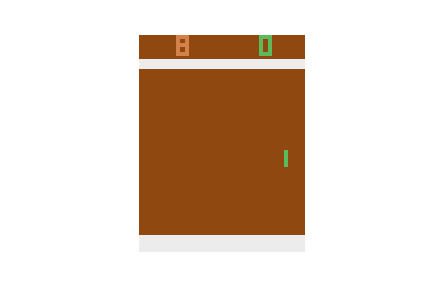
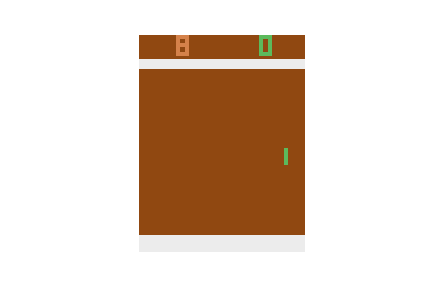
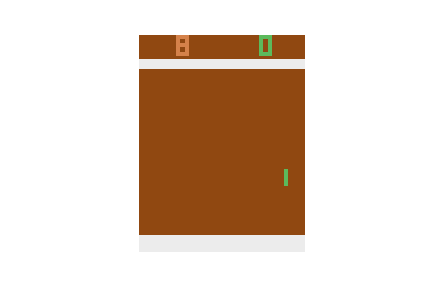
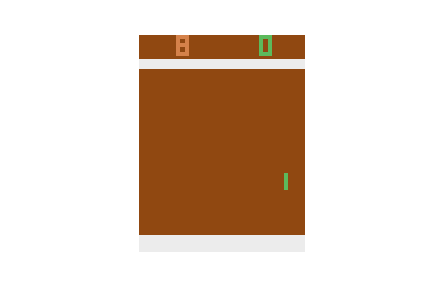
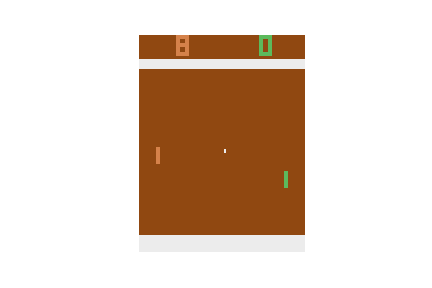
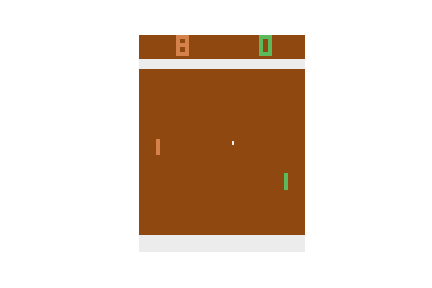
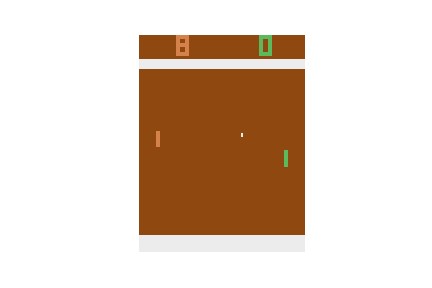
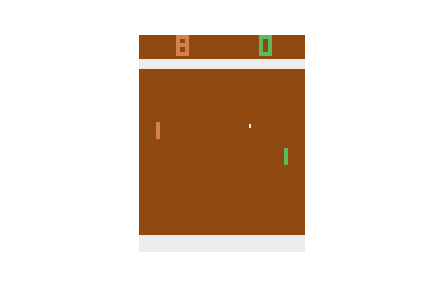
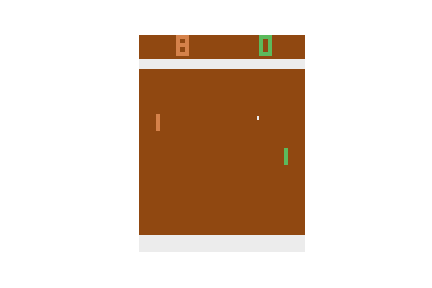
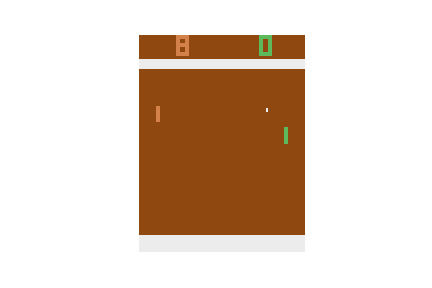
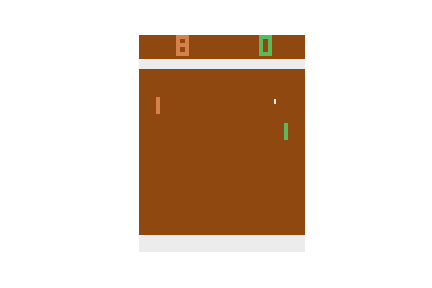
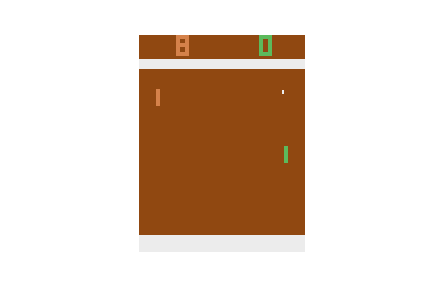
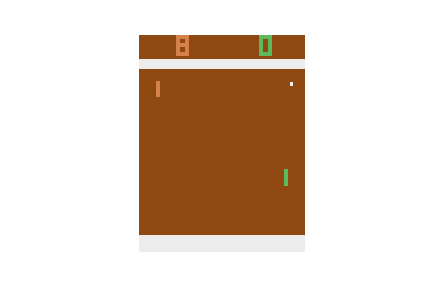
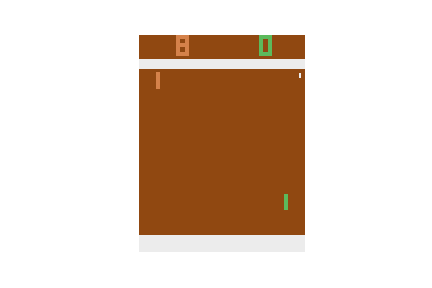
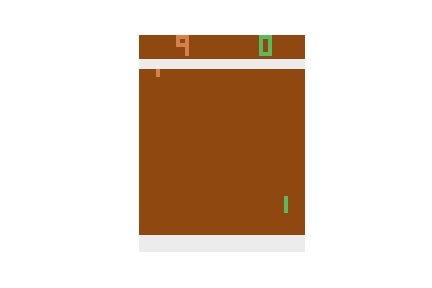
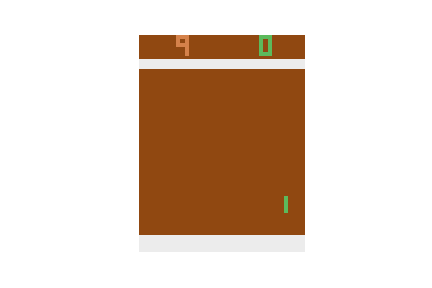
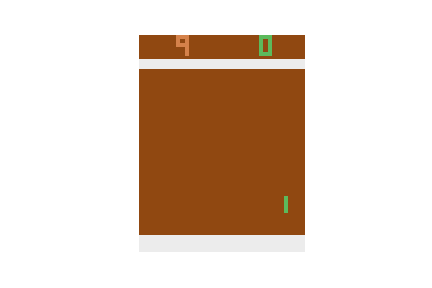
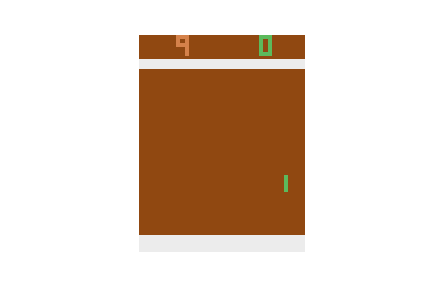
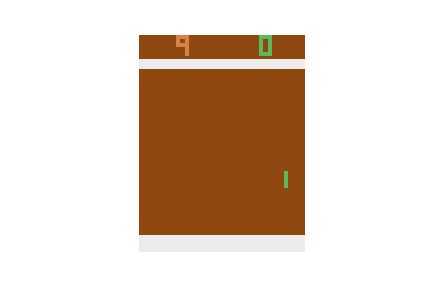
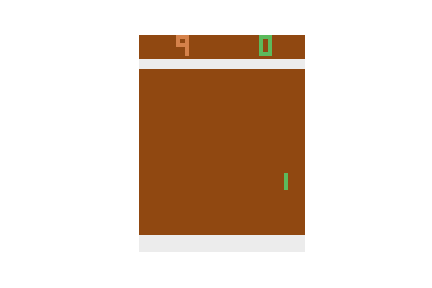
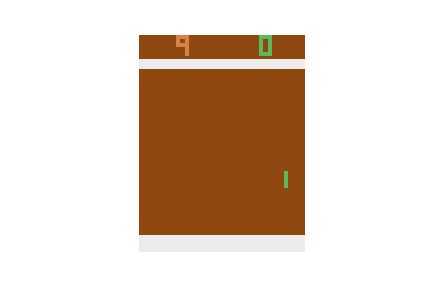
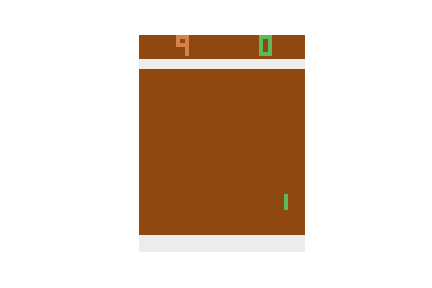
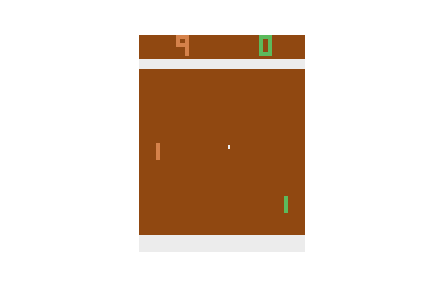
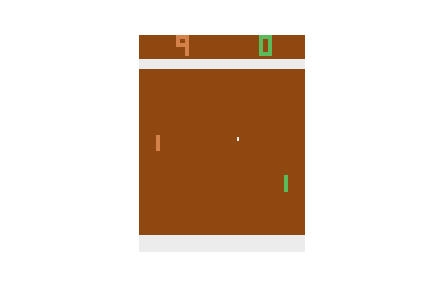
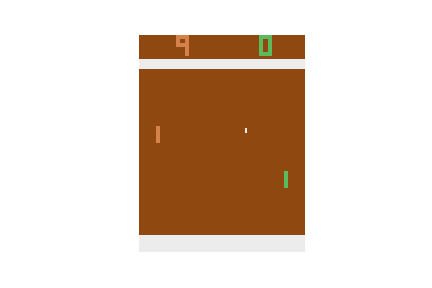
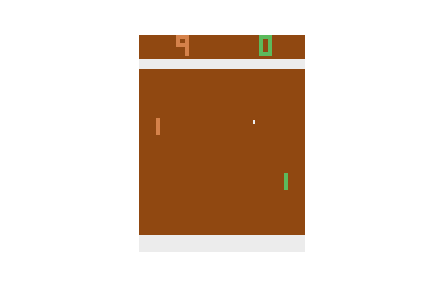
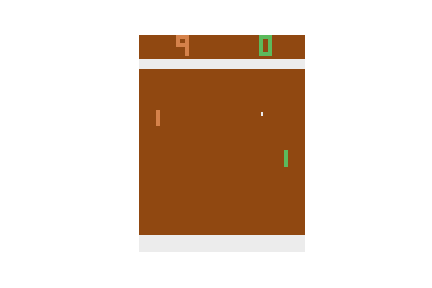
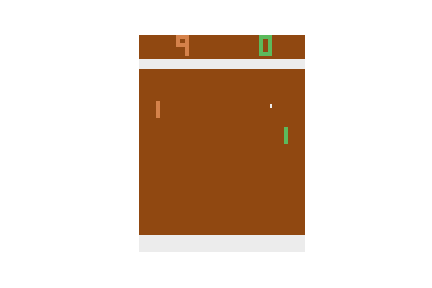
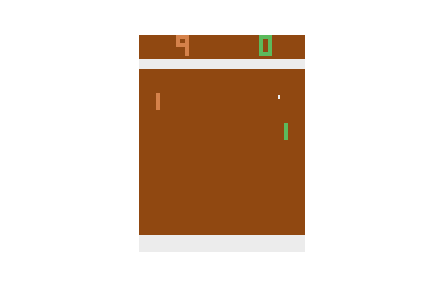
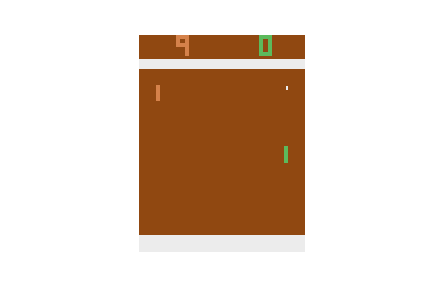
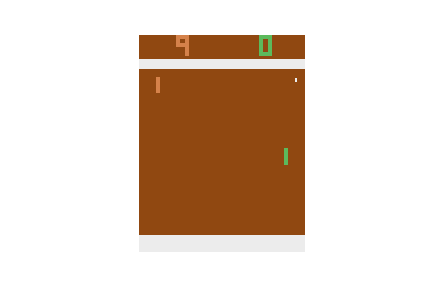
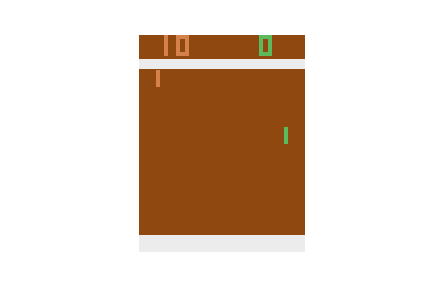
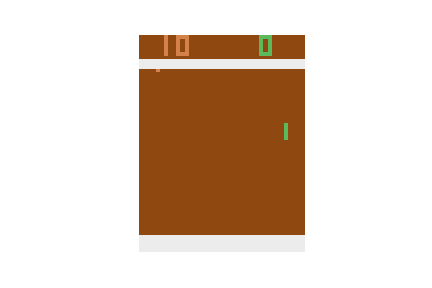
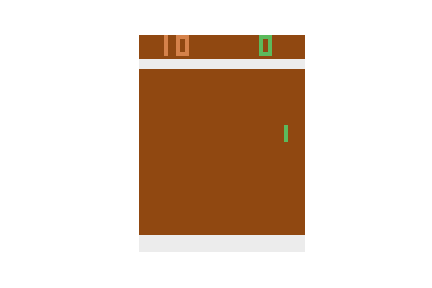
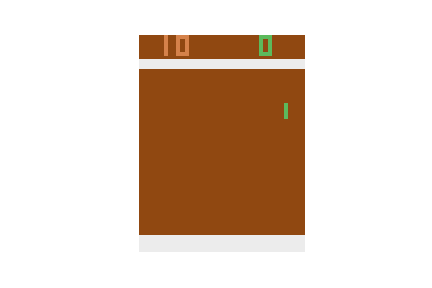
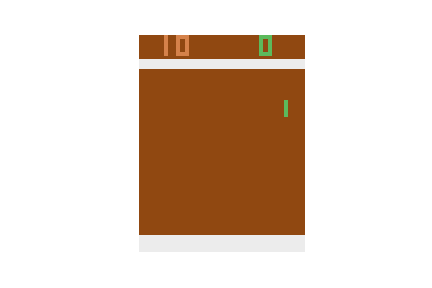
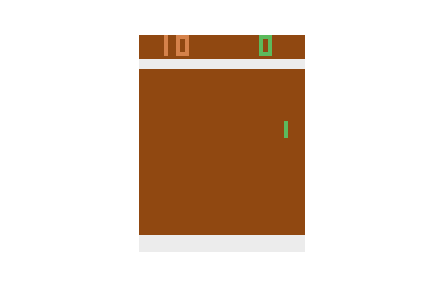
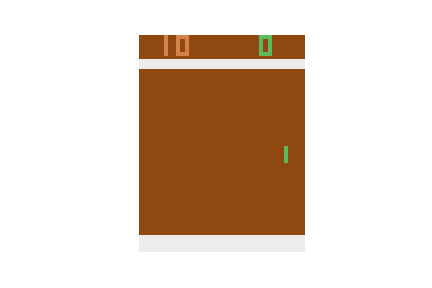
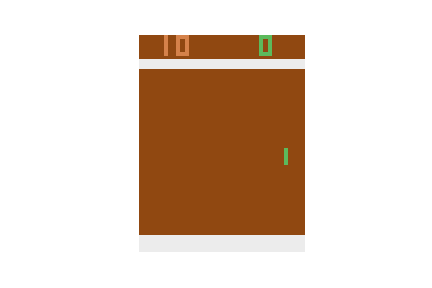
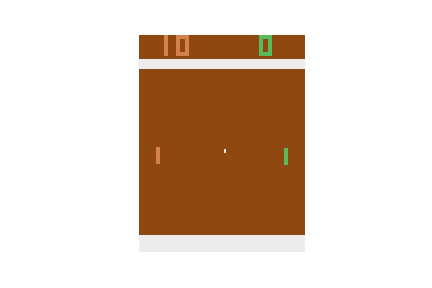
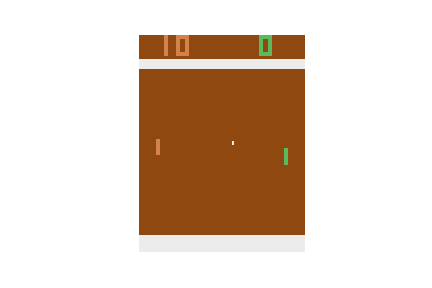
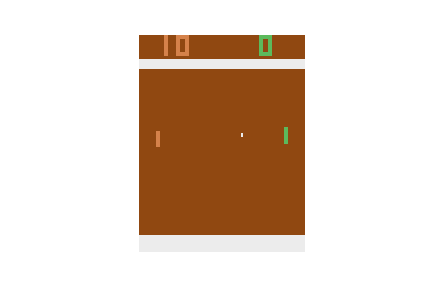
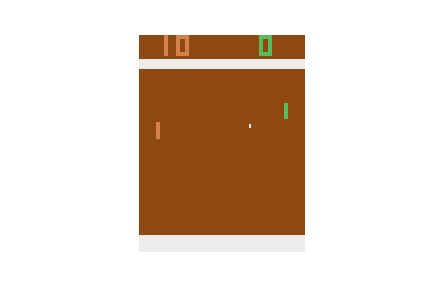
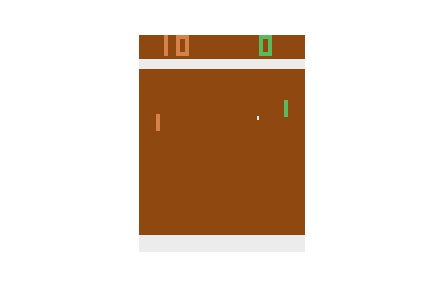
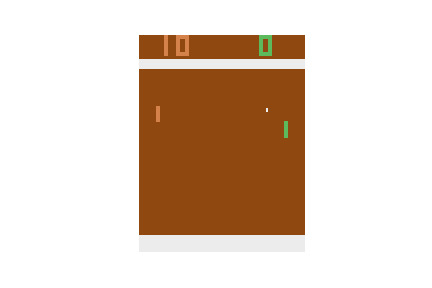
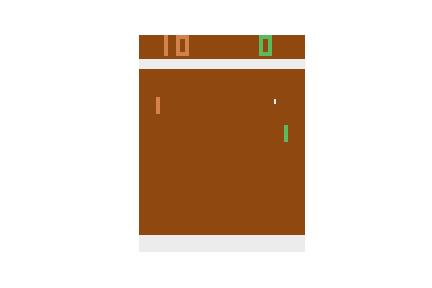
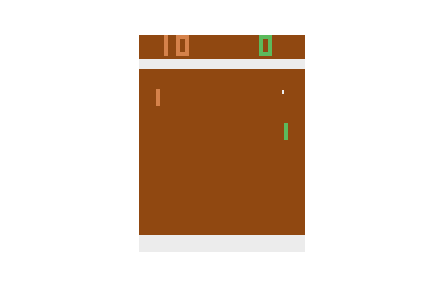
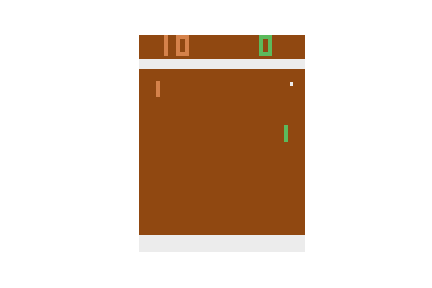
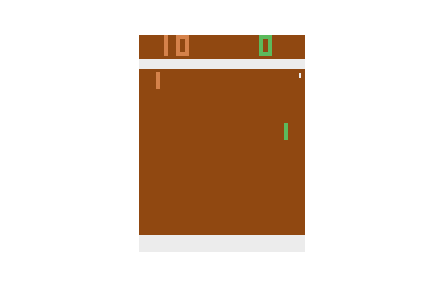
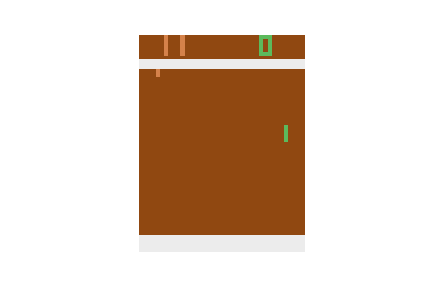
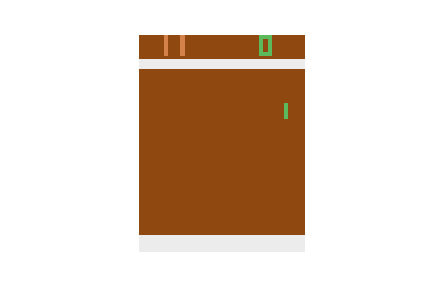
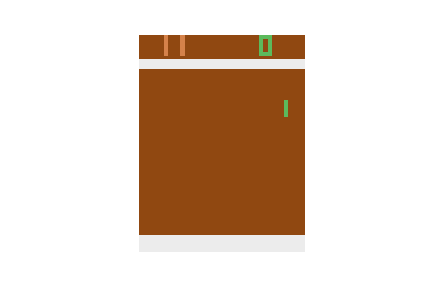
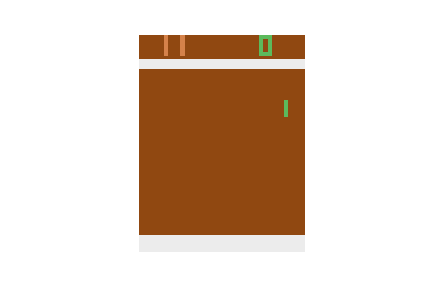
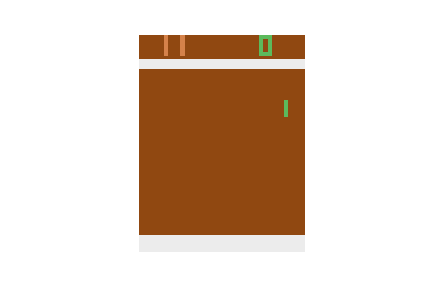
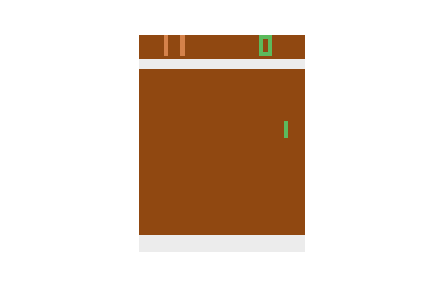
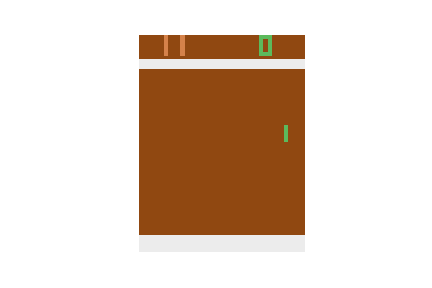
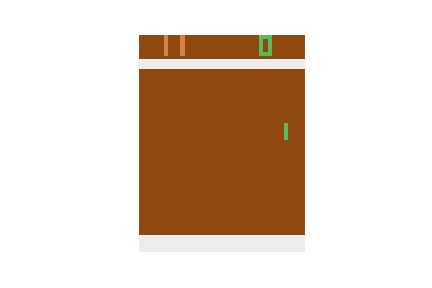
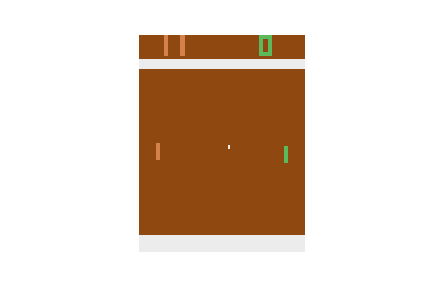
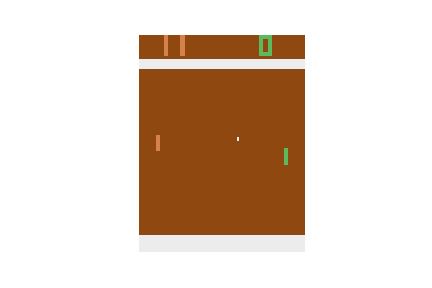
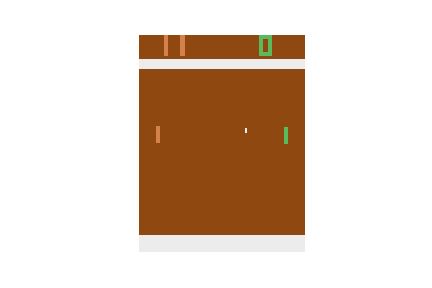
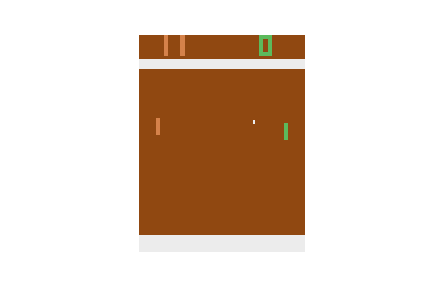
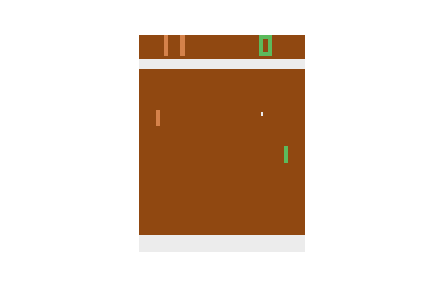
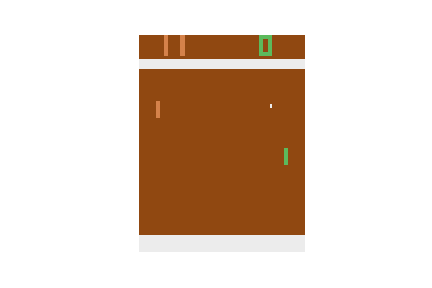
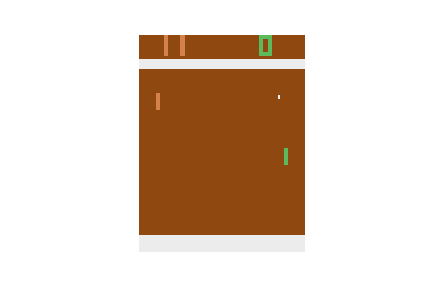
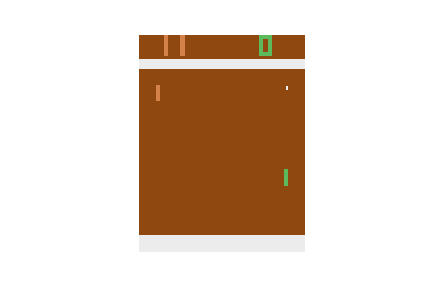
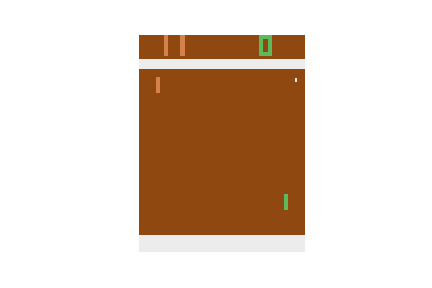
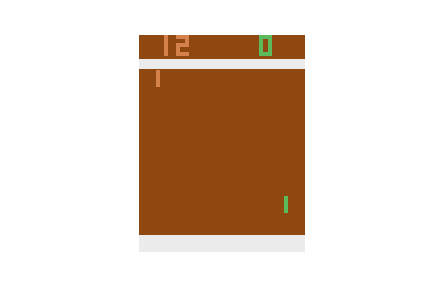
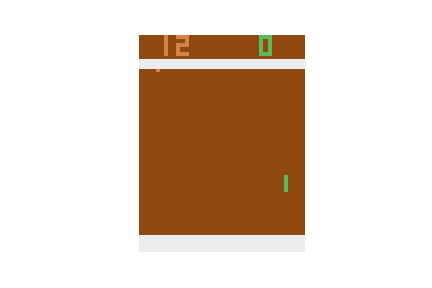
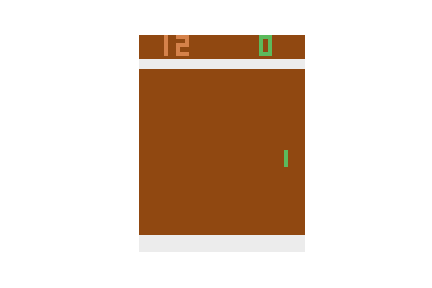
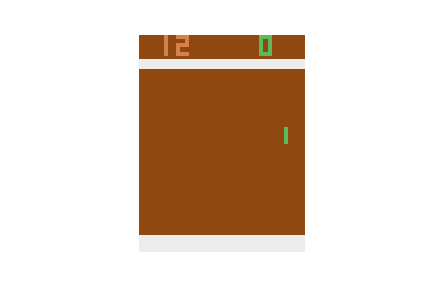
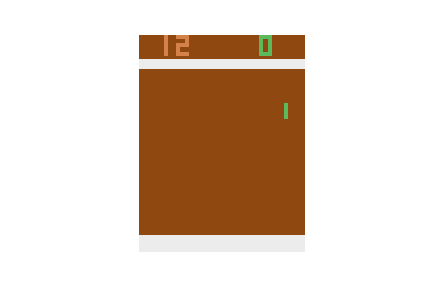
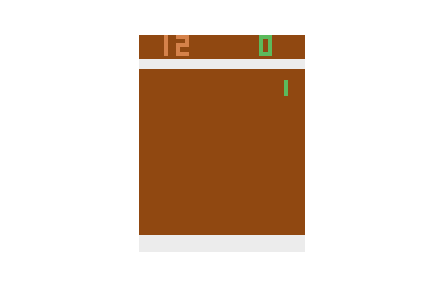
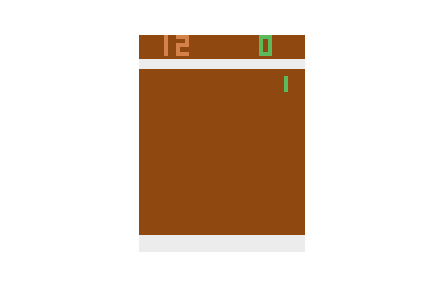
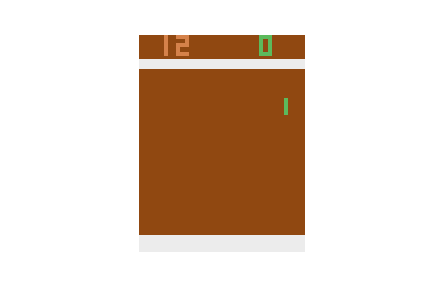
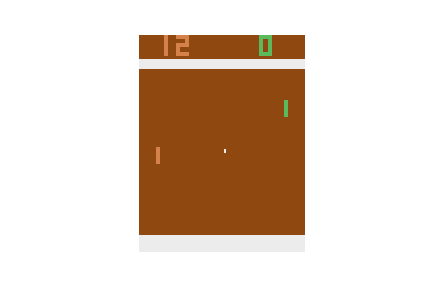
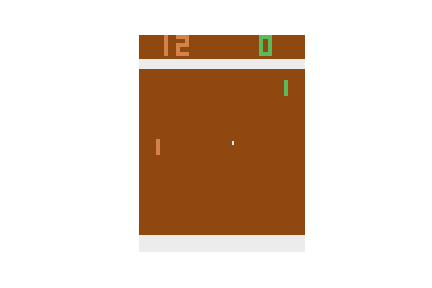
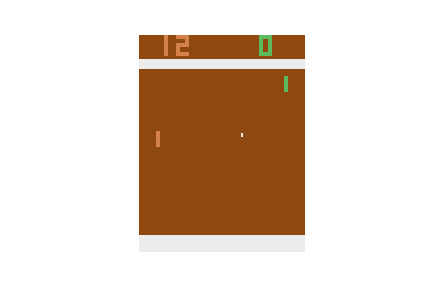
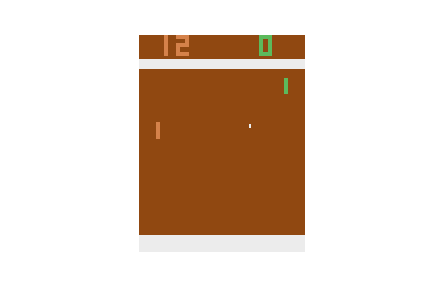
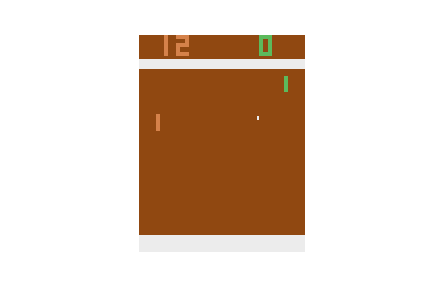
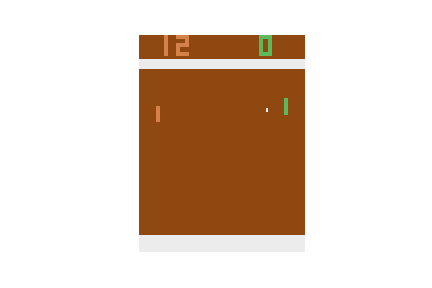
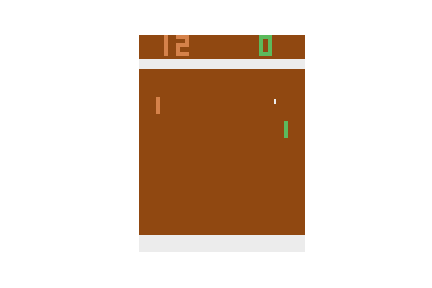
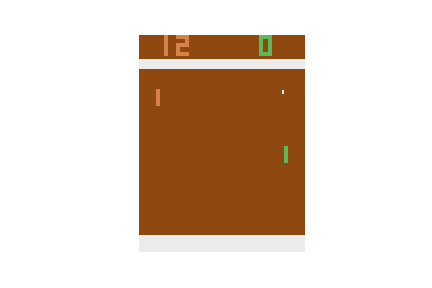
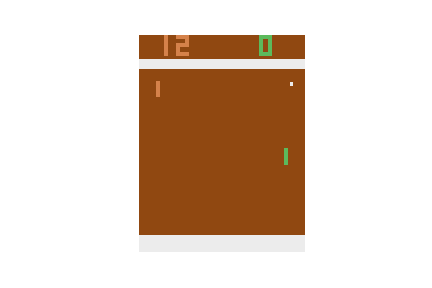
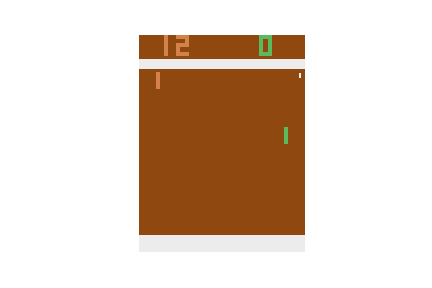
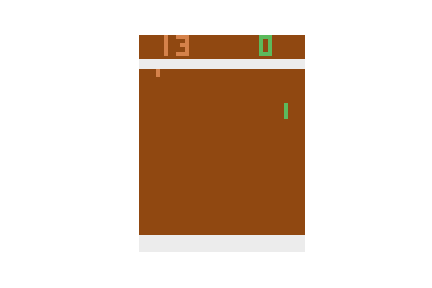
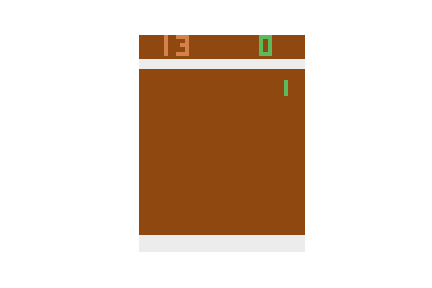
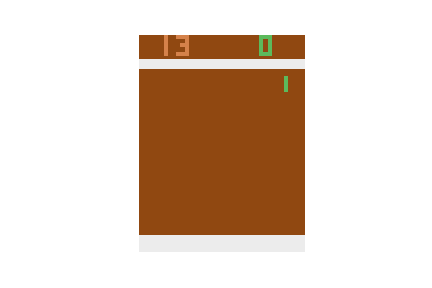
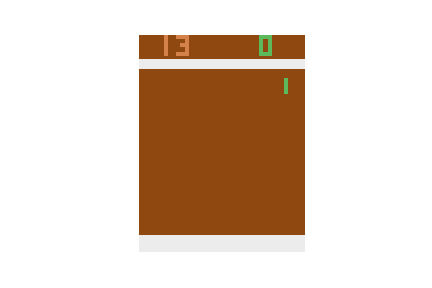
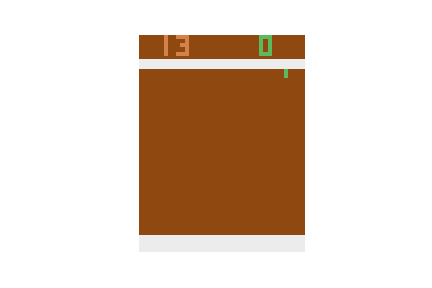
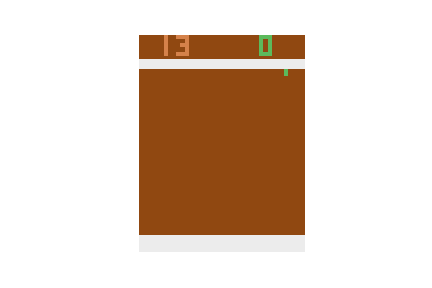
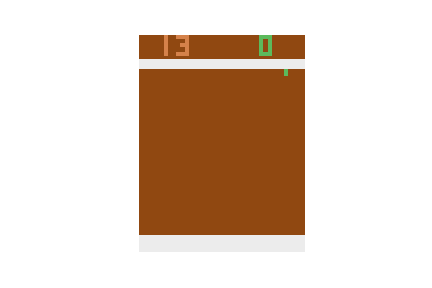
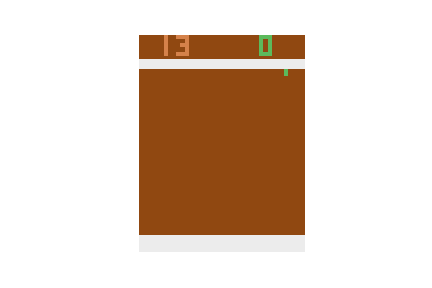
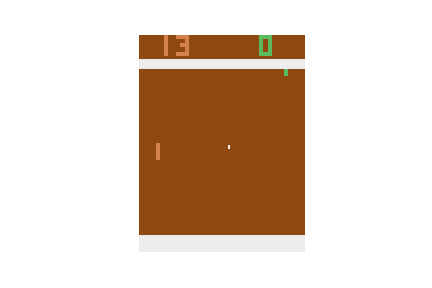
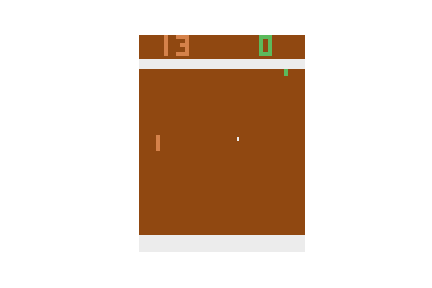
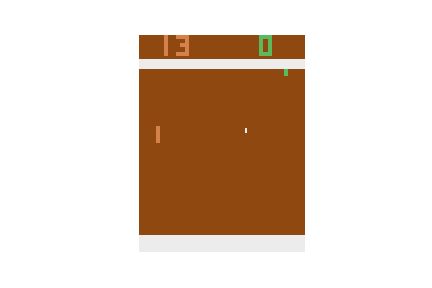
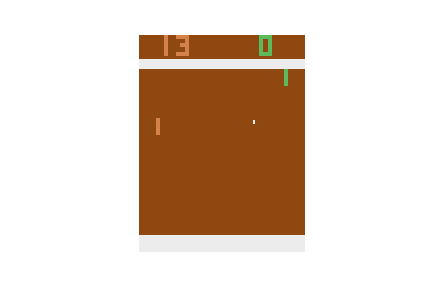
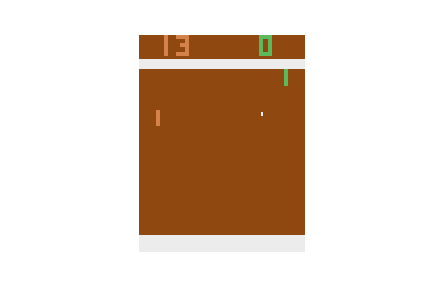
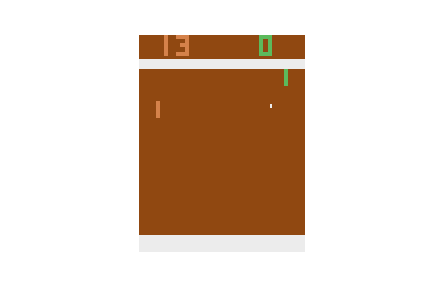
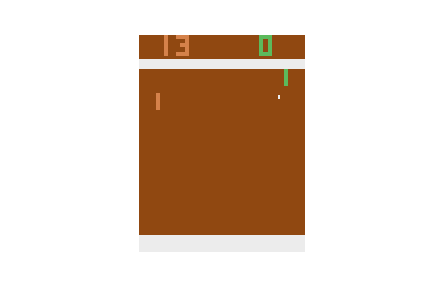
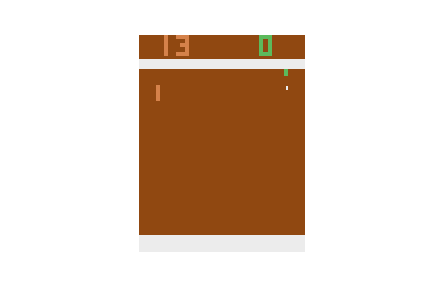
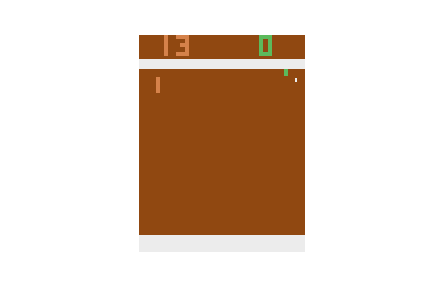
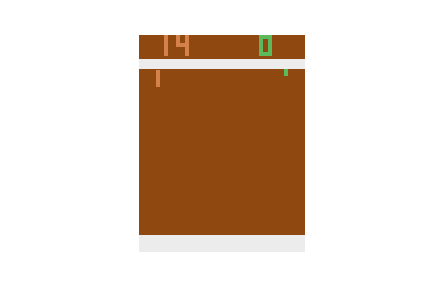
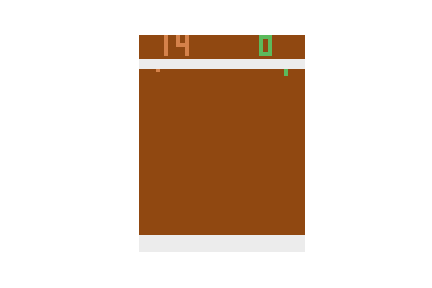
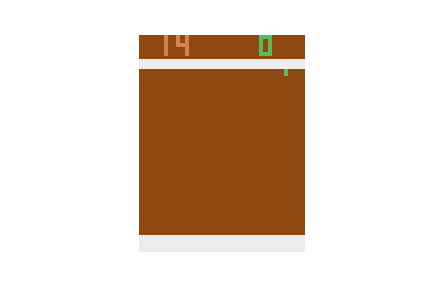
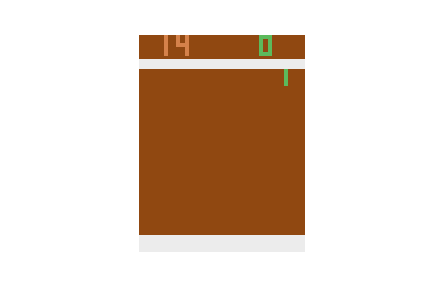
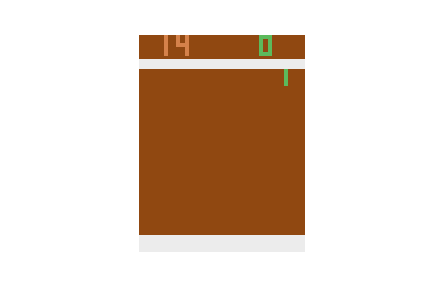
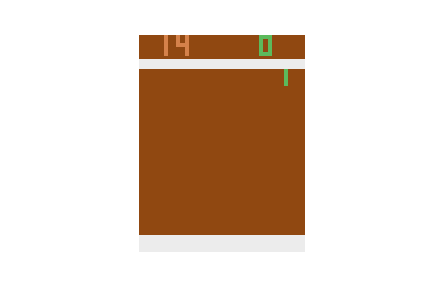
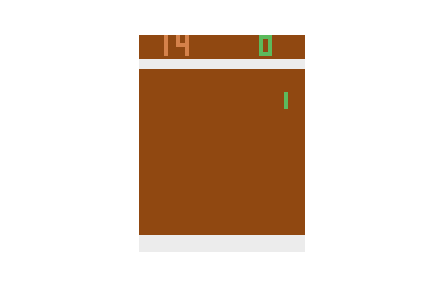
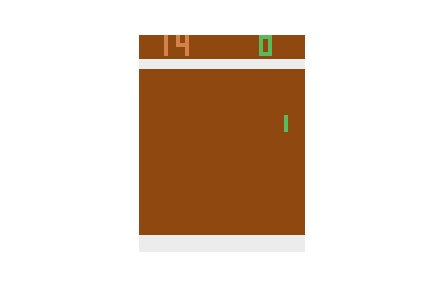
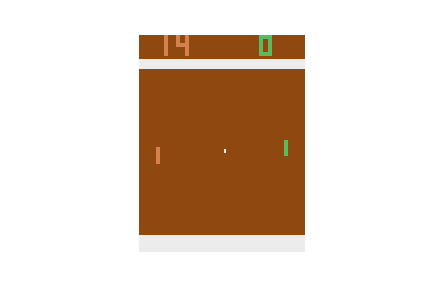
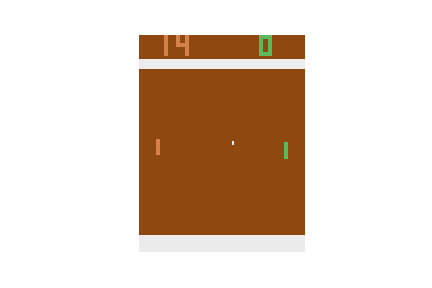
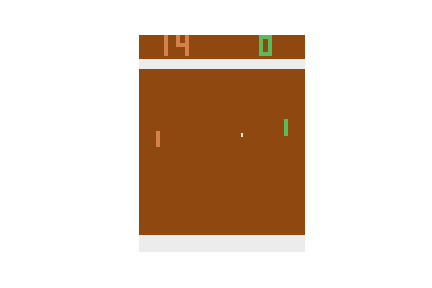
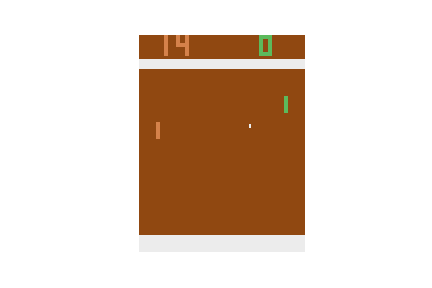
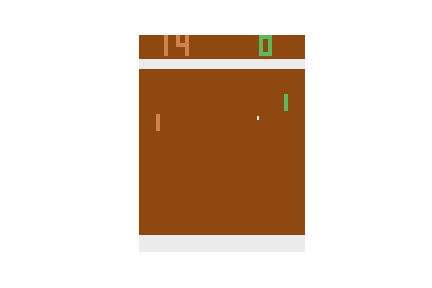
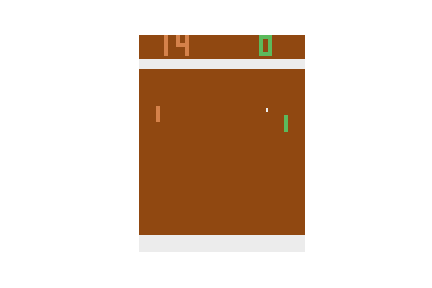
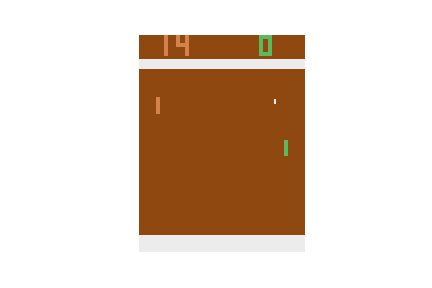
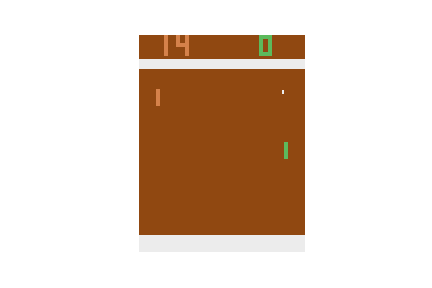
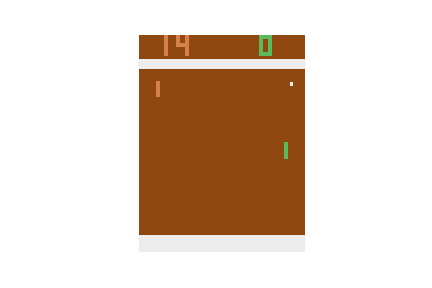
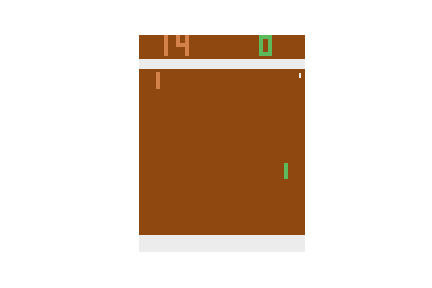
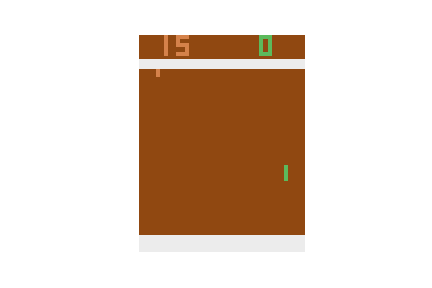
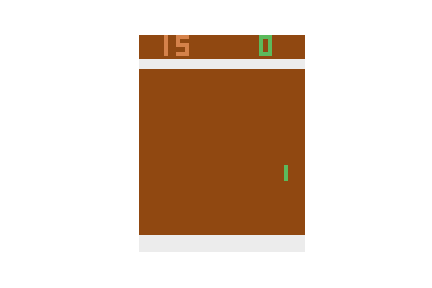
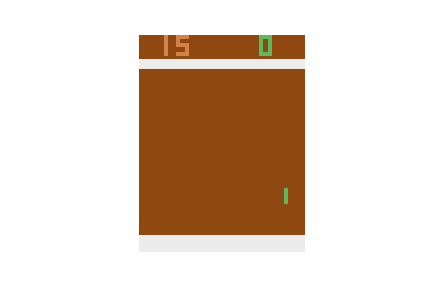
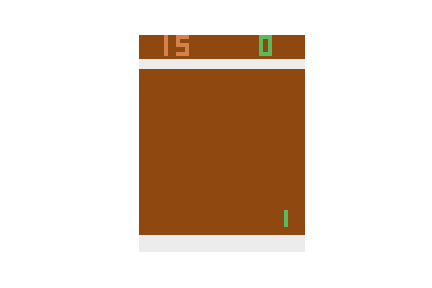
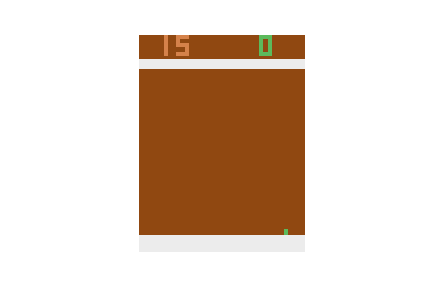
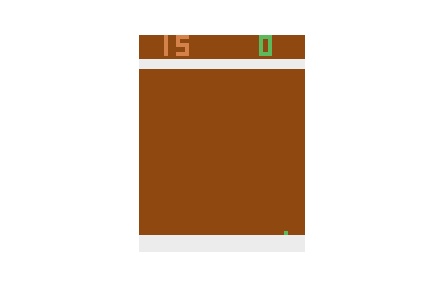
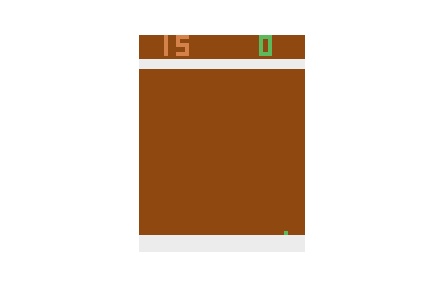
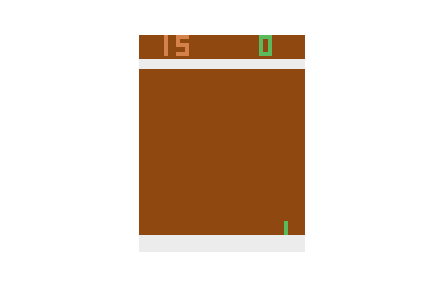
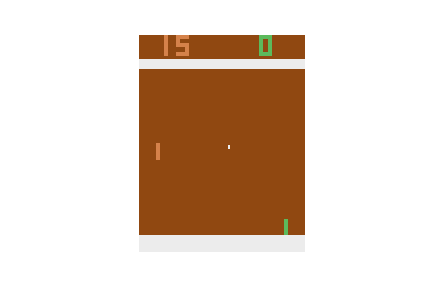
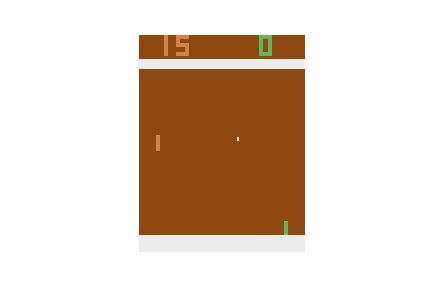
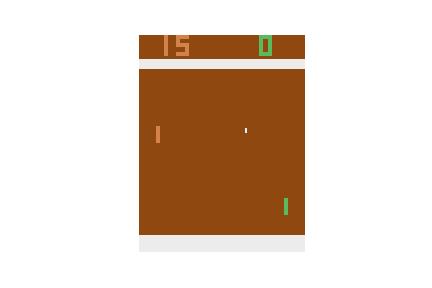
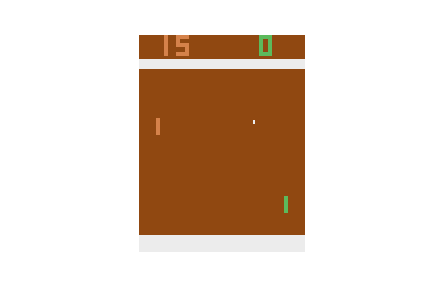
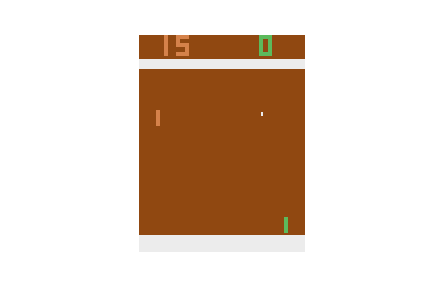
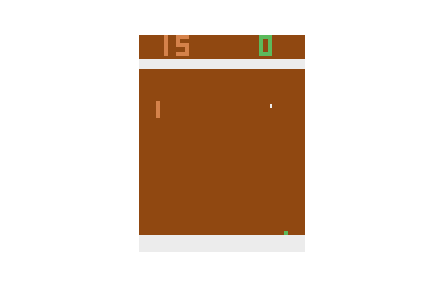
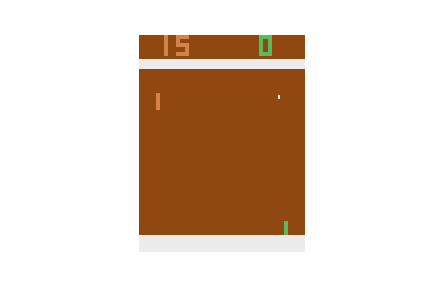
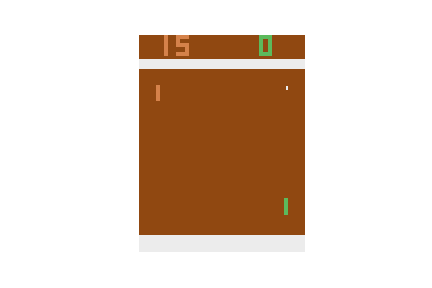
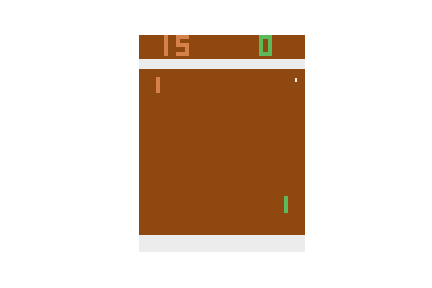
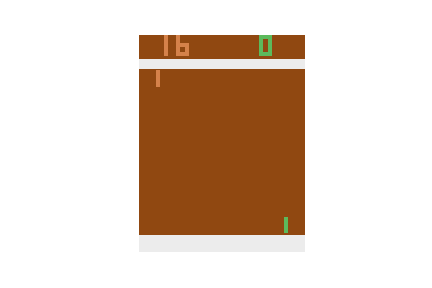
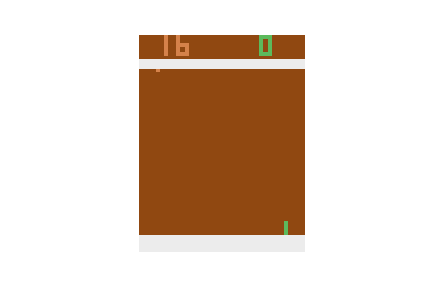
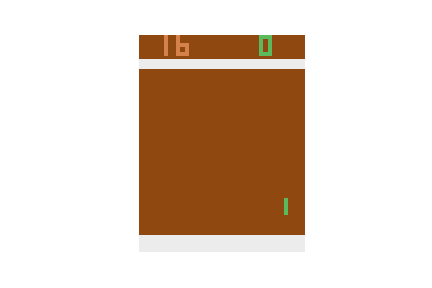
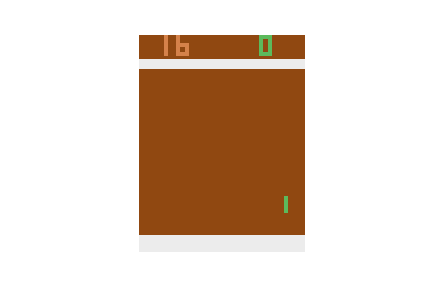
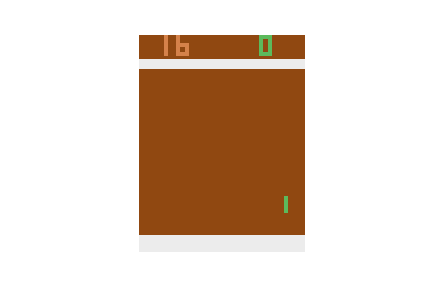
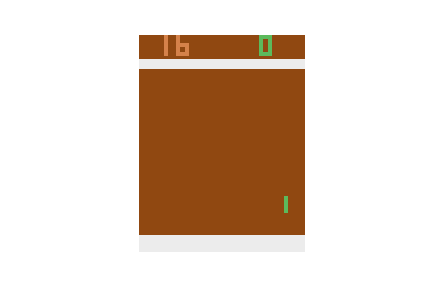
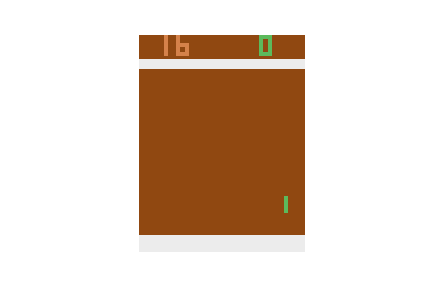
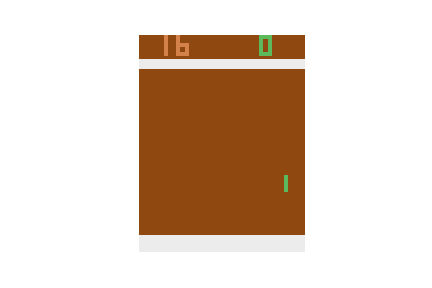
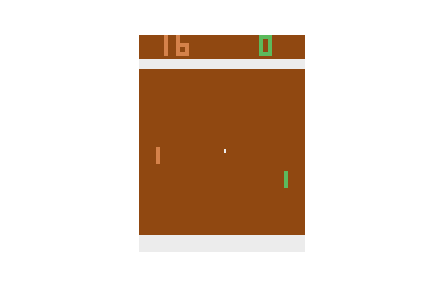
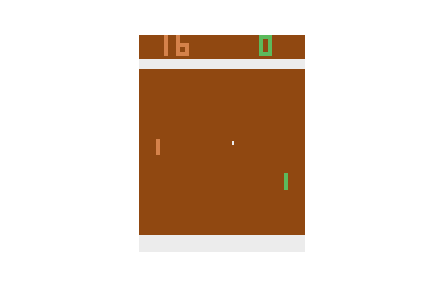
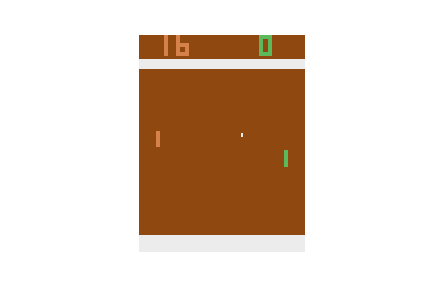
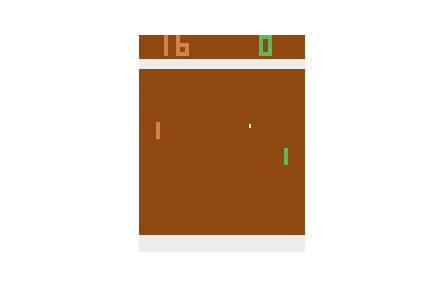
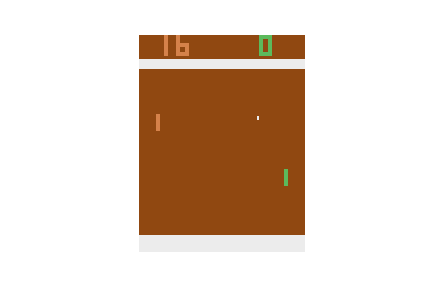
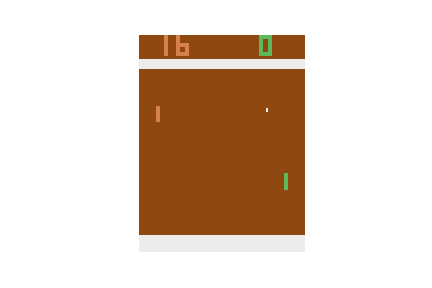
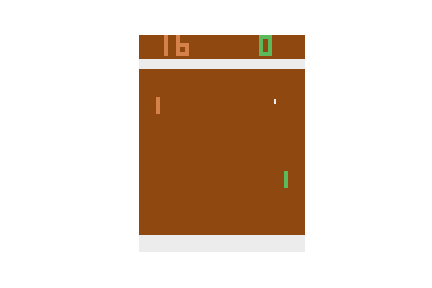
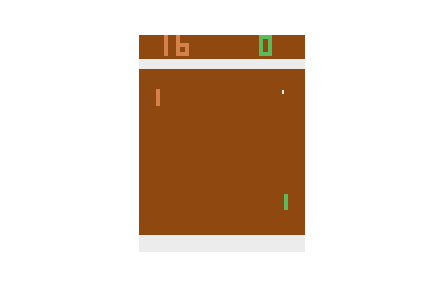
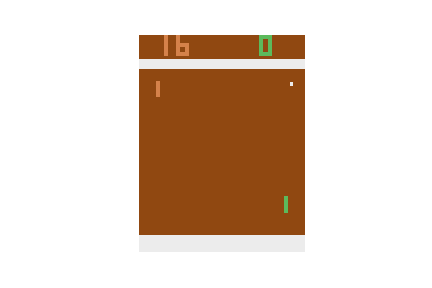
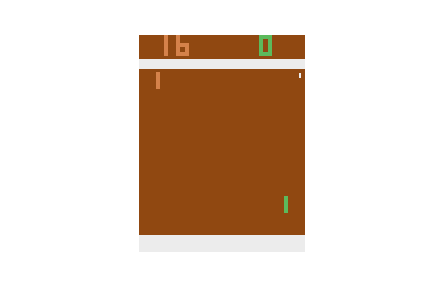
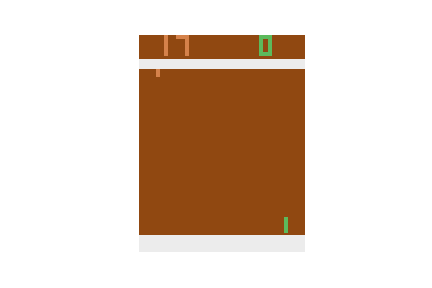
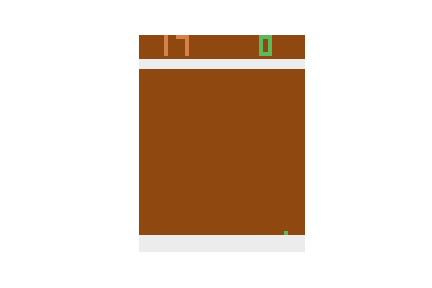
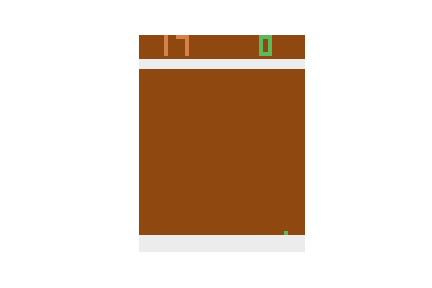
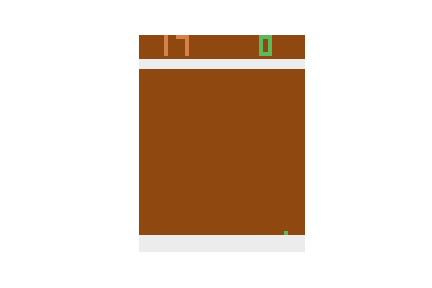
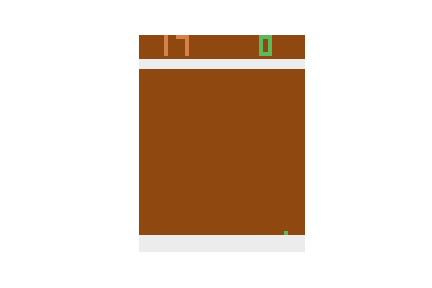
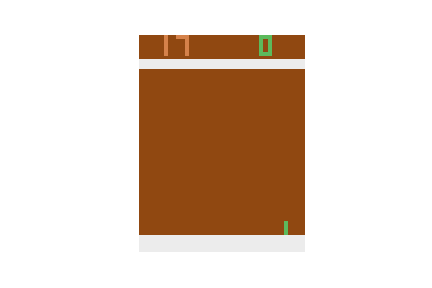
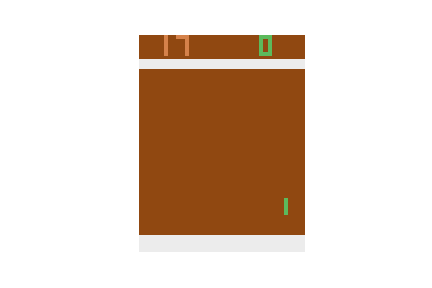
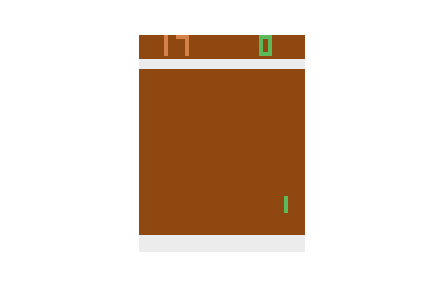
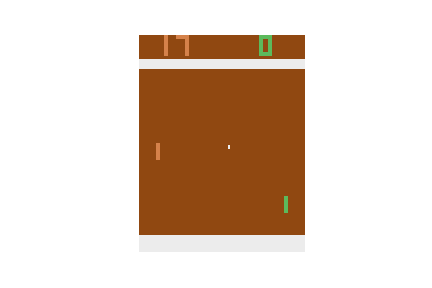
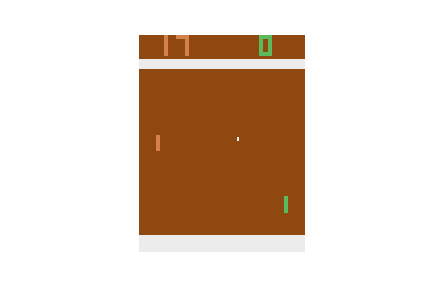
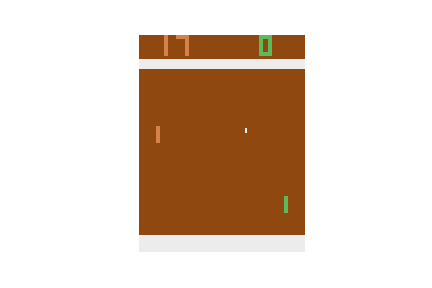
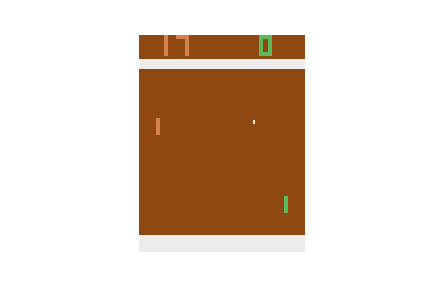
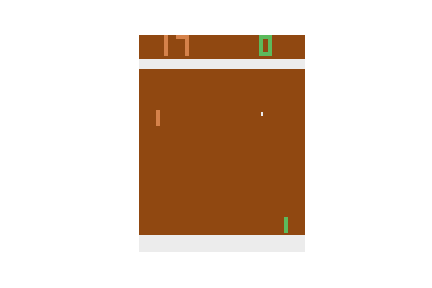
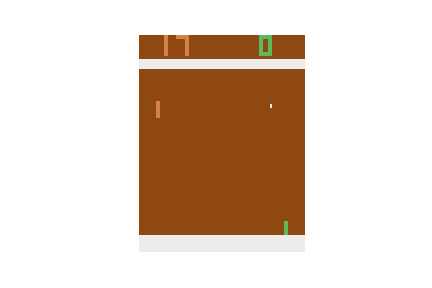
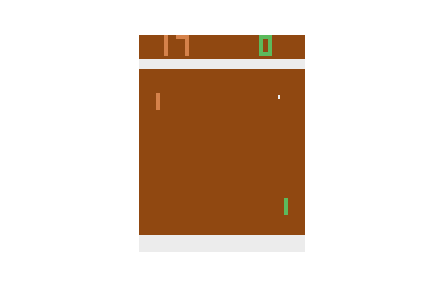
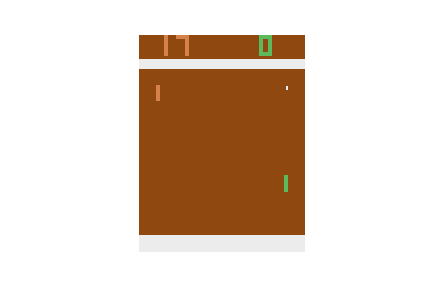
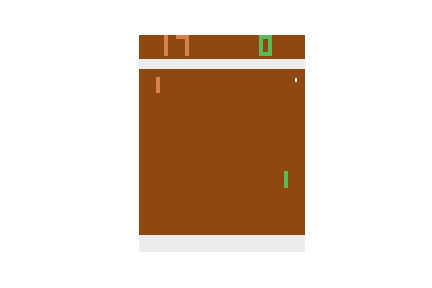
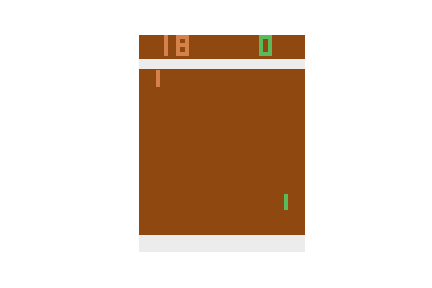
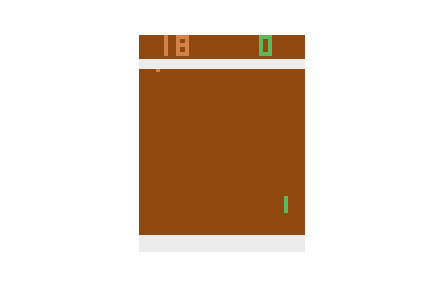
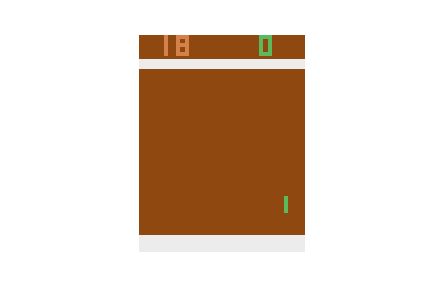
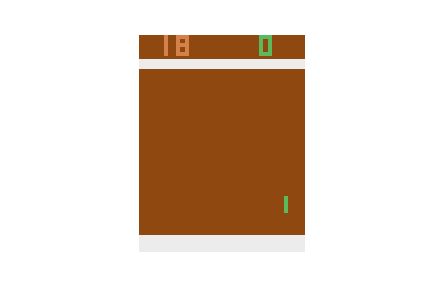
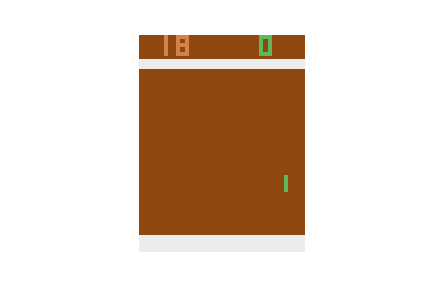
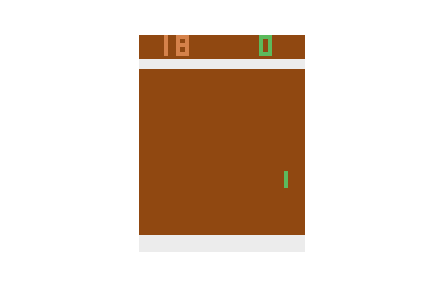
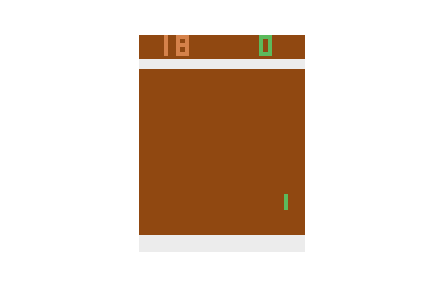
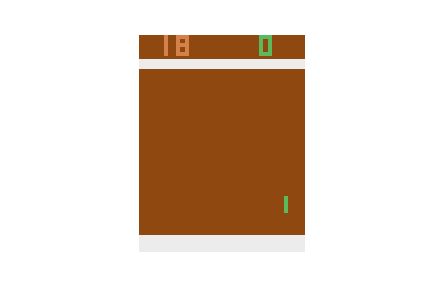
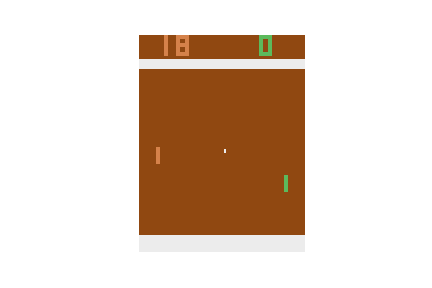
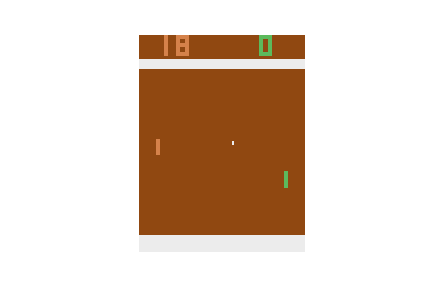
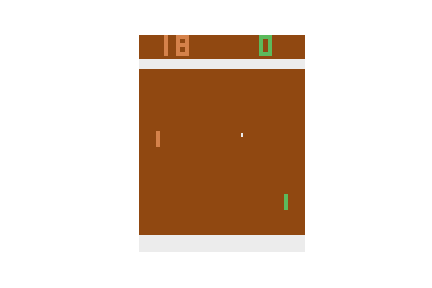
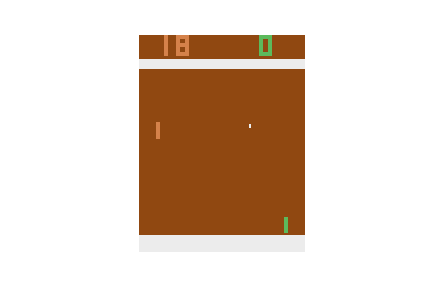
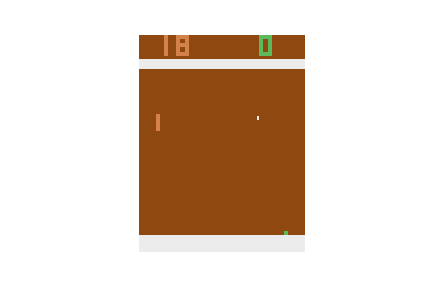
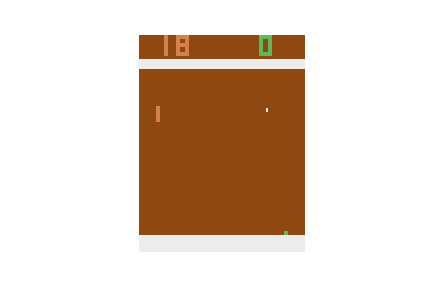
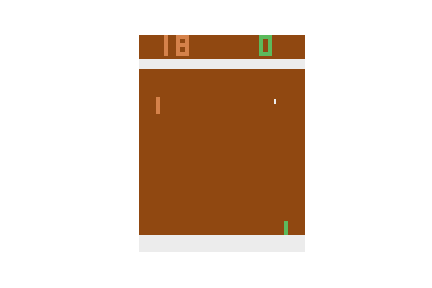
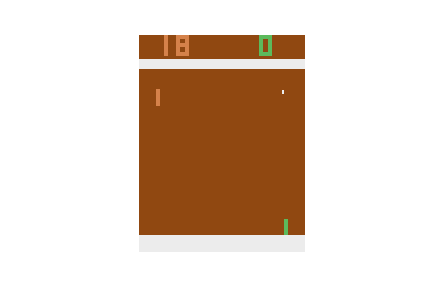
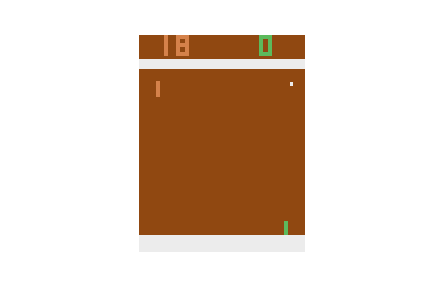
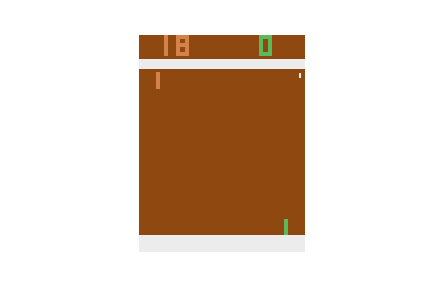
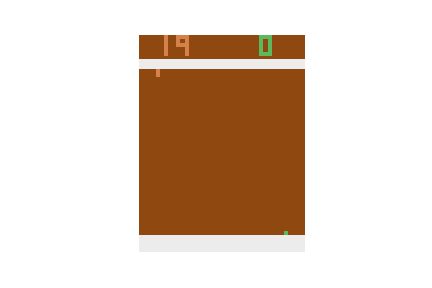
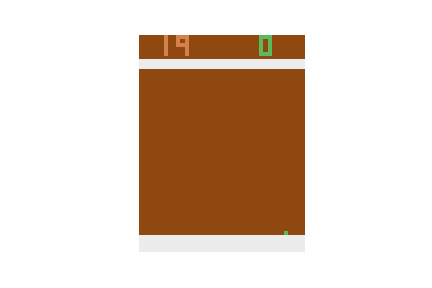
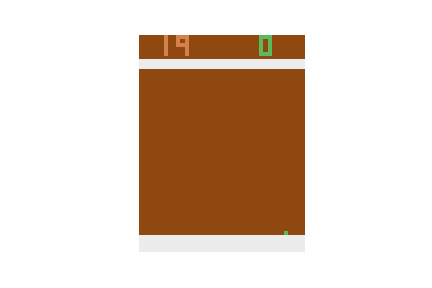
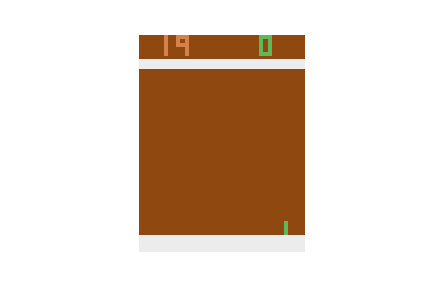
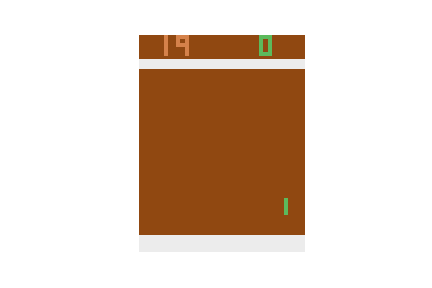
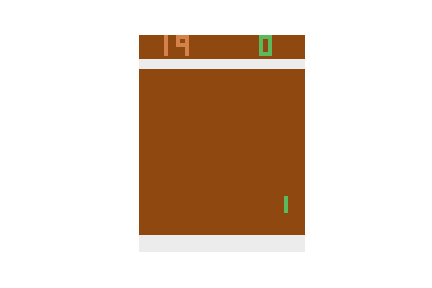
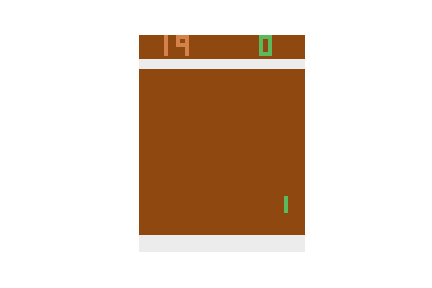
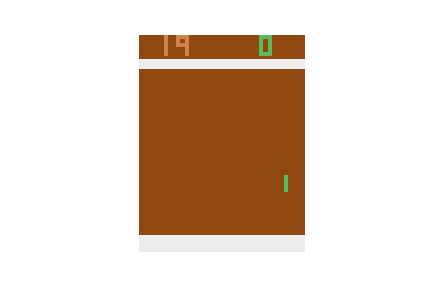
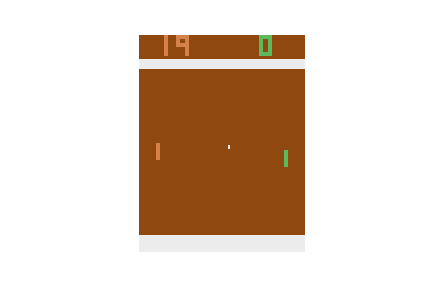
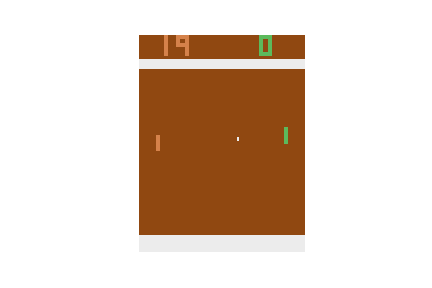
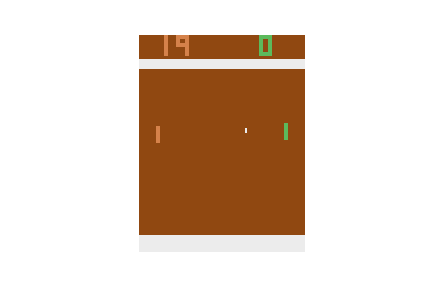
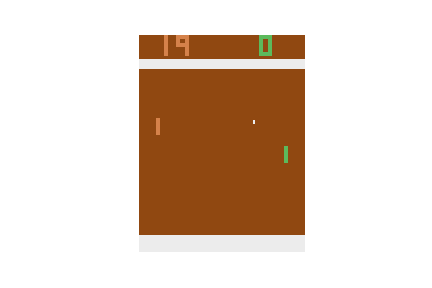
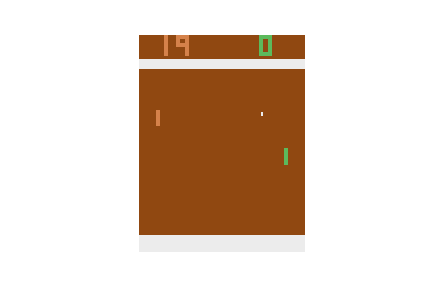
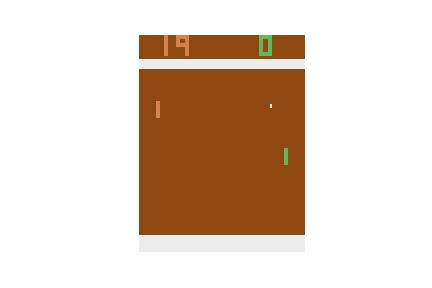
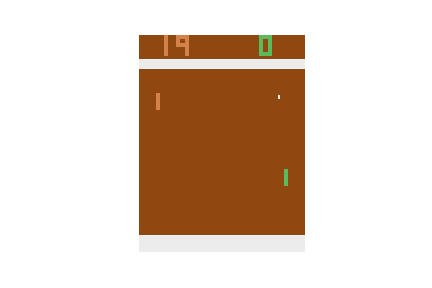
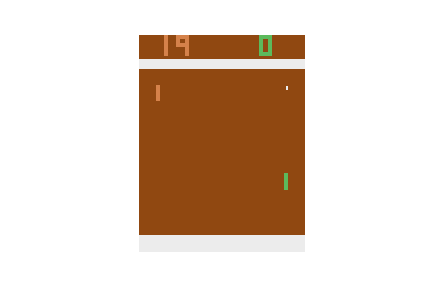
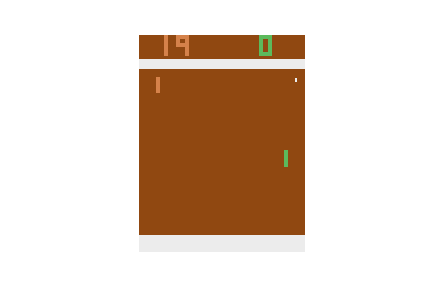
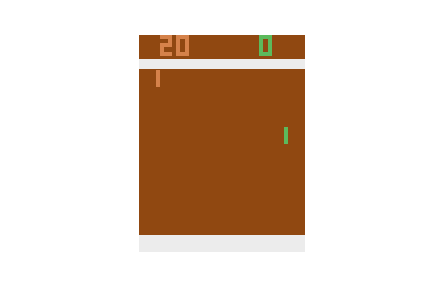
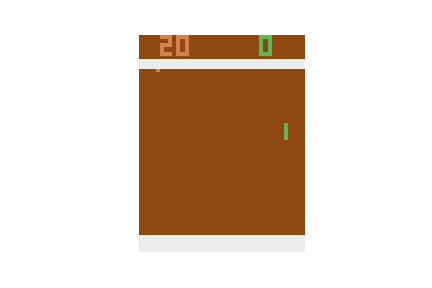
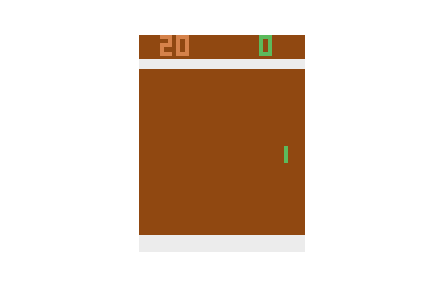
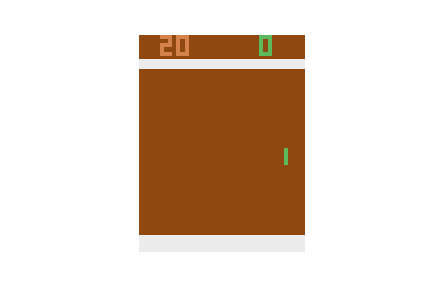
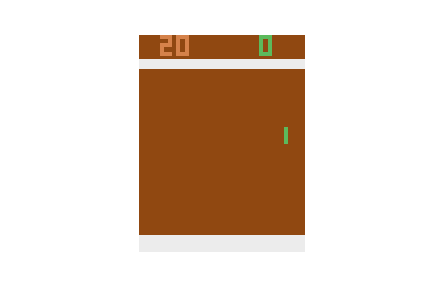
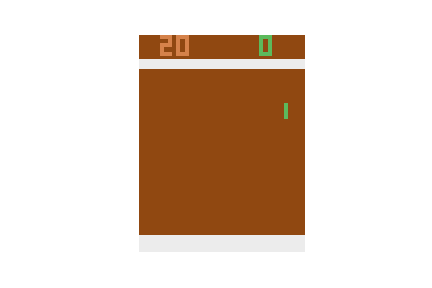
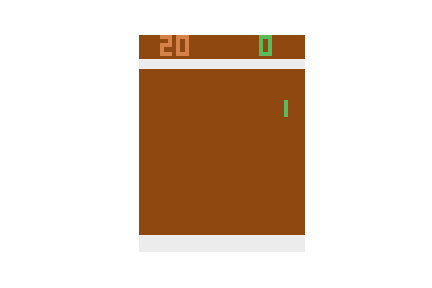
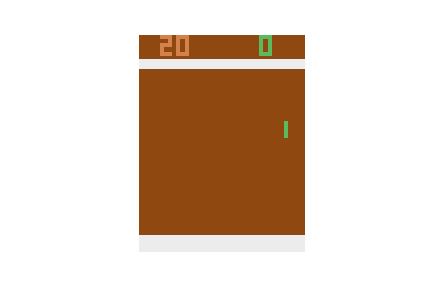
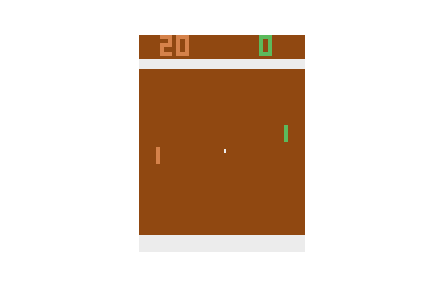
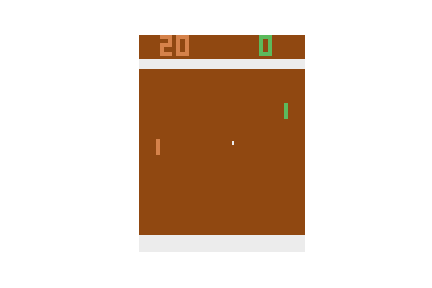
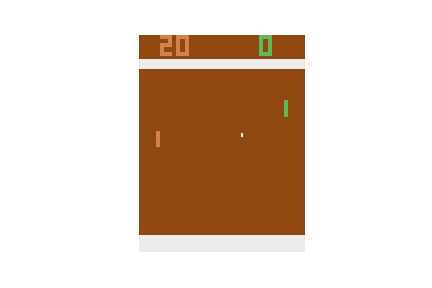
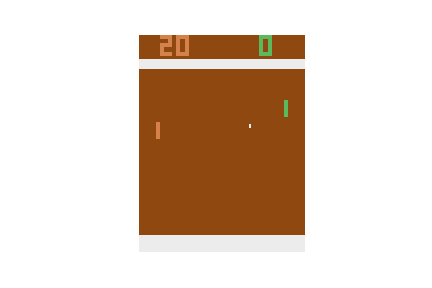
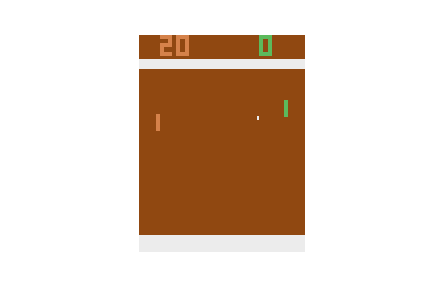
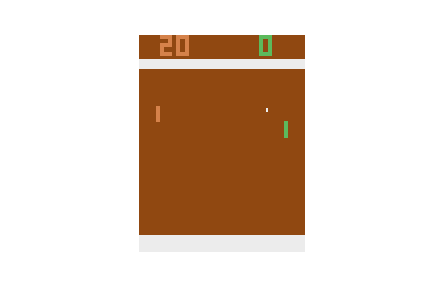
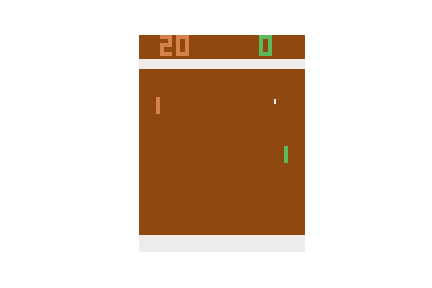
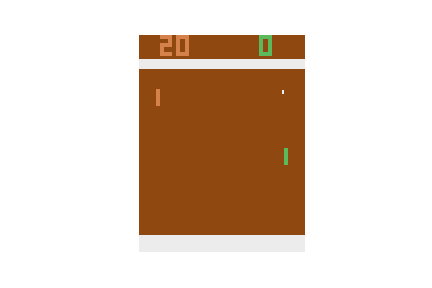
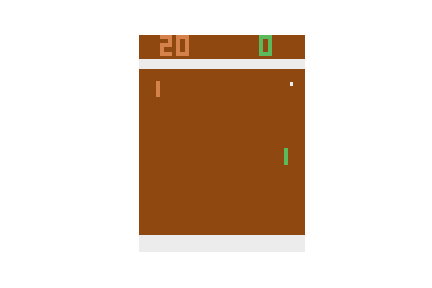
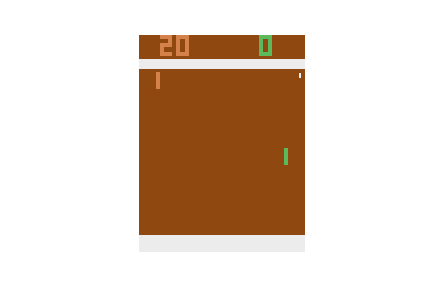

In [15]:
# play game after training!
pong_utils.play(env, policy, time=2000) 

In [ ]:
plt.plot(mean_rewards)

In [ ]:
# save your policy!
torch.save(policy, 'REINFORCE.policy')

# load your policy if needed
# policy = torch.load('REINFORCE.policy')

# try and test out the solution!
# policy = torch.load('PPO_solution.policy')

# My Tests

In [84]:
import my_pong_utils as pu
import torch
import numpy as np
from pong_network import PongNetwork
import torch.nn as nn
import pong_config as pc 
from collections import deque

In [6]:
def process_pong_frame(image):
    """Returns a 80x80 pixel a single pong frame.
    Input image is 160x160x3
    """
    return np.mean(image[34:-16:2, ::2] - np.array([244, 72, 17]), -1) / 255

In [9]:
env.reset()
frame1, reward1, is_done, _ = env.step(0)
frame2, reward2, is_done, _ = env.step(0)

/home/arko/anaconda3/envs/udacity_deep_rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


In [11]:
frame11 = pu.process_pong_frame(frame1)
frame22 = pu.process_pong_frame(frame2)

In [13]:
np.array([frame11, frame22]).shape

(2, 80, 80)

In [16]:
x = np.array([frame11, frame22, frame11, frame22])
np.expand_dims(x, axis=-1).shape

(4, 80, 80, 1)

In [30]:
# tx = torch.tensor(x, dtype=float)
tx = torch.from_numpy(x).float()
tx.shape

torch.Size([4, 80, 80])

In [114]:
pn = PongNetwork(num_frames=4, num_actions=2)

In [115]:
pn

PongNetwork(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [116]:
act = pn.forward(state=tx)
act

torch.Size([4, 80, 80])
torch.Size([64, 6, 6])
torch.Size([4, 576])
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/arko/anaconda3/envs/udacity_deep_rl/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_21334/3992681859.py", line 1, in <cell line: 1>
    act = pn.forward(state=tx)
  File "/home/arko/my_github_repos/rl-experiments/Pong/pong_network.py", line 43, in forward
    return self.fc(conv_out)
  File "/home/arko/anaconda3/envs/udacity_deep_rl/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/arko/anaconda3/envs/udacity_deep_rl/lib/python3.10/site-packages/torch/nn/modules/container.py", line 139, in forward
    input = module(input)
  File "/home/arko/anaconda3/envs/udacity_deep_rl/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/arko/anaconda3/envs/udacity_

In [107]:
4 * 576

2304

In [83]:
torch.argmax(act)

tensor(0)

In [85]:
dx = deque(maxlen=4)

In [86]:
dx

deque([])

In [87]:
dx.append(np.array([1, 2, 3]))
dx

deque([array([1, 2, 3])])

In [88]:
dx.append(np.array([2, 3, 4]))
dx

deque([array([1, 2, 3]), array([2, 3, 4])])

In [89]:
dx.append(np.array([3, 4, 5]))
dx

deque([array([1, 2, 3]), array([2, 3, 4]), array([3, 4, 5])])

In [90]:
dx.append(np.array([4, 5, 6]))
dx

deque([array([1, 2, 3]), array([2, 3, 4]), array([3, 4, 5]), array([4, 5, 6])])

In [91]:
dx.append(np.array([5, 6, 7]))
dx

deque([array([2, 3, 4]), array([3, 4, 5]), array([4, 5, 6]), array([5, 6, 7])])

In [98]:
def preprocess_batch(images, bkg_color=np.array([144, 72, 17])):
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = (
        np.mean(list_of_images[:, :, 34:-16:2, ::2] - bkg_color, axis=-1) / 255.0
    )
    print(list_of_images_prepro.shape)
    batch_input = np.swapaxes(list_of_images_prepro, 0, 1)
    return torch.from_numpy(batch_input).float() #.to(device)

In [99]:
xout = preprocess_batch([frame1, frame2])

(2, 1, 80, 80)


In [100]:
xout.shape

torch.Size([1, 2, 80, 80])